In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# CHEKING DISK STORAGE

In [2]:
import shutil

# Get disk space details
total, used, free = shutil.disk_usage("/")

# Convert to human-readable format
def format_size(size):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024:
            return f"{size:.2f} {unit}"
        size /= 1024

print(f"Total Space: {format_size(total)}")
print(f"Used Space: {format_size(used)}")
print(f"Free Space: {format_size(free)}")

Total Space: 915.32 GB
Used Space: 774.23 GB
Free Space: 94.52 GB


In [3]:
import os

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            # Add file size, skipping broken symbolic links
            if os.path.exists(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

def print_directory_size(directory):
    size_bytes = get_directory_size(directory)
    # Convert bytes to a human-readable format (KB, MB, GB)
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size_bytes < 1024:
            print(f"Size of '{directory}': {size_bytes:.2f} {unit}")
            break
        size_bytes /= 1024

# Example usage
preprocessed_files_path = "data/train_data/preprocessed_files"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

preprocessed_files_path = "executions"  # Change this to your target directory
print_directory_size(preprocessed_files_path)

Size of 'data/train_data/preprocessed_files': 55.32 GB
Size of 'executions': 11.29 GB


# SETTINGS TUNING - TRAIN - TEST EXECUTION

In [4]:
############### EXECUTION SETTINGS ###############

PARENT_EXECUTION_DIR = "executions/unet/tuning-train-test"

################### DATA SETTINGS #################

DATA_DIR = "data/train_data"  
# Directory where the samples (data and labels folders) and the metadata.json file are located.

METADATA_DATASET = "metadata_38_samples.json"  
# Name of the metadata.json file located in DATA_DIR, which contains the specifications of the samples and their corresponding information used to create the dataset.

K_FOLDS = 6
# Number of folds for the execution

NUM_WORKERS = 4
# Number of logical CPU Cores used for parallelizing data laoding

################### HYPERPARAMETER TUNING SETTINGS #################

CALLS_LIMIT_HP_TUNING = 10

# CREATING EXECUTION DIRECTORY

In [5]:
import os

executions_ids = [
    int(execution_dir.split('-')[0].split('=')[1])
    for model_dir in os.listdir("executions")
    if os.path.isdir(os.path.join("executions", model_dir))  and model_dir != ".ipynb_checkpoints"
    for execution_type_dir in os.listdir(os.path.join("executions", model_dir))
    if os.path.isdir(os.path.join("executions", model_dir, execution_type_dir)) and execution_type_dir != ".ipynb_checkpoints"
    for execution_dir in os.listdir(os.path.join("executions", model_dir, execution_type_dir))
    if os.path.isdir(os.path.join("executions", model_dir, execution_type_dir, execution_dir)) and execution_dir != ".ipynb_checkpoints"
]

print(f"Total executions previously done: {len(executions_ids)}")

parent_execution_dir_path = os.path.join(PARENT_EXECUTION_DIR)

# Count the subdirectories inside parent_execution_dir_path
executions_parent_dir_count = len([
    d for d in os.listdir(parent_execution_dir_path)
    if os.path.isdir(os.path.join(parent_execution_dir_path, d)) and d != ".ipynb_checkpoints"
])

print(f"Total executions previously done ({PARENT_EXECUTION_DIR}): {executions_parent_dir_count}")

execution_id = max(executions_ids) + 1  # Assign 0 if the list is empty, otherwise the count of execution_directories

print(f"Assigned execution_id: {execution_id}")

# Create a unique experiment configuration identifier
experiment_config_id = (
    f"id={execution_id}"
)

# Define and create the execution directory
execution_dir = os.path.join(parent_execution_dir_path, experiment_config_id)
os.makedirs(execution_dir, exist_ok=True)

print(f"Created execution directory: {execution_dir}")


Total executions previously done: 34
Total executions previously done (executions/unet/tuning-train-test): 4
Assigned execution_id: 123
Created execution directory: executions/unet/tuning-train-test/id=123


# DATA SPLITTING

In [6]:
import sys
import importlib

# Import the whole module 'lr_schedulers'
import utils.data_utils

# Reload the 'lr_schedulers' module
importlib.reload(utils.data_utils)

# Now, you can import the class from the reloaded module
from utils.data_utils import load_metadata, stratified_split, k_fold_stratified_split
import os

#Load metadata into a dict
metadata = load_metadata(os.path.join(DATA_DIR, METADATA_DATASET))

k_fold_splits = k_fold_stratified_split(metadata, k=K_FOLDS)

# We take the first split for defining the validation set
split_hyperparameter_tuning = k_fold_splits[0]
train_test_files, validation_files = split_hyperparameter_tuning[0], split_hyperparameter_tuning[1]

# We generate the train_test splits with the rest of the data that is not used for validation
train_test_splits = k_fold_stratified_split(train_test_files, k=K_FOLDS-1)



==================== 6-FOLD TRAINING/VALIDATION SPLIT ====================


==================== SPLIT: 0 ====================

==========> TRAINING SET

 SAMPLES: dict_keys(['R_003', 'R_004', 'R_006', 'R_007', 'R_009', 'R_010', 'R_011', 'R_013', 'R_014', 'R_015', 'R_016', 'R_017', 'R_018', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_005', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_011', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_017', 'Z_018'])

==========> VALIDATION SET

 SAMPLES: dict_keys(['R_002', 'R_005', 'R_008', 'R_012', 'Z_010', 'Z_019', 'Z_020'])

==================== SPLIT: 1 ====================

==========> TRAINING SET

 SAMPLES: dict_keys(['R_002', 'R_004', 'R_005', 'R_006', 'R_007', 'R_008', 'R_009', 'R_010', 'R_011', 'R_012', 'R_013', 'R_014', 'R_016', 'R_017', 'R_018', 'R_019', 'Z_002', 'Z_003', 'Z_005', 'Z_006', 'Z_007', 'Z_010', 'Z_011', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_017', 'Z_018', 'Z_019', 'Z_020'])

==========> VALIDATION SET

 SAMPLES: dict_keys

# GENERATING EXECUTION INFORMATION JSON

In [7]:
import json

# Define the settings as a dictionary
info_execution = {

    "INFO_EXECUTION": {
        "PARENT_EXECUTION_DIR": PARENT_EXECUTION_DIR,
        "EXECUTION_ID": execution_id,
        "EXECUTION_DIR": experiment_config_id,
        # Directory where the results of this execution will be stored.
    },
    
    "DATA_SETTINGS": {
        "DATA_DIR": DATA_DIR,
        # Directory where the samples (data and labels folders) and the metadata.json file are located.
        "METADATA_DATASET": METADATA_DATASET,
        # Name of the metadata.json file located in DATA_DIR, which contains the specifications of the samples and their corresponding information used to create the dataset.
        "K_FOLDS": K_FOLDS,
        # Number of folds for k-fold used
        "NUM_WORKERS": NUM_WORKERS, 
        # Number of logical CPU Cores used for parallelizing data laoding
        "SAMPLES_DATASET": list(metadata.keys()),
        "VALIDATION_SET": list(validation_files.keys()),
        "TRAIN_TEST_SPLITS": {},
    },

    "HYPERPARAMETER_TUNING_SETTINGS": {
        "LIMIT_TRIALS": CALLS_LIMIT_HP_TUNING,
    },

}

for split_idx, (train_files, test_files) in enumerate(train_test_splits):
    info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"][f"SPLIT_{split_idx}"] = {}
    info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"][f"SPLIT_{split_idx}"]["TRAIN_SET"] = list(train_files.keys())
    info_execution["DATA_SETTINGS"]["TRAIN_TEST_SPLITS"][f"SPLIT_{split_idx}"]["TEST_SET"] = list(test_files.keys())

info_execution_json_file_path = os.path.join(execution_dir, "info_execution.json")

# Save the dictionary as a pretty JSON file
with open(info_execution_json_file_path, "w") as json_file:
    json.dump(info_execution, json_file, indent=4)

# Print success message
print(f"Execution information JSON file successfully generated at: {info_execution_json_file_path}")

Execution information JSON file successfully generated at: executions/unet/tuning-train-test/id=123/info_execution.json


# HYPERTUNING

# Import UNET_VGG11 LIGHTNING MODEL

In [8]:
import importlib
from models.unet import UNET_VGG11_lightning_model

# Reload the module (if necessary)
importlib.reload(UNET_VGG11_lightning_model)

# Import the class from the reloaded module
from models.unet.UNET_VGG11_lightning_model import UNET_VGG11_LightningModel

All imports succeeded!
All imports succeeded!
All imports succeeded!
All imports succeeded!
All imports succeeded!


# Import UNET_VGG11 DATASET

In [9]:
import importlib
from models.unet import UNET_VGG11_dataset

# Reload the module (if necessary)
importlib.reload(UNET_VGG11_dataset)

# Import the class from the reloaded module
from models.unet.UNET_VGG11_dataset import UNET_VGG11_Dataset


All imports succeeded!
All imports succeeded!


# HYPERTUNING

In [ ]:
import optuna
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import pprint
import shutil
import gc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os

import importlib
# Own library
import utils.data_utils
importlib.reload(utils.data_utils)
from utils.data_utils import custom_collate

# Create the directory
tuning_dir = os.path.join(execution_dir, 'tuning')
os.makedirs(tuning_dir, exist_ok=True)  # `exist_ok=True` prevents error if the directory already exists
print(f"Tuning directory created: {tuning_dir}")


# Set to track seen parameter combinations
seen_params = set()
best_trial_info = {
    "result": float('inf'),
}  # Store result and config together

def flatten_dict(d, parent_key=()):
    """
    Recursively flatten a nested dictionary.
    Args:
        d: The dictionary to flatten.
        parent_key: Tuple to store the parent keys.
    Returns:
        A flattened dictionary with tuple keys.
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + (k,)
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key).items())
        else:
            items.append((new_key, v))
    return dict(items)

def objective(trial):
    try:

        global best_trial_info
        global lr_weight_decay_options
        
        ########## TRAINING/INFERENCE HYPERPARAMETERS #########
    
        lr_optimizer = trial.suggest_float("lr_optimizer", 1e-5, 1e-3, log=True)  # Log scale for learning rates
        weight_decay_optimizer = trial.suggest_float("weight_decay_optimizer", 1e-6, 1e-2, log=True) # Log scale for weight decay
        warmup_epochs_lr_scheduler = trial.suggest_int("warmup_epochs_lr_scheduler", 10, 1000)  # Integer range
        max_training_epochs = trial.suggest_categorical("max_training_epochs", [10000])
        patience_epochs_early_stopping = trial.suggest_int("patience_epochs_early_stopping", 10, 100)  # Integer range
        batch_size = trial.suggest_categorical("batch_size", [1,2,4])
        pre_processing_technique = trial.suggest_categorical("pre_processing_technique", ["pct","ppt"])
        pre_processing_channels = 10
        
        ########################################################################
        
        training_config={
            "lr_optimizer": lr_optimizer,
            "weight_decay_optimizer": weight_decay_optimizer,
            "warmup_epochs_lr_scheduler": warmup_epochs_lr_scheduler,
            "max_training_epochs": max_training_epochs,
            "patience_epochs_early_stopping": patience_epochs_early_stopping,
            "batch_size": batch_size,
            "pre_processing_technique": pre_processing_technique,
            "pre_processing_channels": pre_processing_channels
        }

        # Combine all configs into a single dictionary
        trial_config = {
            "TRAINING_CONFIG": training_config,
        }

        print()
        print(f"{'=' * 50}")
        print(f"{'=' * 16} RUNNING TRIAL: {trial.number} {'=' * 16}")
        print(f"{'=' * 50}")
        print()
        
        # Pretty-print the configurations
        pprint.pprint(trial_config, sort_dicts=False, width=100)

        print()

        # Flatten the trial_config
        flattened_params = flatten_dict(trial_config)

        # Convert the flattened dictionary to a tuple for hashing
        current_params = tuple(sorted(flattened_params.items()))
        
        # Skip repeated combinations
        if current_params in seen_params:
            print(f"{'=' * 50}")
            print(f"{'=' * 14} TRIAL {trial.number} SKIPPED - CONFIG ALREADY TRIED {'=' * 14}")
            print(f"{'=' * 50}")
            print()
            raise optuna.exceptions.TrialPruned()
        
        ########## DATA PREPARATION #########

        # Creation Datasets
        train_dataset = UNET_VGG11_Dataset(
            metadata_dict_with_files_selected=train_files,
            data_dir=DATA_DIR,
            preprocessing_technique = trial_config["TRAINING_CONFIG"]["pre_processing_technique"],
            preprocessing_channels = trial_config["TRAINING_CONFIG"]["pre_processing_channels"]
            
        )

        val_dataset = UNET_VGG11_Dataset(
            metadata_dict_with_files_selected=validation_files,
            data_dir=DATA_DIR,
            preprocessing_technique = trial_config["TRAINING_CONFIG"]["pre_processing_technique"],
            preprocessing_channels = trial_config["TRAINING_CONFIG"]["pre_processing_channels"]
        )

        # Configure DataLoaders
        train_loader = DataLoader(train_dataset, batch_size=trial_config["TRAINING_CONFIG"]["batch_size"], shuffle=True, num_workers=NUM_WORKERS)
        val_loader = DataLoader(val_dataset, batch_size=trial_config["TRAINING_CONFIG"]["batch_size"], num_workers=NUM_WORKERS)
        
        ########## MODEL INSTANTIATION #########
        
        model = UNET_VGG11_LightningModel(
            lr_optimizer = trial_config["TRAINING_CONFIG"]["lr_optimizer"],
            weight_decay_optimizer = trial_config["TRAINING_CONFIG"]["weight_decay_optimizer"],
            warmup_epochs_lr_scheduler = trial_config["TRAINING_CONFIG"]["warmup_epochs_lr_scheduler"]
        )

        ########## TRAINER INSTANTIATION #########

        # Early stopping callback
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=trial_config["TRAINING_CONFIG"]["patience_epochs_early_stopping"],
            mode='min'
        )

        # Define logger
        logger = CSVLogger(
            save_dir=tuning_dir,
            name="",
            version="")
        
        trainer = Trainer(
            max_epochs=trial_config["TRAINING_CONFIG"]["max_training_epochs"],
            callbacks=[early_stopping_callback],
            precision="16-mixed",  # Enable FP16 mixed precision
            enable_checkpointing=False,
            log_every_n_steps=1,
            logger=logger,
            # Add timeout for this trial
            # max_time="00:00:02:00"  # Limit TIME (DD:HH:MM:SS format)
        )

        ########## TRAINING #########

        # Train the model
        trainer.fit(model, train_loader, val_loader)

        # Retrieve the best validation loss
        metrics_file = os.path.join(tuning_dir, 'metrics.csv')
        metrics_df = pd.read_csv(metrics_file)
        
        # Initialize variables to make them accessible outside the if scope
        lowest_val_loss = None
        lowest_epoch = None

        # Ensure val_loss column exists and drop NaN values
        if 'val_loss_epoch' in metrics_df.columns:
            val_loss_series = metrics_df['val_loss_epoch'].dropna()
            # Find the lowest val_loss
            lowest_val_loss = val_loss_series.min()
            # Find the epoch corresponding to the lowest val_loss
            lowest_val_loss_row = metrics_df.loc[val_loss_series.idxmin()]
            lowest_epoch = lowest_val_loss_row['epoch']
        
            print(f"Lowest val_loss: {lowest_val_loss} at epoch {lowest_epoch}")
        else:
            print(f"val_loss column not found in {metrics_file}")

        ######### PLOTTING ##########

        ##### PLOT BEST VAL RESULTS ##### 

        # Find unique classes dynamically
        all_classes = set()
        for gt, pred in zip(model.best_epoch_val_ground_truths, model.best_epoch_val_predictions):
            all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
            all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions
        
        # Sort the classes to ensure order
        all_classes = sorted(all_classes)
        
        # Define class labels dynamically (for simplicity, use numeric labels for now)
        class_labels = {cls: f"Class {cls}" for cls in all_classes}
        num_classes = len(class_labels)
        
        # Create a discrete colormap with exactly `num_classes` colors
        colormap = plt.cm.get_cmap("viridis", num_classes)
        
        # Create legend patches using discrete colors from the colormap
        legend_patches = [
            mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
            for i, label in class_labels.items()
        ]
        
        # Plot all results together
        num_samples = len(model.best_epoch_val_ground_truths)
        
        # Create the figure
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
        
        # Ensure axes is always 2D
        if num_samples == 1:
            axes = axes[None, :]  # Ensure axes is 2D when there's only one sample
        
        # Plot ground truth and predictions
        for sample_idx, (sample_id, ground_truth, prediction) in enumerate(zip(model.best_epoch_val_sample_ids, model.best_epoch_val_ground_truths, model.best_epoch_val_predictions)):
            # Ground truth
            im_gt = axes[sample_idx, 0].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
            axes[sample_idx, 0].set_title(f"Sample {sample_id} - Ground Truth")
            axes[sample_idx, 0].axis("off")
        
            # Prediction
            im_pred = axes[sample_idx, 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
            axes[sample_idx, 1].set_title(f"Sample {sample_id} - Prediction")
            axes[sample_idx, 1].axis("off")
        
        # Add a single legend for the entire figure
        fig.legend(
            handles=legend_patches,
            loc="upper center",
            ncol=num_classes,
            bbox_to_anchor=(0.5, 1.02),
            fontsize=12
        )
        
        # Add a title for the entire figure
        fig.suptitle(f"Trial {trial.number}\n Ground Truth vs Prediction \n lowest_val_loss : {lowest_val_loss:.4f} - lowest_epoch: {lowest_epoch}", fontsize=16, y=1.10)
        plt.tight_layout

        ##### PLOT TRAINING & VALIDATION LOSSES EVOLUTION ##### 

        print()
        print(f"{'=' * 10} PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION {'=' * 10}")
        print()
        
        # Path to the latest metrics file
        metrics_file = os.path.join(tuning_dir, 'metrics.csv')
        
        # Load the logged metrics
        metrics_df = pd.read_csv(metrics_file)
        
        # Ensure metrics_df is loaded
        # Filter rows where train_loss_epoch and val_loss_epoch are not NaN
        train_loss = metrics_df['train_loss_epoch'].dropna()
        val_loss = metrics_df['val_loss_epoch'].dropna()
        
        # Use the 'epoch' column as x-axis
        epochs_train = metrics_df.loc[metrics_df['train_loss_epoch'].notna(), 'epoch']
        epochs_val = metrics_df.loc[metrics_df['val_loss_epoch'].notna(), 'epoch']
        
        # Plot Training and Validation Loss
        plt.figure(figsize=(10, 6))
        plt.plot(epochs_train, train_loss, label="Training Loss")
        plt.plot(epochs_val, val_loss, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Trial {trial.number} \n Training and Validation Loss Over Epochs\n lowest_val_loss : {lowest_val_loss:.4f} - lowest_epoch: {lowest_epoch}")
        plt.legend()
        plt.grid(True)        
        plt.show()
        plt.close(fig)

        if best_trial_info["result"] > lowest_val_loss:
            
            best_trial_info["result"] = lowest_val_loss
            
            ##### SAVING PLOT BEST VALIDATION RESULTS #####
            # Save the ground truth and predictions plot
            result_plot_path = os.path.join(tuning_dir, f"validation_results_best_trial.png")
            
            fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
            if num_samples == 1:
                axes = axes[None, :]  # Ensure axes is 2D when there's only one sample
            
            for sample_idx, (sample_id, ground_truth, prediction) in enumerate(zip(model.best_epoch_val_sample_ids, model.best_epoch_val_ground_truths, model.best_epoch_val_predictions)):
                # Ground truth
                axes[sample_idx, 0].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
                axes[sample_idx, 0].set_title(f"Sample {sample_id} - Ground Truth")
                axes[sample_idx, 0].axis("off")
        
                # Prediction
                axes[sample_idx, 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
                axes[sample_idx, 1].set_title(f"Sample {sample_id} - Prediction")
                axes[sample_idx, 1].axis("off")
        
            fig.legend(
                handles=legend_patches,
                loc="upper center",
                ncol=num_classes,
                bbox_to_anchor=(0.5, 1.02),
                fontsize=12
            )
        
            fig.suptitle(f"Trial {trial.number}\n Ground Truth vs Prediction \n lowest_val_loss : {lowest_val_loss:.4f} - lowest_epoch: {lowest_epoch}", fontsize=16, y=1.10)
            plt.tight_layout()
            fig.savefig(result_plot_path, dpi=300, bbox_inches="tight")
            print(f"Validation results plot saved at: {result_plot_path}")
            plt.close(fig)
        
            ##### SAVING PLOT TRAINING & VALIDATION LOSSES EVOLUTION #####
            loss_plot_path = os.path.join(tuning_dir, f"training_validation_loss_evolution_best_trial.png")
        
            plt.figure(figsize=(10, 6))
            plt.plot(epochs_train, train_loss, label="Training Loss")
            plt.plot(epochs_val, val_loss, label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Trial {trial.number} \n Training and Validation Loss Over Epochs\n lowest_val_loss : {lowest_val_loss:.4f} - lowest_epoch: {lowest_epoch}")
            plt.legend()
            plt.grid(True)
            plt.savefig(loss_plot_path, dpi=300, bbox_inches="tight")
            print(f"Training and validation loss plot saved at: {loss_plot_path}")
            plt.close()

            # Generate JSON with best trial's hyperparameter config
            info_best_trial_json_file_path = os.path.join(execution_dir, "best_trial_config.json")
            with open(info_best_trial_json_file_path, "w") as json_file:
                json.dump(trial_config, json_file, indent=4)
            print(f"Best trial config JSON file successfully generated at: {info_best_trial_json_file_path}")
            
    
        del model
        del trainer
        torch.cuda.empty_cache()
        gc.collect()
        
        return lowest_val_loss

    except torch.cuda.OutOfMemoryError:
        del model
        del trainer
        torch.cuda.empty_cache()
        gc.collect()
        print()
        print(f"{'=' * 50}")
        print(f"{'=' * 14} TRIAL {trial.number} SKIPPED - CUDA OUT OF MEMORY ERROR {'=' * 14}")
        print(f"{'=' * 50}")
        print()
        trial.report(float('inf'), step=0)  # Assign a penalty 
        raise optuna.exceptions.TrialPruned()

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=CALLS_LIMIT_HP_TUNING)
#study.optimize(objective, timeout=60*60*12)

# STUDY INFO TO JSON

In [11]:
# Function to save study info to JSON
def save_study_to_json(study, file_path):
    # Extract information for all trials
    trials_data = []
    for trial in study.trials:
        trials_data.append({
            "number": trial.number,
            "params": trial.params,
            "value": trial.value,
            "state": trial.state.name,  # Convert enum to string
            "datetime_start": str(trial.datetime_start),
            "datetime_complete": str(trial.datetime_complete),
        })

    # Organize the data into a dictionary
    study_info = {
        "study_name": study.study_name,
        "direction": study.direction.name,  # Convert enum to string
        "best_trial": {
            "number": study.best_trial.number,
            "value": study.best_trial.value,
            "params": study.best_trial.params,
        } if study.best_trial else None,
        "trials": trials_data
    }

    # Save to JSON file
    with open(file_path, "w") as f:
        json.dump(study_info, f, indent=4)

    print(f"Study information saved to {file_path}")

study_json_path = os.path.join(tuning_dir, "study_info.json")
save_study_to_json(study, study_json_path)

Study information saved to executions/unet/tuning-train-test/id=123/tuning/study_info.json


# INFO HYPERPARAMETER TUNING

In [12]:
import plotly.io as pio
pio.renderers.default = 'iframe'  # For JupyterLab and Jupyter Notebook

# Visualize results
from optuna.visualization import plot_optimization_history
# Plot optimization history
fig = plot_optimization_history(study)

# Save the plot as an image file (e.g., PNG)
image_file_path = os.path.join(tuning_dir, "optimization_history.png")
fig.write_image(image_file_path)

print(f"Plot saved as an image at: {image_file_path}")
plot_optimization_history(study)

Plot saved as an image at: executions/unet/tuning-train-test/id=123/tuning/optimization_history.png


In [13]:
# Visualize results
from optuna.visualization import plot_param_importances
# Plot parameter importances
fig = plot_param_importances(study)

# Save the plot as an image file (e.g., PNG)
image_file_path = os.path.join(tuning_dir, "param_importances.png")
fig.write_image(image_file_path)

print(f"Plot saved as an image at: {image_file_path}")
plot_param_importances(study)

Plot saved as an image at: executions/unet/tuning-train-test/id=123/tuning/param_importances.png


Total Study Runtime: 0:38:24.954455
Average Trial Duration: 0:03:50.494671
Minimum Trial Duration: 0:01:29.068725
Maximum Trial Duration: 0:06:33.340397
Total Time for COMPLETE: 0:38:24.946714
Study's temporal info plot saved at: executions/unet/tuning-train-test/id=123/tuning/temporal_info_study.png


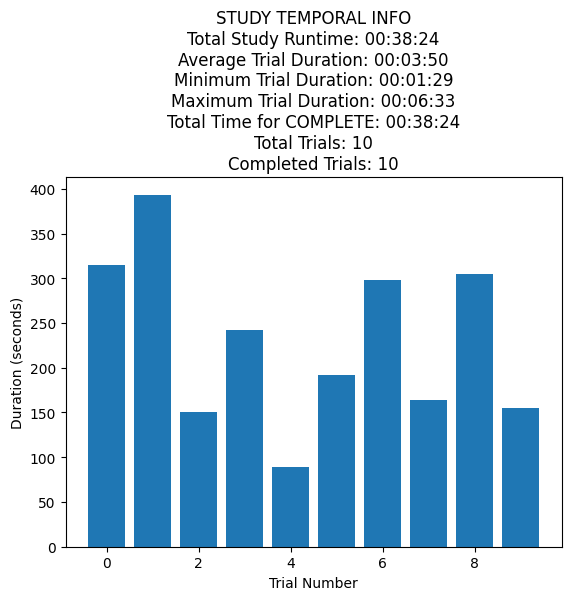

In [14]:
from datetime import timedelta, datetime
from collections import defaultdict
import matplotlib.pyplot as plt

# Study-Level Statistics
study_start_time = min(
    (trial.datetime_start for trial in study.trials if trial.datetime_start),
    default=None
)

study_end_time = max(
    (trial.datetime_complete for trial in study.trials if trial.datetime_complete),
    default=datetime.now()
)
total_study_runtime = study_end_time - study_start_time

print(f"Total Study Runtime: {total_study_runtime}")

# Trial-Level Statistics
trial_durations = [
    trial.datetime_complete - trial.datetime_start
    for trial in study.trials
    if trial.datetime_start and trial.datetime_complete
]

if trial_durations:
    avg_duration = sum(trial_durations, timedelta()) / len(trial_durations)
    min_duration = min(trial_durations)
    max_duration = max(trial_durations)

    print(f"Average Trial Duration: {avg_duration}")
    print(f"Minimum Trial Duration: {min_duration}")
    print(f"Maximum Trial Duration: {max_duration}")
else:
    print("No completed trials to calculate durations.")

# Time by Trial State
state_durations = defaultdict(timedelta)
for trial in study.trials:
    if trial.datetime_start and trial.datetime_complete:
        duration = trial.datetime_complete - trial.datetime_start
        state_durations[trial.state] += duration

state_info_str = ""
for state, total_duration in state_durations.items():
    state_info = f"Total Time for {state.name}: {total_duration}"
    print(state_info)
    state_info_str += state_info + "\n"

# Visualize Trial Durations
trial_numbers = [trial.number for trial in study.trials]
trial_durations_in_seconds = [
    (trial.datetime_complete - trial.datetime_start).total_seconds()
    if trial.datetime_complete and trial.datetime_start else 0
    for trial in study.trials
]

# Convert timedelta objects to HH:MM:SS format
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Format times
formatted_total_runtime = format_timedelta(total_study_runtime)
formatted_avg_duration = format_timedelta(avg_duration)
formatted_min_duration = format_timedelta(min_duration)
formatted_max_duration = format_timedelta(max_duration)

# Format state-specific durations
state_info_lines = [
    f"Total Time for {state.name}: {format_timedelta(duration)}"
    for state, duration in state_durations.items()
]
state_info_str = "\n".join(state_info_lines)
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

plt.bar(trial_numbers, trial_durations_in_seconds)
plt.xlabel("Trial Number")
plt.ylabel("Duration (seconds)")
plt.title(
    "STUDY TEMPORAL INFO\n"
    + f"Total Study Runtime: {formatted_total_runtime}\n"
    + f"Average Trial Duration: {formatted_avg_duration}\n"
    + f"Minimum Trial Duration: {formatted_min_duration}\n"
    + f"Maximum Trial Duration: {formatted_max_duration}\n"
    + state_info_str + "\n"
    + f"Total Trials: {len(study.trials)}\n"
    + f"Completed Trials: {len(completed_trials)}"
)
plot_path = os.path.join(tuning_dir, f"temporal_info_study.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Study's temporal info plot saved at: {plot_path}")
plt.show()


# BEST TRIAL

In [15]:
best_trial_training_config={
    "lr_optimizer": study.best_trial.params["lr_optimizer"],
    "weight_decay_optimizer": study.best_trial.params["weight_decay_optimizer"],
    "warmup_epochs_lr_scheduler": study.best_trial.params["warmup_epochs_lr_scheduler"],
    "max_training_epochs": study.best_trial.params["max_training_epochs"],
    "patience_epochs_early_stopping": study.best_trial.params["patience_epochs_early_stopping"],
    "batch_size": study.best_trial.params["batch_size"],
    "pre_processing_technique": study.best_trial.params["pre_processing_technique"],
    "pre_processing_channels": 10
}

# Combine all configs into a single dictionary
best_trial_config = {
    "TRAINING_CONFIG": best_trial_training_config,
}

print()
print(f"{'=' * 50}")
print(f"{'=' * 18} BEST TRIAL: {study.best_trial.number} {'=' * 17}")
print(f"{'=' * 16} Val. Loss: {study.best_trial.value:.4f} {'=' * 16}")
print(f"{'=' * 50}")
print()

# Pretty-print the configurations
pprint.pprint(best_trial_config, sort_dicts=False, width=100)

print()


================== BEST TRIAL: 6 =================
================ Val. Loss: 0.1962 ================

{'TRAINING_CONFIG': {'lr_optimizer': 1.0415619656675953e-05,
                     'weight_decay_optimizer': 0.0017983226727332415,
                     'warmup_epochs_lr_scheduler': 78,
                     'max_training_epochs': 10000,
                     'patience_epochs_early_stopping': 35,
                     'batch_size': 1,
                     'pre_processing_technique': 'ppt',
                     'pre_processing_channels': 10}}



# TRAINING


==================== TRAIN/TEST SPLIT: 0 ====================


===============> TRAINING DATA PREPARATION

 SAMPLES: dict_keys(['R_003', 'R_004', 'R_007', 'R_009', 'R_010', 'R_014', 'R_015', 'R_016', 'R_017', 'R_018', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_005', 'Z_007', 'Z_009', 'Z_011', 'Z_012', 'Z_014', 'Z_015', 'Z_017', 'Z_018'])



==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_003 ...

R_003 loaded

Processing & loading sample R_004 ...

R_004 loaded

Processing & loading sample R_007 ...

The directory '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/R_007' did not exist and has been created.
File was generated and saved successfully: /home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/R_007/R_007_cropped_label.raw
File was generated and saved successfully: /home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/R_007/R_00

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


File was generated and saved successfully: /home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/Z_017/Z_017_cropped_preprocessed[pct]_channels[10].raw
File was generated and saved successfully: /home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/Z_017/Z_017_cropped_preprocessed[ppt]_channels[10].raw 

Z_017 loaded

Processing & loading sample Z_018 ...

Z_018 loaded

The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

==> DATA PREPOCESSING AND LOADING FINISHED



===============> VALIDATION DATA PREPARATION

 SAMPLES: dict_keys(['R_002', 'R_005', 'R_008', 'R_012', 'Z_010', 'Z_019', 'Z_020'])



==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_002 ...

R_002 loaded

Processing & loading sample R_005 ...

R_005 loaded

Processing & loading sample R_008 ...

R_008 loaded

Processing & load

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | UNet_VGG11 | 25.4 M | train
1 | loss_fn | DiceLoss   | 0      | train
-----------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.474   Total estimated model params size (MB)
70      

Sanity Checking: |                                                                                            …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.969312

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.038060

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.070822

==> (VALIDATION) Average FPR (include_background=[False]): 0.119079



Training: |                                                                                                   …

Starting training epoch 0...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956850

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.063374

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.112637

==> (VALIDATION) Average FPR (include_background=[False]): 0.315191

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946630
Finished training epoch 0

Starting training epoch 1...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956845

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.063727

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.113232

==> (VALIDATION) Average FPR (include_background=[False]): 0.306350

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946628
Finished training epoch 1

Starting training epoch 2...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956836

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.064267

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.114160

==> (VALIDATION) Average FPR (include_background=[False]): 0.291873

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946619
Finished training epoch 2

Starting training epoch 3...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956820

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.065739

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.116709

==> (VALIDATION) Average FPR (include_background=[False]): 0.266294

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946606
Finished training epoch 3

Starting training epoch 4...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956801

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.067119

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.119211

==> (VALIDATION) Average FPR (include_background=[False]): 0.239031

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946586
Finished training epoch 4

Starting training epoch 5...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956774

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.069728

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.123964

==> (VALIDATION) Average FPR (include_background=[False]): 0.204114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946563
Finished training epoch 5

Starting training epoch 6...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956744

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.073643

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130649

==> (VALIDATION) Average FPR (include_background=[False]): 0.173682

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946532
Finished training epoch 6

Starting training epoch 7...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956709

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.077603

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137349

==> (VALIDATION) Average FPR (include_background=[False]): 0.148770

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946496
Finished training epoch 7

Starting training epoch 8...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956667

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.082700

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.145427

==> (VALIDATION) Average FPR (include_background=[False]): 0.129046

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946454
Finished training epoch 8

Starting training epoch 9...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956620

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086148

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.150786

==> (VALIDATION) Average FPR (include_background=[False]): 0.115553

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946405
Finished training epoch 9

Starting training epoch 10...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956566

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.087252

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.152539

==> (VALIDATION) Average FPR (include_background=[False]): 0.106905

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946348
Finished training epoch 10

Starting training epoch 11...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956503

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086577

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.151681

==> (VALIDATION) Average FPR (include_background=[False]): 0.099479

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946286
Finished training epoch 11

Starting training epoch 12...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956434

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.085372

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.150071

==> (VALIDATION) Average FPR (include_background=[False]): 0.094310

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946213
Finished training epoch 12

Starting training epoch 13...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956352

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.082871

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.146373

==> (VALIDATION) Average FPR (include_background=[False]): 0.089694

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946134
Finished training epoch 13

Starting training epoch 14...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956261

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.080149

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.142441

==> (VALIDATION) Average FPR (include_background=[False]): 0.085925

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.946043
Finished training epoch 14

Starting training epoch 15...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956169

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.077537

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.138602

==> (VALIDATION) Average FPR (include_background=[False]): 0.083067

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.945939
Finished training epoch 15

Starting training epoch 16...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956053

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.073581

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.132471

==> (VALIDATION) Average FPR (include_background=[False]): 0.080179

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.945835
Finished training epoch 16

Starting training epoch 17...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955930

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.070856

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.128177

==> (VALIDATION) Average FPR (include_background=[False]): 0.078155

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.945709
Finished training epoch 17

Starting training epoch 18...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955783

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.068105

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.123826

==> (VALIDATION) Average FPR (include_background=[False]): 0.076009

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.945574
Finished training epoch 18

Starting training epoch 19...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955623

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.067718

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.123273

==> (VALIDATION) Average FPR (include_background=[False]): 0.074139

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.945399
Finished training epoch 19

Starting training epoch 20...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955368

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.069329

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.126129

==> (VALIDATION) Average FPR (include_background=[False]): 0.071310

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.945192
Finished training epoch 20

Starting training epoch 21...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.954990

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.078447

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.141210

==> (VALIDATION) Average FPR (include_background=[False]): 0.068158

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944866
Finished training epoch 21

Starting training epoch 22...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.954337

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.092584

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.163941

==> (VALIDATION) Average FPR (include_background=[False]): 0.062852

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944346
Finished training epoch 22

Starting training epoch 23...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.953197

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.139093

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.231643

==> (VALIDATION) Average FPR (include_background=[False]): 0.057862

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943425
Finished training epoch 23

Starting training epoch 24...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.950799

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.197308

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.310245

==> (VALIDATION) Average FPR (include_background=[False]): 0.041575

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.941615
Finished training epoch 24

Starting training epoch 25...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.940484

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076610

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.136990

==> (VALIDATION) Average FPR (include_background=[False]): 0.242456

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935602
Finished training epoch 25

Starting training epoch 26...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.883312

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.072294

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130688

==> (VALIDATION) Average FPR (include_background=[False]): 0.185763

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.901064
Finished training epoch 26

Starting training epoch 27...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.873643

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.071747

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.129842

==> (VALIDATION) Average FPR (include_background=[False]): 0.178208

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.848299
Finished training epoch 27

Starting training epoch 28...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.874553

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.071181

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.128765

==> (VALIDATION) Average FPR (include_background=[False]): 0.195387

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.840041
Finished training epoch 28

Starting training epoch 29...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.855485

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.082560

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.149360

==> (VALIDATION) Average FPR (include_background=[False]): 0.055493

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.830334
Finished training epoch 29

Starting training epoch 30...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.850649

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086577

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.154559

==> (VALIDATION) Average FPR (include_background=[False]): 0.099543

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.825059
Finished training epoch 30

Starting training epoch 31...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.840667

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.095937

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.172384

==> (VALIDATION) Average FPR (include_background=[False]): 0.029296

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.822425
Finished training epoch 31

Starting training epoch 32...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.882570

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.065663

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.119256

==> (VALIDATION) Average FPR (include_background=[False]): 0.261623

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.827190
Finished training epoch 32

Starting training epoch 33...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.809503

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.139338

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.239127

==> (VALIDATION) Average FPR (include_background=[False]): 0.008731

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.833475
Finished training epoch 33

Starting training epoch 34...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.778865

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.174568

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.290079

==> (VALIDATION) Average FPR (include_background=[False]): 0.011257

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.795895
Finished training epoch 34

Starting training epoch 35...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.850401

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086568

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.153381

==> (VALIDATION) Average FPR (include_background=[False]): 0.160838

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.815266
Finished training epoch 35

Starting training epoch 36...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.713365

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.284393

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.421624

==> (VALIDATION) Average FPR (include_background=[False]): 0.004851

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.760815
Finished training epoch 36

Starting training epoch 37...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.660180

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.330126

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.471464

==> (VALIDATION) Average FPR (include_background=[False]): 0.003106

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.716244
Finished training epoch 37

Starting training epoch 38...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.655515

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.337269

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.487171

==> (VALIDATION) Average FPR (include_background=[False]): 0.011035

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.668434
Finished training epoch 38

Starting training epoch 39...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.642872

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.331194

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.478356

==> (VALIDATION) Average FPR (include_background=[False]): 0.016008

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.642653
Finished training epoch 39

Starting training epoch 40...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.517826

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.408611

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.550727

==> (VALIDATION) Average FPR (include_background=[False]): 0.003628

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.573100
Finished training epoch 40

Starting training epoch 41...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.658872

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.223027

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.336678

==> (VALIDATION) Average FPR (include_background=[False]): 0.000446

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.592185
Finished training epoch 41

Starting training epoch 42...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.475076

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.425350

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.564766

==> (VALIDATION) Average FPR (include_background=[False]): 0.002864

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.539992
Finished training epoch 42

Starting training epoch 43...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.448034

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.459284

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.597700

==> (VALIDATION) Average FPR (include_background=[False]): 0.006335

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.565866
Finished training epoch 43

Starting training epoch 44...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.481061

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.401680

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.543026

==> (VALIDATION) Average FPR (include_background=[False]): 0.002289

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.495987
Finished training epoch 44

Starting training epoch 45...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.889412

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.060992

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.111090

==> (VALIDATION) Average FPR (include_background=[False]): 0.351431

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.580704
Finished training epoch 45

Starting training epoch 46...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.470072

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.416964

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.558279

==> (VALIDATION) Average FPR (include_background=[False]): 0.002422

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.817163
Finished training epoch 46

Starting training epoch 47...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.599256

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.337456

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.488792

==> (VALIDATION) Average FPR (include_background=[False]): 0.025817

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.512886
Finished training epoch 47

Starting training epoch 48...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.764155

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.145481

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.241195

==> (VALIDATION) Average FPR (include_background=[False]): 0.113315

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.605455
Finished training epoch 48

Starting training epoch 49...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.422148

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.466575

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.604004

==> (VALIDATION) Average FPR (include_background=[False]): 0.005633

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.532915
Finished training epoch 49

Starting training epoch 50...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.655760

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.224246

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.333742

==> (VALIDATION) Average FPR (include_background=[False]): 0.000382

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.490115
Finished training epoch 50

Starting training epoch 51...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.413292

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.475032

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.610989

==> (VALIDATION) Average FPR (include_background=[False]): 0.004372

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.492436
Finished training epoch 51

Starting training epoch 52...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.410077

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.471725

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.608338

==> (VALIDATION) Average FPR (include_background=[False]): 0.005240

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.452867
Finished training epoch 52

Starting training epoch 53...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.402871

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.479006

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.614314

==> (VALIDATION) Average FPR (include_background=[False]): 0.004747

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.456060
Finished training epoch 53

Starting training epoch 54...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.565647

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.340040

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.491260

==> (VALIDATION) Average FPR (include_background=[False]): 0.027802

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.427607
Finished training epoch 54

Starting training epoch 55...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.527143

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.337875

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.478756

==> (VALIDATION) Average FPR (include_background=[False]): 0.001150

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.483708
Finished training epoch 55

Starting training epoch 56...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.396594

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.482265

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.616748

==> (VALIDATION) Average FPR (include_background=[False]): 0.006651

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.465101
Finished training epoch 56

Starting training epoch 57...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.390760

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.483145

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.617404

==> (VALIDATION) Average FPR (include_background=[False]): 0.006132

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.413141
Finished training epoch 57

Starting training epoch 58...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.390451

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.486870

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.620445

==> (VALIDATION) Average FPR (include_background=[False]): 0.003759

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.397889
Finished training epoch 58

Starting training epoch 59...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.399635

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.475237

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.610487

==> (VALIDATION) Average FPR (include_background=[False]): 0.002933

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.410521
Finished training epoch 59

Starting training epoch 60...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.463232

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.404320

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.546517

==> (VALIDATION) Average FPR (include_background=[False]): 0.001380

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.476659
Finished training epoch 60

Starting training epoch 61...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.383774

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.495342

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.627447

==> (VALIDATION) Average FPR (include_background=[False]): 0.003463

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.417873
Finished training epoch 61

Starting training epoch 62...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.373975

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.503984

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.634307

==> (VALIDATION) Average FPR (include_background=[False]): 0.005164

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.377216
Finished training epoch 62

Starting training epoch 63...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.369986

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.508904

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.638269

==> (VALIDATION) Average FPR (include_background=[False]): 0.005639

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.375046
Finished training epoch 63

Starting training epoch 64...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.372741

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.503540

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.634017

==> (VALIDATION) Average FPR (include_background=[False]): 0.004394

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.377621
Finished training epoch 64

Starting training epoch 65...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.368844

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.510389

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.639374

==> (VALIDATION) Average FPR (include_background=[False]): 0.003760

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.392831
Finished training epoch 65

Starting training epoch 66...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.403310

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.471486

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.607488

==> (VALIDATION) Average FPR (include_background=[False]): 0.002158

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.382138
Finished training epoch 66

Starting training epoch 67...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.442982

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.422119

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.563429

==> (VALIDATION) Average FPR (include_background=[False]): 0.001378

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.375592
Finished training epoch 67

Starting training epoch 68...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.362413

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.506349

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.635997

==> (VALIDATION) Average FPR (include_background=[False]): 0.007375

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.372598
Finished training epoch 68

Starting training epoch 69...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.400084

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.475796

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.610879

==> (VALIDATION) Average FPR (include_background=[False]): 0.001877

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.367837
Finished training epoch 69

Starting training epoch 70...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.410141

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.462611

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.599526

==> (VALIDATION) Average FPR (include_background=[False]): 0.001635

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.348505
Finished training epoch 70

Starting training epoch 71...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.365582

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.513972

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.642235

==> (VALIDATION) Average FPR (include_background=[False]): 0.003624

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.374999
Finished training epoch 71

Starting training epoch 72...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.329203

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.535790

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.682787

==> (VALIDATION) Average FPR (include_background=[False]): 0.007642

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.341835
Finished training epoch 72

Starting training epoch 73...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.353169

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.529759

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.654531

==> (VALIDATION) Average FPR (include_background=[False]): 0.005408

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.339590
Finished training epoch 73

Starting training epoch 74...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.343832

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.530862

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.656767

==> (VALIDATION) Average FPR (include_background=[False]): 0.005273

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.329286
Finished training epoch 74

Starting training epoch 75...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.344807

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.532692

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.656675

==> (VALIDATION) Average FPR (include_background=[False]): 0.004473

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.321833
Finished training epoch 75

Starting training epoch 76...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.347944

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.511497

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.652473

==> (VALIDATION) Average FPR (include_background=[False]): 0.008525

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.353464
Finished training epoch 76

Starting training epoch 77...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.346326

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.535030

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.658506

==> (VALIDATION) Average FPR (include_background=[False]): 0.005234

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.344471
Finished training epoch 77

Starting training epoch 78...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.354566

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.526252

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.651421

==> (VALIDATION) Average FPR (include_background=[False]): 0.002897

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.341640
Finished training epoch 78

Starting training epoch 79...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.337021

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.549300

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.669209

==> (VALIDATION) Average FPR (include_background=[False]): 0.004658

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.317729
Finished training epoch 79

Starting training epoch 80...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.319065

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.551729

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.686229

==> (VALIDATION) Average FPR (include_background=[False]): 0.005730

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.310076
Finished training epoch 80

Starting training epoch 81...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.300416

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.567984

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.705774

==> (VALIDATION) Average FPR (include_background=[False]): 0.005082

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.312631
Finished training epoch 81

Starting training epoch 82...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.321830

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.560253

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.678697

==> (VALIDATION) Average FPR (include_background=[False]): 0.003495

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.305226
Finished training epoch 82

Starting training epoch 83...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.283501

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582160

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.723499

==> (VALIDATION) Average FPR (include_background=[False]): 0.005961

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.289305
Finished training epoch 83

Starting training epoch 84...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.358761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.520243

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.647034

==> (VALIDATION) Average FPR (include_background=[False]): 0.001719

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.311726
Finished training epoch 84

Starting training epoch 85...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.333828

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.553421

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.672091

==> (VALIDATION) Average FPR (include_background=[False]): 0.002718

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.348357
Finished training epoch 85

Starting training epoch 86...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.332143

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.553888

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.672676

==> (VALIDATION) Average FPR (include_background=[False]): 0.004545

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.332444
Finished training epoch 86

Starting training epoch 87...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.308281

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.547088

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.696983

==> (VALIDATION) Average FPR (include_background=[False]): 0.008937

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.300346
Finished training epoch 87

Starting training epoch 88...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.294533

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.567699

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.713687

==> (VALIDATION) Average FPR (include_background=[False]): 0.007814

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.286001
Finished training epoch 88

Starting training epoch 89...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.299559

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.564749

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.709403

==> (VALIDATION) Average FPR (include_background=[False]): 0.008245

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.286813
Finished training epoch 89

Starting training epoch 90...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.272868

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.594408

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.733841

==> (VALIDATION) Average FPR (include_background=[False]): 0.005400

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.278968
Finished training epoch 90

Starting training epoch 91...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.287527

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.579430

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.723516

==> (VALIDATION) Average FPR (include_background=[False]): 0.007612

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.266574
Finished training epoch 91

Starting training epoch 92...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.303931

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.581086

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.698361

==> (VALIDATION) Average FPR (include_background=[False]): 0.003022

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.276794
Finished training epoch 92

Starting training epoch 93...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.697382

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.192422

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.306443

==> (VALIDATION) Average FPR (include_background=[False]): 0.078525

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.346343
Finished training epoch 93

Starting training epoch 94...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.289907

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.567987

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.718834

==> (VALIDATION) Average FPR (include_background=[False]): 0.008989

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.357627
Finished training epoch 94

Starting training epoch 95...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.290367

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.568289

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.716410

==> (VALIDATION) Average FPR (include_background=[False]): 0.008540

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.286715
Finished training epoch 95

Starting training epoch 96...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.304005

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.576228

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.699282

==> (VALIDATION) Average FPR (include_background=[False]): 0.004114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.278153
Finished training epoch 96

Starting training epoch 97...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.277637

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.587323

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.729417

==> (VALIDATION) Average FPR (include_background=[False]): 0.007081

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.270203
Finished training epoch 97

Starting training epoch 98...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.285547

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.585176

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.719884

==> (VALIDATION) Average FPR (include_background=[False]): 0.005267

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.269315
Finished training epoch 98

Starting training epoch 99...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.268571

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.603147

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.738362

==> (VALIDATION) Average FPR (include_background=[False]): 0.004591

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.264269
Finished training epoch 99

Starting training epoch 100...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.284683

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.583477

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.725274

==> (VALIDATION) Average FPR (include_background=[False]): 0.007365

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.262823
Finished training epoch 100

Starting training epoch 101...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.327770

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.557600

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.675276

==> (VALIDATION) Average FPR (include_background=[False]): 0.003212

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.277689
Finished training epoch 101

Starting training epoch 102...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.270984

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596441

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.734813

==> (VALIDATION) Average FPR (include_background=[False]): 0.005082

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.264551
Finished training epoch 102

Starting training epoch 103...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.294671

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.570740

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.714045

==> (VALIDATION) Average FPR (include_background=[False]): 0.008276

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.249771
Finished training epoch 103

Starting training epoch 104...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.285714

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.589119

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.716843

==> (VALIDATION) Average FPR (include_background=[False]): 0.004556

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.256710
Finished training epoch 104

Starting training epoch 105...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.295853

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.575190

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.703771

==> (VALIDATION) Average FPR (include_background=[False]): 0.002514

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.244383
Finished training epoch 105

Starting training epoch 106...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.258742

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.616156

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.749833

==> (VALIDATION) Average FPR (include_background=[False]): 0.004083

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.247015
Finished training epoch 106

Starting training epoch 107...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.272956

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.601071

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.731929

==> (VALIDATION) Average FPR (include_background=[False]): 0.004001

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.256991
Finished training epoch 107

Starting training epoch 108...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.247695

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625554

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760148

==> (VALIDATION) Average FPR (include_background=[False]): 0.004368

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.243225
Finished training epoch 108

Starting training epoch 109...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.337922

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.543276

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.664531

==> (VALIDATION) Average FPR (include_background=[False]): 0.001535

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.243853
Finished training epoch 109

Starting training epoch 110...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.671414

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.210281

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.331461

==> (VALIDATION) Average FPR (include_background=[False]): 0.069054

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.352800
Finished training epoch 110

Starting training epoch 111...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.264699

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.602699

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742336

==> (VALIDATION) Average FPR (include_background=[False]): 0.004699

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.287091
Finished training epoch 111

Starting training epoch 112...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.290428

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.585098

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.708482

==> (VALIDATION) Average FPR (include_background=[False]): 0.003614

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.258511
Finished training epoch 112

Starting training epoch 113...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.260057

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609049

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.741561

==> (VALIDATION) Average FPR (include_background=[False]): 0.004514

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.242582
Finished training epoch 113

Starting training epoch 114...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244736

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623593

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760045

==> (VALIDATION) Average FPR (include_background=[False]): 0.005841

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.260384
Finished training epoch 114

Starting training epoch 115...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241733

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630710

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765596

==> (VALIDATION) Average FPR (include_background=[False]): 0.004448

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.242548
Finished training epoch 115

Starting training epoch 116...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242216

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626723

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760919

==> (VALIDATION) Average FPR (include_background=[False]): 0.004820

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.254478
Finished training epoch 116

Starting training epoch 117...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.281636

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596008

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.719995

==> (VALIDATION) Average FPR (include_background=[False]): 0.003635

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.257587
Finished training epoch 117

Starting training epoch 118...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.319799

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.556879

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.679625

==> (VALIDATION) Average FPR (include_background=[False]): 0.001915

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.235788
Finished training epoch 118

Starting training epoch 119...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.246534

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625953

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758932

==> (VALIDATION) Average FPR (include_background=[False]): 0.004242

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.233535
Finished training epoch 119

Starting training epoch 120...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.265158

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.604290

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.738704

==> (VALIDATION) Average FPR (include_background=[False]): 0.002342

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238762
Finished training epoch 120

Starting training epoch 121...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.268560

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.598953

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.733606

==> (VALIDATION) Average FPR (include_background=[False]): 0.006413

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.245402
Finished training epoch 121

Starting training epoch 122...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.297259

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.585592

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.704883

==> (VALIDATION) Average FPR (include_background=[False]): 0.002473

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238481
Finished training epoch 122

Starting training epoch 123...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.298211

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586110

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.700866

==> (VALIDATION) Average FPR (include_background=[False]): 0.003244

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238461
Finished training epoch 123

Starting training epoch 124...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.324664

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.561832

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.678473

==> (VALIDATION) Average FPR (include_background=[False]): 0.002396

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.307530
Finished training epoch 124

Starting training epoch 125...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242600

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.620929

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759944

==> (VALIDATION) Average FPR (include_background=[False]): 0.005855

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.241240
Finished training epoch 125

Starting training epoch 126...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.255230

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.611061

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.749653

==> (VALIDATION) Average FPR (include_background=[False]): 0.007033

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.227784
Finished training epoch 126

Starting training epoch 127...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236013

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634965

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769365

==> (VALIDATION) Average FPR (include_background=[False]): 0.005366

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.225498
Finished training epoch 127

Starting training epoch 128...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.261727

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609827

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.739829

==> (VALIDATION) Average FPR (include_background=[False]): 0.003068

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.219583
Finished training epoch 128

Starting training epoch 129...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236175

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633086

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766888

==> (VALIDATION) Average FPR (include_background=[False]): 0.003551

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210603
Finished training epoch 129

Starting training epoch 130...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237097

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632133

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767317

==> (VALIDATION) Average FPR (include_background=[False]): 0.005238

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210717
Finished training epoch 130

Starting training epoch 131...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232899

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636676

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770061

==> (VALIDATION) Average FPR (include_background=[False]): 0.003761

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.208803
Finished training epoch 131

Starting training epoch 132...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263170

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.611336

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.740559

==> (VALIDATION) Average FPR (include_background=[False]): 0.003327

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.206786
Finished training epoch 132

Starting training epoch 133...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225692

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646135

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778477

==> (VALIDATION) Average FPR (include_background=[False]): 0.003859

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210143
Finished training epoch 133

Starting training epoch 134...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244121

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622730

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759488

==> (VALIDATION) Average FPR (include_background=[False]): 0.005684

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.214489
Finished training epoch 134

Starting training epoch 135...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242103

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624735

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757403

==> (VALIDATION) Average FPR (include_background=[False]): 0.003565

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.209123
Finished training epoch 135

Starting training epoch 136...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.253974

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.613898

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.749632

==> (VALIDATION) Average FPR (include_background=[False]): 0.005931

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210210
Finished training epoch 136

Starting training epoch 137...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.247531

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623901

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756217

==> (VALIDATION) Average FPR (include_background=[False]): 0.002790

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200738
Finished training epoch 137

Starting training epoch 138...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242707

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624174

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757012

==> (VALIDATION) Average FPR (include_background=[False]): 0.003304

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.214144
Finished training epoch 138

Starting training epoch 139...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.267200

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609439

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.735676

==> (VALIDATION) Average FPR (include_background=[False]): 0.003612

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.202369
Finished training epoch 139

Starting training epoch 140...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225543

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644495

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777555

==> (VALIDATION) Average FPR (include_background=[False]): 0.003375

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200024
Finished training epoch 140

Starting training epoch 141...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225407

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646428

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779119

==> (VALIDATION) Average FPR (include_background=[False]): 0.004466

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.194095
Finished training epoch 141

Starting training epoch 142...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224911

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643499

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776590

==> (VALIDATION) Average FPR (include_background=[False]): 0.004187

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.221270
Finished training epoch 142

Starting training epoch 143...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241855

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623917

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758391

==> (VALIDATION) Average FPR (include_background=[False]): 0.005302

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200100
Finished training epoch 143

Starting training epoch 144...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.292644

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582085

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.711332

==> (VALIDATION) Average FPR (include_background=[False]): 0.001932

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.206717
Finished training epoch 144

Starting training epoch 145...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.252302

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.617051

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.749768

==> (VALIDATION) Average FPR (include_background=[False]): 0.005400

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.212659
Finished training epoch 145

Starting training epoch 146...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.320397

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.567173

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.682515

==> (VALIDATION) Average FPR (include_background=[False]): 0.002285

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200024
Finished training epoch 146

Starting training epoch 147...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.272122

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.605958

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.730543

==> (VALIDATION) Average FPR (include_background=[False]): 0.004149

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.224358
Finished training epoch 147

Starting training epoch 148...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236105

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634410

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767060

==> (VALIDATION) Average FPR (include_background=[False]): 0.003016

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.202381
Finished training epoch 148

Starting training epoch 149...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.278734

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582116

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.725092

==> (VALIDATION) Average FPR (include_background=[False]): 0.008764

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.205181
Finished training epoch 149

Starting training epoch 150...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243034

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625843

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757408

==> (VALIDATION) Average FPR (include_background=[False]): 0.003512

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201670
Finished training epoch 150

Starting training epoch 151...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224610

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643199

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776107

==> (VALIDATION) Average FPR (include_background=[False]): 0.004002

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200886
Finished training epoch 151

Starting training epoch 152...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232006

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639491

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769894

==> (VALIDATION) Average FPR (include_background=[False]): 0.003673

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190250
Finished training epoch 152

Starting training epoch 153...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229982

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636870

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769410

==> (VALIDATION) Average FPR (include_background=[False]): 0.002760

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.186772
Finished training epoch 153

Starting training epoch 154...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.265397

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.606134

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.733839

==> (VALIDATION) Average FPR (include_background=[False]): 0.002196

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.182377
Finished training epoch 154

Starting training epoch 155...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237642

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634407

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765491

==> (VALIDATION) Average FPR (include_background=[False]): 0.004821

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185257
Finished training epoch 155

Starting training epoch 156...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218480

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651133

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782986

==> (VALIDATION) Average FPR (include_background=[False]): 0.003762

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.178792
Finished training epoch 156

Starting training epoch 157...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234053

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633327

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769230

==> (VALIDATION) Average FPR (include_background=[False]): 0.005829

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193829
Finished training epoch 157

Starting training epoch 158...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222463

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649044

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779770

==> (VALIDATION) Average FPR (include_background=[False]): 0.003538

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.189768
Finished training epoch 158

Starting training epoch 159...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223632

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646804

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779489

==> (VALIDATION) Average FPR (include_background=[False]): 0.003777

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.179700
Finished training epoch 159

Starting training epoch 160...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.265986

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.601373

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.739943

==> (VALIDATION) Average FPR (include_background=[False]): 0.008114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.178919
Finished training epoch 160

Starting training epoch 161...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218085

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648836

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782073

==> (VALIDATION) Average FPR (include_background=[False]): 0.003725

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.204324
Finished training epoch 161

Starting training epoch 162...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229858

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643421

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773414

==> (VALIDATION) Average FPR (include_background=[False]): 0.004824

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177158
Finished training epoch 162

Starting training epoch 163...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220842

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649209

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781520

==> (VALIDATION) Average FPR (include_background=[False]): 0.004143

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175888
Finished training epoch 163

Starting training epoch 164...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241495

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632168

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760692

==> (VALIDATION) Average FPR (include_background=[False]): 0.003498

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193439
Finished training epoch 164

Starting training epoch 165...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226630

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638925

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773102

==> (VALIDATION) Average FPR (include_background=[False]): 0.002672

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196067
Finished training epoch 165

Starting training epoch 166...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242735

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624788

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760347

==> (VALIDATION) Average FPR (include_background=[False]): 0.006877

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184302
Finished training epoch 166

Starting training epoch 167...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.315369

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.563454

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.685927

==> (VALIDATION) Average FPR (include_background=[False]): 0.001509

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.189985
Finished training epoch 167

Starting training epoch 168...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.283189

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.574598

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.717534

==> (VALIDATION) Average FPR (include_background=[False]): 0.008912

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.272836
Finished training epoch 168

Starting training epoch 169...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223820

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646899

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778389

==> (VALIDATION) Average FPR (include_background=[False]): 0.003631

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.211975
Finished training epoch 169

Starting training epoch 170...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232921

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634826

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771366

==> (VALIDATION) Average FPR (include_background=[False]): 0.005377

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.207646
Finished training epoch 170

Starting training epoch 171...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234788

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634807

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768635

==> (VALIDATION) Average FPR (include_background=[False]): 0.005341

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196066
Finished training epoch 171

Starting training epoch 172...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231071

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636657

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769614

==> (VALIDATION) Average FPR (include_background=[False]): 0.002872

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184192
Finished training epoch 172

Starting training epoch 173...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.256769

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615434

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742729

==> (VALIDATION) Average FPR (include_background=[False]): 0.002311

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176702
Finished training epoch 173

Starting training epoch 174...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242379

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630387

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759086

==> (VALIDATION) Average FPR (include_background=[False]): 0.002386

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169706
Finished training epoch 174

Starting training epoch 175...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226684

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645969

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775062

==> (VALIDATION) Average FPR (include_background=[False]): 0.003829

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168795
Finished training epoch 175

Starting training epoch 176...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216907

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650498

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783175

==> (VALIDATION) Average FPR (include_background=[False]): 0.003452

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166373
Finished training epoch 176

Starting training epoch 177...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.247723

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.621630

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756760

==> (VALIDATION) Average FPR (include_background=[False]): 0.006606

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169132
Finished training epoch 177

Starting training epoch 178...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217790

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652622

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784148

==> (VALIDATION) Average FPR (include_background=[False]): 0.003318

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175043
Finished training epoch 178

Starting training epoch 179...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227318

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640295

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773213

==> (VALIDATION) Average FPR (include_background=[False]): 0.004618

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177960
Finished training epoch 179

Starting training epoch 180...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229754

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640217

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769686

==> (VALIDATION) Average FPR (include_background=[False]): 0.003392

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176175
Finished training epoch 180

Starting training epoch 181...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218186

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650399

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782324

==> (VALIDATION) Average FPR (include_background=[False]): 0.003436

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167226
Finished training epoch 181

Starting training epoch 182...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217577

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657346

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785984

==> (VALIDATION) Average FPR (include_background=[False]): 0.004741

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174922
Finished training epoch 182

Starting training epoch 183...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230516

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640629

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771275

==> (VALIDATION) Average FPR (include_background=[False]): 0.003926

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175703
Finished training epoch 183

Starting training epoch 184...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220479

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649788

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781265

==> (VALIDATION) Average FPR (include_background=[False]): 0.004080

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.181601
Finished training epoch 184

Starting training epoch 185...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224357

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645689

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774432

==> (VALIDATION) Average FPR (include_background=[False]): 0.003181

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170547
Finished training epoch 185

Starting training epoch 186...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223072

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648320

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776246

==> (VALIDATION) Average FPR (include_background=[False]): 0.003505

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.161512
Finished training epoch 186

Starting training epoch 187...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223871

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642668

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775210

==> (VALIDATION) Average FPR (include_background=[False]): 0.003195

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159603
Finished training epoch 187

Starting training epoch 188...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230041

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644693

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773336

==> (VALIDATION) Average FPR (include_background=[False]): 0.002963

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158688
Finished training epoch 188

Starting training epoch 189...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212923

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662724

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790780

==> (VALIDATION) Average FPR (include_background=[False]): 0.004108

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158311
Finished training epoch 189

Starting training epoch 190...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218364

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649199

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782474

==> (VALIDATION) Average FPR (include_background=[False]): 0.004533

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177747
Finished training epoch 190

Starting training epoch 191...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.267120

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.612332

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.732702

==> (VALIDATION) Average FPR (include_background=[False]): 0.002287

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.182783
Finished training epoch 191

Starting training epoch 192...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223681

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648339

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777522

==> (VALIDATION) Average FPR (include_background=[False]): 0.003309

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.207001
Finished training epoch 192

Starting training epoch 193...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207578

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664307

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794769

==> (VALIDATION) Average FPR (include_background=[False]): 0.004311

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.189603
Finished training epoch 193

Starting training epoch 194...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239305

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628254

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763513

==> (VALIDATION) Average FPR (include_background=[False]): 0.006960

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171827
Finished training epoch 194

Starting training epoch 195...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.247998

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.616817

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.752267

==> (VALIDATION) Average FPR (include_background=[False]): 0.001933

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171130
Finished training epoch 195

Starting training epoch 196...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.262667

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.600798

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.741478

==> (VALIDATION) Average FPR (include_background=[False]): 0.008067

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169987
Finished training epoch 196

Starting training epoch 197...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236305

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628165

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765022

==> (VALIDATION) Average FPR (include_background=[False]): 0.006364

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192899
Finished training epoch 197

Starting training epoch 198...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237589

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631331

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760632

==> (VALIDATION) Average FPR (include_background=[False]): 0.002820

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184853
Finished training epoch 198

Starting training epoch 199...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222347

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648381

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778644

==> (VALIDATION) Average FPR (include_background=[False]): 0.002630

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168841
Finished training epoch 199

Starting training epoch 200...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209303

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659518

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791217

==> (VALIDATION) Average FPR (include_background=[False]): 0.003239

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165175
Finished training epoch 200

Starting training epoch 201...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215621

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652802

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784987

==> (VALIDATION) Average FPR (include_background=[False]): 0.005461

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159404
Finished training epoch 201

Starting training epoch 202...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241233

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627423

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757995

==> (VALIDATION) Average FPR (include_background=[False]): 0.002611

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169402
Finished training epoch 202

Starting training epoch 203...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204409

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666956

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797148

==> (VALIDATION) Average FPR (include_background=[False]): 0.003442

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162185
Finished training epoch 203

Starting training epoch 204...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638230

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769113

==> (VALIDATION) Average FPR (include_background=[False]): 0.002184

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151736
Finished training epoch 204

Starting training epoch 205...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208567

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659112

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791576

==> (VALIDATION) Average FPR (include_background=[False]): 0.004505

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200383
Finished training epoch 205

Starting training epoch 206...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205532

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665680

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795772

==> (VALIDATION) Average FPR (include_background=[False]): 0.004324

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170295
Finished training epoch 206

Starting training epoch 207...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227029

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643509

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772667

==> (VALIDATION) Average FPR (include_background=[False]): 0.002834

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156641
Finished training epoch 207

Starting training epoch 208...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215967

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656699

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784276

==> (VALIDATION) Average FPR (include_background=[False]): 0.002923

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162597
Finished training epoch 208

Starting training epoch 209...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211757

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658304

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789208

==> (VALIDATION) Average FPR (include_background=[False]): 0.004907

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.172166
Finished training epoch 209

Starting training epoch 210...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213269

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654993

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785523

==> (VALIDATION) Average FPR (include_background=[False]): 0.003122

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158064
Finished training epoch 210

Starting training epoch 211...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208506

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663942

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792974

==> (VALIDATION) Average FPR (include_background=[False]): 0.003431

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153915
Finished training epoch 211

Starting training epoch 212...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222619

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648977

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777136

==> (VALIDATION) Average FPR (include_background=[False]): 0.002689

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147080
Finished training epoch 212

Starting training epoch 213...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209184

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663331

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792562

==> (VALIDATION) Average FPR (include_background=[False]): 0.004063

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168379
Finished training epoch 213

Starting training epoch 214...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207923

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666028

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794427

==> (VALIDATION) Average FPR (include_background=[False]): 0.003437

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163232
Finished training epoch 214

Starting training epoch 215...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211594

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658810

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786760

==> (VALIDATION) Average FPR (include_background=[False]): 0.003510

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154111
Finished training epoch 215

Starting training epoch 216...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210081

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660264

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791929

==> (VALIDATION) Average FPR (include_background=[False]): 0.005099

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188636
Finished training epoch 216

Starting training epoch 217...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217972

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654156

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783971

==> (VALIDATION) Average FPR (include_background=[False]): 0.002747

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159984
Finished training epoch 217

Starting training epoch 218...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219984

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651656

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780545

==> (VALIDATION) Average FPR (include_background=[False]): 0.002643

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166003
Finished training epoch 218

Starting training epoch 219...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208029

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662233

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792242

==> (VALIDATION) Average FPR (include_background=[False]): 0.003684

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145422
Finished training epoch 219

Starting training epoch 220...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201796

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670379

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797729

==> (VALIDATION) Average FPR (include_background=[False]): 0.003581

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139100
Finished training epoch 220

Starting training epoch 221...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206642

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665601

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793756

==> (VALIDATION) Average FPR (include_background=[False]): 0.003661

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140739
Finished training epoch 221

Starting training epoch 222...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202929

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670071

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798318

==> (VALIDATION) Average FPR (include_background=[False]): 0.003712

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137139
Finished training epoch 222

Starting training epoch 223...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202738

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671183

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799138

==> (VALIDATION) Average FPR (include_background=[False]): 0.003550

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136968
Finished training epoch 223

Starting training epoch 224...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208544

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662406

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792667

==> (VALIDATION) Average FPR (include_background=[False]): 0.004848

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141176
Finished training epoch 224

Starting training epoch 225...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218215

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655786

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783454

==> (VALIDATION) Average FPR (include_background=[False]): 0.002821

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150402
Finished training epoch 225

Starting training epoch 226...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206224

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666057

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795079

==> (VALIDATION) Average FPR (include_background=[False]): 0.003174

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145288
Finished training epoch 226

Starting training epoch 227...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204525

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666709

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795343

==> (VALIDATION) Average FPR (include_background=[False]): 0.003821

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151217
Finished training epoch 227

Starting training epoch 228...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204461

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.672168

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796274

==> (VALIDATION) Average FPR (include_background=[False]): 0.003263

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139727
Finished training epoch 228

Starting training epoch 229...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207324

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663554

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793865

==> (VALIDATION) Average FPR (include_background=[False]): 0.005401

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153237
Finished training epoch 229

Starting training epoch 230...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208550

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668290

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793704

==> (VALIDATION) Average FPR (include_background=[False]): 0.003923

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144721
Finished training epoch 230

Starting training epoch 231...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197275

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.677516

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804909

==> (VALIDATION) Average FPR (include_background=[False]): 0.003291

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139114
Finished training epoch 231

Starting training epoch 232...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201223

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.674311

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800425

==> (VALIDATION) Average FPR (include_background=[False]): 0.003242

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133815
Finished training epoch 232

Starting training epoch 233...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205204

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665744

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794099

==> (VALIDATION) Average FPR (include_background=[False]): 0.002800

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139966
Finished training epoch 233

Starting training epoch 234...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217857

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651464

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783361

==> (VALIDATION) Average FPR (include_background=[False]): 0.006178

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166015
Finished training epoch 234

Starting training epoch 235...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224995

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643682

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774919

==> (VALIDATION) Average FPR (include_background=[False]): 0.002194

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153725
Finished training epoch 235

Starting training epoch 236...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196491

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.681121

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806358

==> (VALIDATION) Average FPR (include_background=[False]): 0.003770

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141196
Finished training epoch 236

Starting training epoch 237...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229319

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642678

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771979

==> (VALIDATION) Average FPR (include_background=[False]): 0.001931

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144170
Finished training epoch 237

Starting training epoch 238...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190859

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.684953

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.810047

==> (VALIDATION) Average FPR (include_background=[False]): 0.003915

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149268
Finished training epoch 238

Starting training epoch 239...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215540

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656545

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785920

==> (VALIDATION) Average FPR (include_background=[False]): 0.002353

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140315
Finished training epoch 239

Starting training epoch 240...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201790

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.672793

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798917

==> (VALIDATION) Average FPR (include_background=[False]): 0.004495

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138094
Finished training epoch 240

Starting training epoch 241...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191897

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.683436

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808899

==> (VALIDATION) Average FPR (include_background=[False]): 0.003404

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.135603
Finished training epoch 241

Starting training epoch 242...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198458

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675274

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801246

==> (VALIDATION) Average FPR (include_background=[False]): 0.002984

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132673
Finished training epoch 242

Starting training epoch 243...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195661

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.681237

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806983

==> (VALIDATION) Average FPR (include_background=[False]): 0.004555

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132838
Finished training epoch 243

Starting training epoch 244...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206457

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664167

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792244

==> (VALIDATION) Average FPR (include_background=[False]): 0.002622

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136976
Finished training epoch 244

Starting training epoch 245...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192658

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687335

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.810525

==> (VALIDATION) Average FPR (include_background=[False]): 0.003901

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132469
Finished training epoch 245

Starting training epoch 246...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203317

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675662

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799629

==> (VALIDATION) Average FPR (include_background=[False]): 0.003037

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141678
Finished training epoch 246

Starting training epoch 247...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211073

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663058

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790692

==> (VALIDATION) Average FPR (include_background=[False]): 0.002348

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136413
Finished training epoch 247

Starting training epoch 248...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194821

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682120

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805072

==> (VALIDATION) Average FPR (include_background=[False]): 0.003699

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134704
Finished training epoch 248

Starting training epoch 249...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208247

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663661

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792934

==> (VALIDATION) Average FPR (include_background=[False]): 0.004616

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155261
Finished training epoch 249

Starting training epoch 250...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212422

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658050

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788143

==> (VALIDATION) Average FPR (include_background=[False]): 0.005662

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147138
Finished training epoch 250

Starting training epoch 251...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199115

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675185

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800899

==> (VALIDATION) Average FPR (include_background=[False]): 0.003233

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139654
Finished training epoch 251

Starting training epoch 252...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193723

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680657

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806440

==> (VALIDATION) Average FPR (include_background=[False]): 0.003365

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136540
Finished training epoch 252

Starting training epoch 253...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201033

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.679408

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801502

==> (VALIDATION) Average FPR (include_background=[False]): 0.002801

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128503
Finished training epoch 253

Starting training epoch 254...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211777

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662968

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788157

==> (VALIDATION) Average FPR (include_background=[False]): 0.004393

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145492
Finished training epoch 254

Starting training epoch 255...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206838

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666758

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793480

==> (VALIDATION) Average FPR (include_background=[False]): 0.002457

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147442
Finished training epoch 255

Starting training epoch 256...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194016

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682665

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805959

==> (VALIDATION) Average FPR (include_background=[False]): 0.003850

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139670
Finished training epoch 256

Starting training epoch 257...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192795

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685145

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808055

==> (VALIDATION) Average FPR (include_background=[False]): 0.004509

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131587
Finished training epoch 257

Starting training epoch 258...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216043

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655784

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785433

==> (VALIDATION) Average FPR (include_background=[False]): 0.006082

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139128
Finished training epoch 258

Starting training epoch 259...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.250615

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623598

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.748904

==> (VALIDATION) Average FPR (include_background=[False]): 0.001743

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147650
Finished training epoch 259

Starting training epoch 260...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195335

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.679399

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804068

==> (VALIDATION) Average FPR (include_background=[False]): 0.002740

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139279
Finished training epoch 260

Starting training epoch 261...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213437

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663304

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788340

==> (VALIDATION) Average FPR (include_background=[False]): 0.002354

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125792
Finished training epoch 261

Starting training epoch 262...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189973

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688838

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811980

==> (VALIDATION) Average FPR (include_background=[False]): 0.003158

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.127485
Finished training epoch 262

Starting training epoch 263...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207686

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668420

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793679

==> (VALIDATION) Average FPR (include_background=[False]): 0.002753

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128359
Finished training epoch 263

Starting training epoch 264...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194673

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680185

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804443

==> (VALIDATION) Average FPR (include_background=[False]): 0.003041

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123749
Finished training epoch 264

Starting training epoch 265...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189888

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.690383

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811943

==> (VALIDATION) Average FPR (include_background=[False]): 0.003806

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129381
Finished training epoch 265

Starting training epoch 266...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202819

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669734

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795424

==> (VALIDATION) Average FPR (include_background=[False]): 0.002523

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130966
Finished training epoch 266

Starting training epoch 267...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211658

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660296

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788671

==> (VALIDATION) Average FPR (include_background=[False]): 0.005251

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.127458
Finished training epoch 267

Starting training epoch 268...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198399

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.679754

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803581

==> (VALIDATION) Average FPR (include_background=[False]): 0.004257

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126926
Finished training epoch 268

Starting training epoch 269...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207702

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666172

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792998

==> (VALIDATION) Average FPR (include_background=[False]): 0.002325

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119767
Finished training epoch 269

Starting training epoch 270...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221357

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649390

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779201

==> (VALIDATION) Average FPR (include_background=[False]): 0.001794

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126185
Finished training epoch 270

Starting training epoch 271...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197630

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680939

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803564

==> (VALIDATION) Average FPR (include_background=[False]): 0.004790

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131079
Finished training epoch 271

Starting training epoch 272...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204987

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669895

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796336

==> (VALIDATION) Average FPR (include_background=[False]): 0.003955

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132388
Finished training epoch 272

Starting training epoch 273...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202207

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675859

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799600

==> (VALIDATION) Average FPR (include_background=[False]): 0.003367

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133231
Finished training epoch 273

Starting training epoch 274...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.235784

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631987

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764131

==> (VALIDATION) Average FPR (include_background=[False]): 0.006697

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.135172
Finished training epoch 274

Starting training epoch 275...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191887

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687962

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809986

==> (VALIDATION) Average FPR (include_background=[False]): 0.004300

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142811
Finished training epoch 275

Starting training epoch 276...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190018

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688625

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811636

==> (VALIDATION) Average FPR (include_background=[False]): 0.002994

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131845
Finished training epoch 276

Starting training epoch 277...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190939

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.683623

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808205

==> (VALIDATION) Average FPR (include_background=[False]): 0.004168

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151648
Finished training epoch 277

Starting training epoch 278...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195499

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680821

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805928

==> (VALIDATION) Average FPR (include_background=[False]): 0.004080

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136229
Finished training epoch 278

Starting training epoch 279...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214212

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660666

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787121

==> (VALIDATION) Average FPR (include_background=[False]): 0.001814

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.127998
Finished training epoch 279

Starting training epoch 280...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194217

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682653

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806103

==> (VALIDATION) Average FPR (include_background=[False]): 0.002750

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126350
Finished training epoch 280

Starting training epoch 281...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209448

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667711

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791469

==> (VALIDATION) Average FPR (include_background=[False]): 0.002137

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119581
Finished training epoch 281

Starting training epoch 282...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187129

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692705

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.813853

==> (VALIDATION) Average FPR (include_background=[False]): 0.003295

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138384
Finished training epoch 282

Starting training epoch 283...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191330

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687711

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809503

==> (VALIDATION) Average FPR (include_background=[False]): 0.003173

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.113515
Finished training epoch 283

Starting training epoch 284...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191522

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688629

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.810854

==> (VALIDATION) Average FPR (include_background=[False]): 0.003016

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112630
Finished training epoch 284

Starting training epoch 285...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209500

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667697

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790824

==> (VALIDATION) Average FPR (include_background=[False]): 0.002382

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116659
Finished training epoch 285

Starting training epoch 286...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.182539

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.699170

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.819253

==> (VALIDATION) Average FPR (include_background=[False]): 0.002791

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.113946
Finished training epoch 286

Starting training epoch 287...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190127

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.690514

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811849

==> (VALIDATION) Average FPR (include_background=[False]): 0.003272

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.114130
Finished training epoch 287

Starting training epoch 288...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192511

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685926

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.807576

==> (VALIDATION) Average FPR (include_background=[False]): 0.003087

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109893
Finished training epoch 288

Starting training epoch 289...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189923

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689102

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.810965

==> (VALIDATION) Average FPR (include_background=[False]): 0.003242

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110447
Finished training epoch 289

Starting training epoch 290...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199960

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.679981

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799654

==> (VALIDATION) Average FPR (include_background=[False]): 0.003382

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111784
Finished training epoch 290

Starting training epoch 291...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188832

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.690447

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811245

==> (VALIDATION) Average FPR (include_background=[False]): 0.003243

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110735
Finished training epoch 291

Starting training epoch 292...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193715

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687965

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808550

==> (VALIDATION) Average FPR (include_background=[False]): 0.003016

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108525
Finished training epoch 292

Starting training epoch 293...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206855

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666532

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791933

==> (VALIDATION) Average FPR (include_background=[False]): 0.002204

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112261
Finished training epoch 293

Starting training epoch 294...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187679

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691260

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814063

==> (VALIDATION) Average FPR (include_background=[False]): 0.004776

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112922
Finished training epoch 294

Starting training epoch 295...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198878

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678471

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802301

==> (VALIDATION) Average FPR (include_background=[False]): 0.002281

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111660
Finished training epoch 295

Starting training epoch 296...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187230

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689894

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812159

==> (VALIDATION) Average FPR (include_background=[False]): 0.003073

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119078
Finished training epoch 296

Starting training epoch 297...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185994

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.695865

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815915

==> (VALIDATION) Average FPR (include_background=[False]): 0.002829

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125583
Finished training epoch 297

Starting training epoch 298...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186604

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692896

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.813530

==> (VALIDATION) Average FPR (include_background=[False]): 0.004185

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119718
Finished training epoch 298

Starting training epoch 299...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188680

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688881

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811308

==> (VALIDATION) Average FPR (include_background=[False]): 0.002492

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110715
Finished training epoch 299

Starting training epoch 300...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188122

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691219

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812501

==> (VALIDATION) Average FPR (include_background=[False]): 0.003055

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109876
Finished training epoch 300

Starting training epoch 301...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.179863

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.703413

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.822319

==> (VALIDATION) Average FPR (include_background=[False]): 0.002760

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111430
Finished training epoch 301

Starting training epoch 302...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185493

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.694086

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815313

==> (VALIDATION) Average FPR (include_background=[False]): 0.003036

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104729
Finished training epoch 302

Starting training epoch 303...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.182655

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697585

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817914

==> (VALIDATION) Average FPR (include_background=[False]): 0.002922

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.106928
Finished training epoch 303

Starting training epoch 304...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200414

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.677638

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799790

==> (VALIDATION) Average FPR (include_background=[False]): 0.004447

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112164
Finished training epoch 304

Starting training epoch 305...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187099

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693970

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814307

==> (VALIDATION) Average FPR (include_background=[False]): 0.003037

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.118579
Finished training epoch 305

Starting training epoch 306...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195923

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.681891

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804604

==> (VALIDATION) Average FPR (include_background=[False]): 0.002438

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104854
Finished training epoch 306

Starting training epoch 307...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186176

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.694411

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814784

==> (VALIDATION) Average FPR (include_background=[False]): 0.002795

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102088
Finished training epoch 307

Starting training epoch 308...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193003

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.683816

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.807008

==> (VALIDATION) Average FPR (include_background=[False]): 0.002569

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110495
Finished training epoch 308

Starting training epoch 309...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.182138

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697397

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817360

==> (VALIDATION) Average FPR (include_background=[False]): 0.004114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.105190
Finished training epoch 309

Starting training epoch 310...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196796

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680756

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803245

==> (VALIDATION) Average FPR (include_background=[False]): 0.004448

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.105021
Finished training epoch 310

Starting training epoch 311...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676044

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796570

==> (VALIDATION) Average FPR (include_background=[False]): 0.002314

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110598
Finished training epoch 311

Starting training epoch 312...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184691

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697398

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.816184

==> (VALIDATION) Average FPR (include_background=[False]): 0.003848

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104642
Finished training epoch 312

Starting training epoch 313...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189069

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688630

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808830

==> (VALIDATION) Average FPR (include_background=[False]): 0.002842

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.103789
Finished training epoch 313

Starting training epoch 314...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186528

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692972

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814035

==> (VALIDATION) Average FPR (include_background=[False]): 0.002538

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109030
Finished training epoch 314

Starting training epoch 315...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185874

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.695123

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815244

==> (VALIDATION) Average FPR (include_background=[False]): 0.003016

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112581
Finished training epoch 315

Starting training epoch 316...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.183023

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697421

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817372

==> (VALIDATION) Average FPR (include_background=[False]): 0.004094

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.096908
Finished training epoch 316

Starting training epoch 317...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.178419

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.706748

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.824058

==> (VALIDATION) Average FPR (include_background=[False]): 0.003295

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.098837
Finished training epoch 317

Starting training epoch 318...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186161

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.694890

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815070

==> (VALIDATION) Average FPR (include_background=[False]): 0.004479

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129276
Finished training epoch 318

Starting training epoch 319...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.181326

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.698950

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.818474

==> (VALIDATION) Average FPR (include_background=[False]): 0.002551

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116876
Finished training epoch 319

Starting training epoch 320...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205850

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670566

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795169

==> (VALIDATION) Average FPR (include_background=[False]): 0.005751

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109379
Finished training epoch 320

Starting training epoch 321...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221991

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649179

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777466

==> (VALIDATION) Average FPR (include_background=[False]): 0.001473

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133619
Finished training epoch 321

Starting training epoch 322...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206295

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669940

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794662

==> (VALIDATION) Average FPR (include_background=[False]): 0.005667

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133981
Finished training epoch 322

Starting training epoch 323...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204750

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670876

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794849

==> (VALIDATION) Average FPR (include_background=[False]): 0.002094

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112655
Finished training epoch 323

Starting training epoch 324...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195964

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682400

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803500

==> (VALIDATION) Average FPR (include_background=[False]): 0.002140

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.117557
Finished training epoch 324

Starting training epoch 325...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209506

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662939

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791783

==> (VALIDATION) Average FPR (include_background=[False]): 0.001654

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.113066
Finished training epoch 325

Starting training epoch 326...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187872

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689722

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811863

==> (VALIDATION) Average FPR (include_background=[False]): 0.004481

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130629
Finished training epoch 326

Starting training epoch 327...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186781

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693041

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812819

==> (VALIDATION) Average FPR (include_background=[False]): 0.003312

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119002
Finished training epoch 327

Starting training epoch 328...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.179117

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.704910

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.822529

==> (VALIDATION) Average FPR (include_background=[False]): 0.003208

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104100
Finished training epoch 328

Starting training epoch 329...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.183297

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.698859

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817853

==> (VALIDATION) Average FPR (include_background=[False]): 0.003397

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.097808
Finished training epoch 329

Starting training epoch 330...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.182277

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.698016

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.818196

==> (VALIDATION) Average FPR (include_background=[False]): 0.003199

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.095358
Finished training epoch 330

Starting training epoch 331...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186163

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693609

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814643

==> (VALIDATION) Average FPR (include_background=[False]): 0.003319

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.090279
Finished training epoch 331

Starting training epoch 332...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.177641

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.706945

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.824029

==> (VALIDATION) Average FPR (include_background=[False]): 0.002925

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.089925
Finished training epoch 332

Starting training epoch 333...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.183784

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.698870

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817820

==> (VALIDATION) Average FPR (include_background=[False]): 0.003230

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.090506
Finished training epoch 333

Starting training epoch 334...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.179347

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.702735

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.821261

==> (VALIDATION) Average FPR (include_background=[False]): 0.002928

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.088523
Finished training epoch 334

Starting training epoch 335...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.183258

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.699462

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.818733

==> (VALIDATION) Average FPR (include_background=[False]): 0.003651

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.090705
Finished training epoch 335

Starting training epoch 336...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189880

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693490

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811403

==> (VALIDATION) Average FPR (include_background=[False]): 0.002770

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110029
Finished training epoch 336

Starting training epoch 337...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184776

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692896

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814379

==> (VALIDATION) Average FPR (include_background=[False]): 0.003284

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104926
Finished training epoch 337

Starting training epoch 338...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198925

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678754

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800132

==> (VALIDATION) Average FPR (include_background=[False]): 0.002222

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102563
Finished training epoch 338

Starting training epoch 339...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187064

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692398

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811612

==> (VALIDATION) Average FPR (include_background=[False]): 0.003784

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.095899
Finished training epoch 339

Starting training epoch 340...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.178996

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.703474

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.821486

==> (VALIDATION) Average FPR (include_background=[False]): 0.003088

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.093788
Finished training epoch 340

Starting training epoch 341...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188388

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.690063

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812216

==> (VALIDATION) Average FPR (include_background=[False]): 0.003886

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.094277
Finished training epoch 341

Starting training epoch 342...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189624

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687957

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.810387

==> (VALIDATION) Average FPR (include_background=[False]): 0.004151

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.098101
Finished training epoch 342

Starting training epoch 343...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196032

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682653

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804406

==> (VALIDATION) Average FPR (include_background=[False]): 0.002529

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.098264
Finished training epoch 343

Starting training epoch 344...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.182332

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697191

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817582

==> (VALIDATION) Average FPR (include_background=[False]): 0.002611

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.094966
Finished training epoch 344

Starting training epoch 345...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188706

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692251

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811505

==> (VALIDATION) Average FPR (include_background=[False]): 0.002989

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.096419
Finished training epoch 345

Starting training epoch 346...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200915

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678807

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798140

==> (VALIDATION) Average FPR (include_background=[False]): 0.002928

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.095633
Finished training epoch 346

Starting training epoch 347...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186081

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691134

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812452

==> (VALIDATION) Average FPR (include_background=[False]): 0.003455

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.090877
Finished training epoch 347

Starting training epoch 348...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.182824

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.699080

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.818803

==> (VALIDATION) Average FPR (include_background=[False]): 0.002977

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.087700
Finished training epoch 348

Starting training epoch 349...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184098

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.695744

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815420

==> (VALIDATION) Average FPR (include_background=[False]): 0.003078

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.082559
Finished training epoch 349

Starting training epoch 350...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.179464

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.700370

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.821104

==> (VALIDATION) Average FPR (include_background=[False]): 0.003133

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.086610
Finished training epoch 350

Starting training epoch 351...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186817

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693882

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.813772

==> (VALIDATION) Average FPR (include_background=[False]): 0.003989

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.093161
Finished training epoch 351

Starting training epoch 352...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.180883

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.701445

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.818933

==> (VALIDATION) Average FPR (include_background=[False]): 0.002407

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.099226
Finished training epoch 352

Starting training epoch 353...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185202

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693906

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814490

==> (VALIDATION) Average FPR (include_background=[False]): 0.002722

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.091448
Finished training epoch 353

Starting training epoch 354...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.183268

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697087

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.816246

==> (VALIDATION) Average FPR (include_background=[False]): 0.002970

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.087660
Finished training epoch 354

Starting training epoch 355...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188340

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692820

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811032

==> (VALIDATION) Average FPR (include_background=[False]): 0.002750

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.091651
Finished training epoch 355

Starting training epoch 356...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189777

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691094

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812638

==> (VALIDATION) Average FPR (include_background=[False]): 0.002761

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.094217
Finished training epoch 356

Starting training epoch 357...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197748

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678310

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801247

==> (VALIDATION) Average FPR (include_background=[False]): 0.002176

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.088739
Finished training epoch 357

Starting training epoch 358...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200585

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676085

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800571

==> (VALIDATION) Average FPR (include_background=[False]): 0.005408

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.089472
Finished training epoch 358

Starting training epoch 359...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189903

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691064

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811873

==> (VALIDATION) Average FPR (include_background=[False]): 0.002206

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.092699
Finished training epoch 359

Starting training epoch 360...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184198

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.698591

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.818081

==> (VALIDATION) Average FPR (include_background=[False]): 0.002490

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.090009
Finished training epoch 360

Starting training epoch 361...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186347

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.695348

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814180

==> (VALIDATION) Average FPR (include_background=[False]): 0.003755

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.086797
Finished training epoch 361

Starting training epoch 362...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184972

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.696503

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814992

==> (VALIDATION) Average FPR (include_background=[False]): 0.002966

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.081731
Finished training epoch 362

Starting training epoch 363...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.179111

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.701721

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.820120

==> (VALIDATION) Average FPR (include_background=[False]): 0.002973

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.079947
Finished training epoch 363

Starting training epoch 364...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184250

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.697487

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.816453

==> (VALIDATION) Average FPR (include_background=[False]): 0.003734

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.081113
Finished training epoch 364

Starting training epoch 365...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189322

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691859

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811239

==> (VALIDATION) Average FPR (include_background=[False]): 0.003822

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.076071
Finished training epoch 365

Starting training epoch 366...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188126

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689820

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811707

==> (VALIDATION) Average FPR (include_background=[False]): 0.002658

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.080930
Finished training epoch 366

Starting training epoch 367...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191985

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685120

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808586

==> (VALIDATION) Average FPR (include_background=[False]): 0.004522

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.081837
Finished training epoch 367

Training completed in 0h 6m 54s

========== TRAINING FINISHED ==========


========== PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION ==========

Lowest val_loss: 0.1776413768529892 at epoch 332.0
Training and validation loss evolution plot for split 0 saved at: executions/unet/tuning-train-test/id=123/train_test_split_0/training_validation_loss_evolution_split_0.png


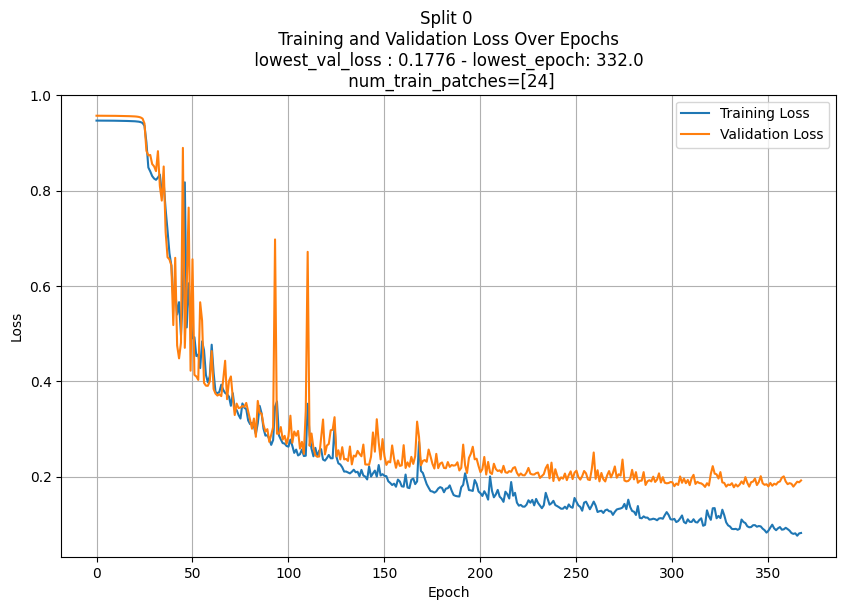


========== PLOTTING BEST_CHECKPOINT (EPOCH) VALIDATION RESULTS ==========
========== GROUND TRUTH VS PREDICTIONS ==========



/tmp/ipykernel_1082210/3107027896.py:258: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Validation results plot for split 0 saved at: executions/unet/tuning-train-test/id=123/train_test_split_0/validation_results_split_0.png


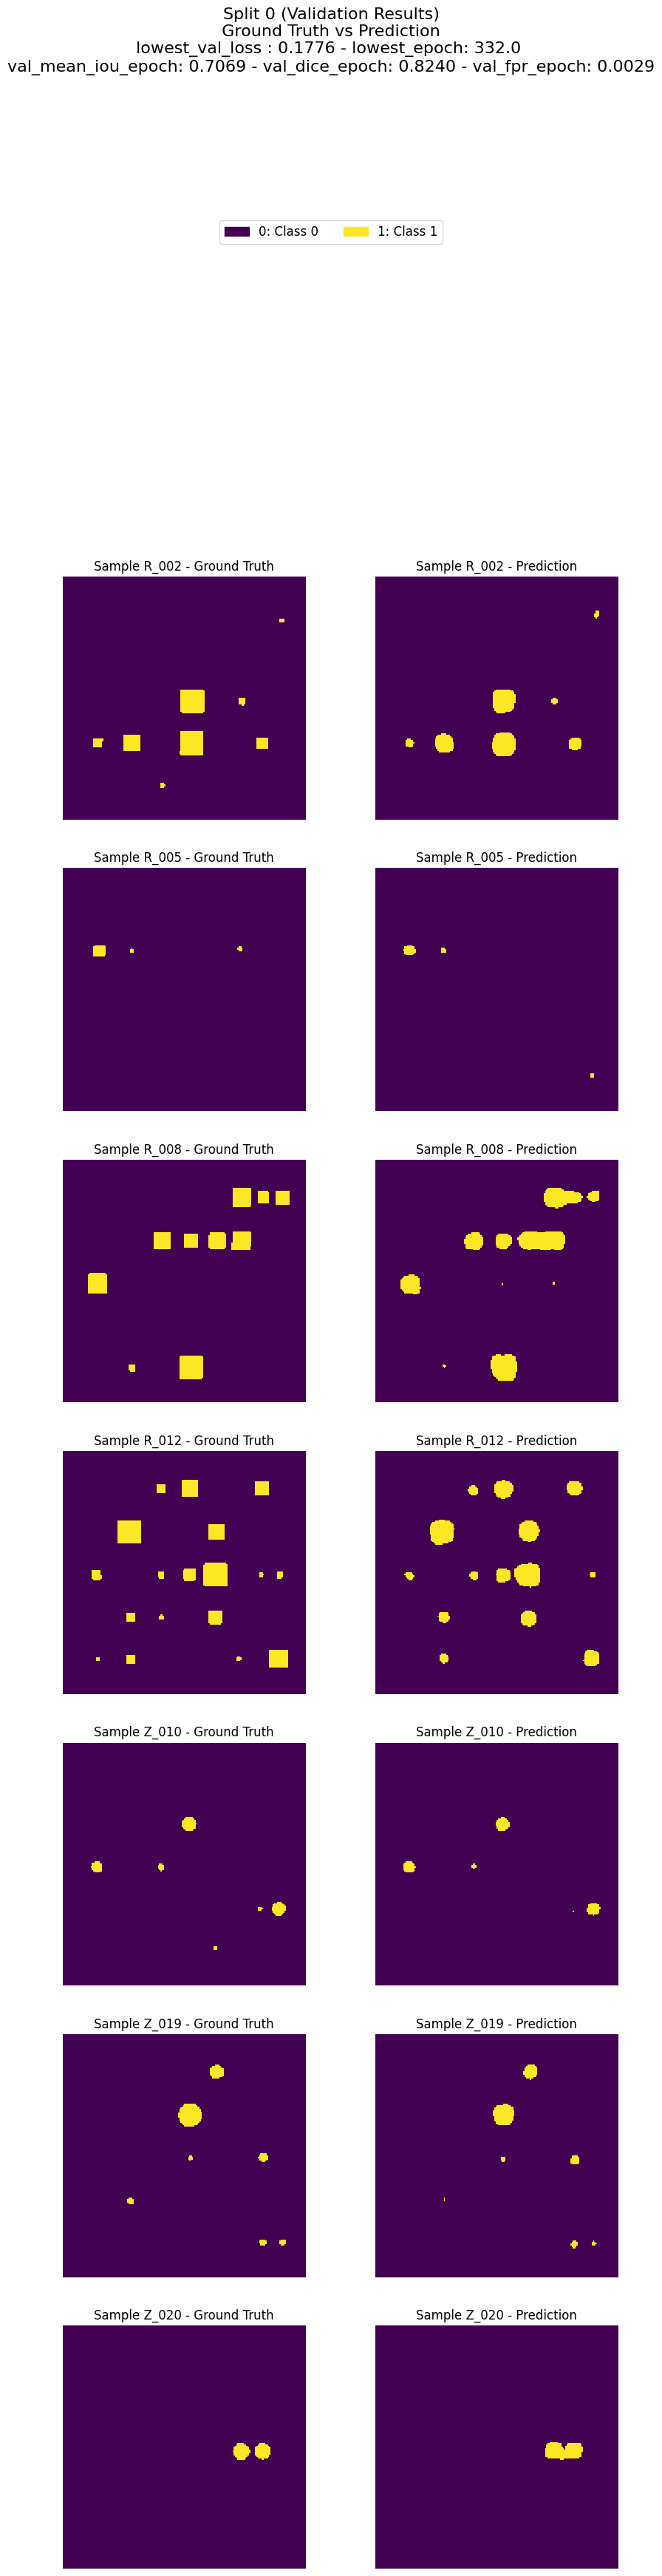


========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_006', 'R_011', 'R_013', 'Z_006', 'Z_008', 'Z_013', 'Z_016'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_006 ...

R_006 loaded

Processing & loading sample R_011 ...

R_011 loaded

Processing & loading sample R_013 ...

R_013 loaded

Processing & loading sample Z_006 ...

Z_006 loaded

Processing & loading sample Z_008 ...

Z_008 loaded

Processing & loading sample Z_013 ...

Z_013 loaded

Processing & loading sample Z_016 ...

Z_016 loaded

The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

==> DATA PREPOCESSING AND LOADING FINISHED


========== TESTING STARTS ==========

Found checkpoint: executions/unet/tuning-train-test/id=123/train_test_split_0/best-checkpoint-epoch=332-val_loss=0.18.ckpt


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

Starting testing epoch...
==> (TESTING) Average Dice Loss (include_background=[False]): 0.180485

==> (TESTING) Average Mean IoU (include_background=[False]): 0.697971

==> (TESTING) Average Dice Coefficient (include_background=[False]): 0.820096

==> (TESTING) Average FPR (include_background=[False]): 0.005611
Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.8200955986976624
     test_fpr_epoch        0.005610563792288303
     test_loss_epoch        0.18048469722270966
   test_mean_iou_epoch      0.6979712843894958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing completed in 0h 0m 2s

========== TESTING FINISHED ========

/tmp/ipykernel_1082210/3107027896.py:404: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Testing results plot for split 0 saved at: executions/unet/tuning-train-test/id=123/train_test_split_0/testing_results_split_0.png


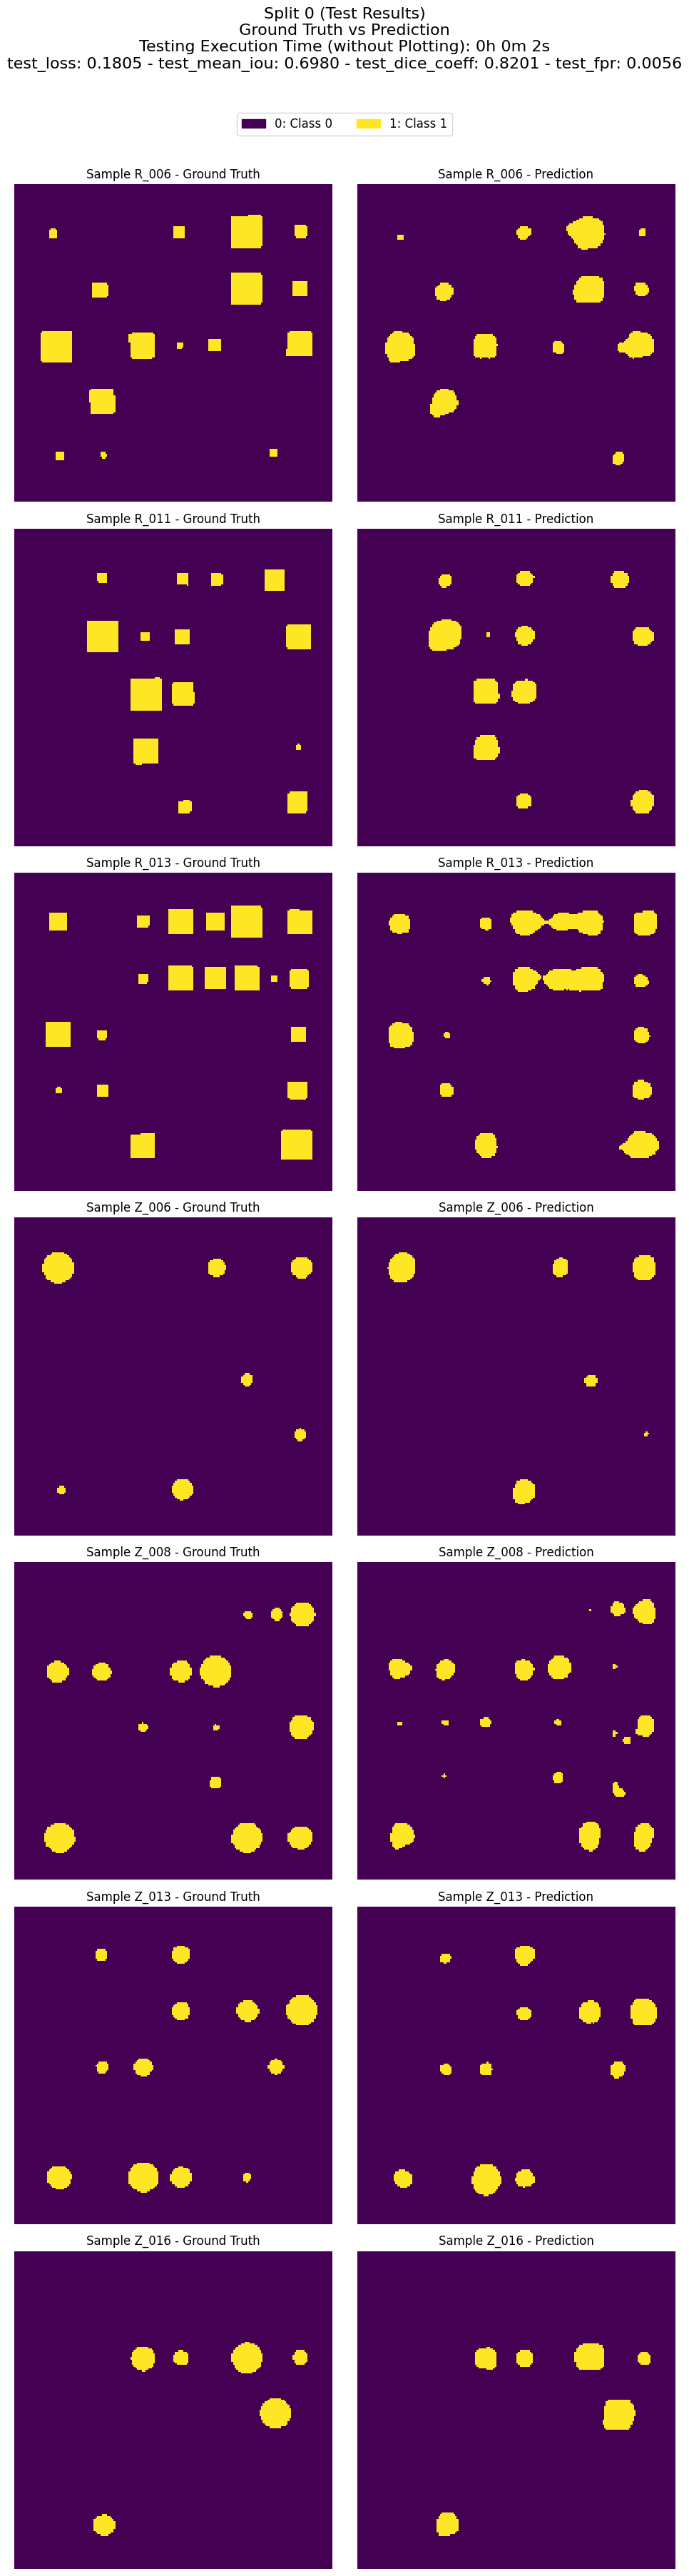

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



==================== TRAIN/TEST SPLIT: 1 ====================


===============> TRAINING DATA PREPARATION

 SAMPLES: dict_keys(['R_003', 'R_004', 'R_006', 'R_007', 'R_010', 'R_011', 'R_013', 'R_014', 'R_016', 'R_017', 'R_018', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_011', 'Z_012', 'Z_013', 'Z_016', 'Z_017', 'Z_018'])



==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_003 ...

R_003 loaded

Processing & loading sample R_004 ...

R_004 loaded

Processing & loading sample R_006 ...

R_006 loaded

Processing & loading sample R_007 ...

R_007 loaded

Processing & loading sample R_010 ...

R_010 loaded

Processing & loading sample R_011 ...

R_011 loaded

Processing & loading sample R_013 ...

R_013 loaded

Processing & loading sample R_014 ...

R_014 loaded

Processing & loading sample R_016 ...

R_016 loaded

Processing & loading sample R_017 ...

R_017 loaded

Processing & loading sample R_018 ...

R_018 loaded

Processing & loa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | UNet_VGG11 | 25.4 M | train
1 | loss_fn | DiceLoss   | 0      | train
-----------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.474   Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.970215

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.015788

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.030775

==> (VALIDATION) Average FPR (include_background=[False]): 0.990247



Training: |                                                                                                   …

Starting training epoch 0...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958104

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.021996

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042422

==> (VALIDATION) Average FPR (include_background=[False]): 0.986421

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944782
Finished training epoch 0

Starting training epoch 1...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958100

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022003

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042436

==> (VALIDATION) Average FPR (include_background=[False]): 0.986469

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944780
Finished training epoch 1

Starting training epoch 2...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958089

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022013

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042454

==> (VALIDATION) Average FPR (include_background=[False]): 0.986572

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944772
Finished training epoch 2

Starting training epoch 3...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958075

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022035

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042495

==> (VALIDATION) Average FPR (include_background=[False]): 0.986694

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944758
Finished training epoch 3

Starting training epoch 4...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958057

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022063

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042548

==> (VALIDATION) Average FPR (include_background=[False]): 0.986876

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944739
Finished training epoch 4

Starting training epoch 5...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958035

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022094

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042608

==> (VALIDATION) Average FPR (include_background=[False]): 0.986961

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944714
Finished training epoch 5

Starting training epoch 6...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958006

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022110

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042640

==> (VALIDATION) Average FPR (include_background=[False]): 0.987453

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944685
Finished training epoch 6

Starting training epoch 7...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957971

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022169

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042750

==> (VALIDATION) Average FPR (include_background=[False]): 0.987818

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944648
Finished training epoch 7

Starting training epoch 8...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957932

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022241

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042888

==> (VALIDATION) Average FPR (include_background=[False]): 0.988062

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944607
Finished training epoch 8

Starting training epoch 9...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957891

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022287

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.042976

==> (VALIDATION) Average FPR (include_background=[False]): 0.988217

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944558
Finished training epoch 9

Starting training epoch 10...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957843

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022343

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.043081

==> (VALIDATION) Average FPR (include_background=[False]): 0.988399

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944505
Finished training epoch 10

Starting training epoch 11...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957786

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022400

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.043188

==> (VALIDATION) Average FPR (include_background=[False]): 0.988323

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944447
Finished training epoch 11

Starting training epoch 12...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957726

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022484

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.043347

==> (VALIDATION) Average FPR (include_background=[False]): 0.987415

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944379
Finished training epoch 12

Starting training epoch 13...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957662

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022673

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.043702

==> (VALIDATION) Average FPR (include_background=[False]): 0.970853

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944305
Finished training epoch 13

Starting training epoch 14...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957597

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.023815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.045846

==> (VALIDATION) Average FPR (include_background=[False]): 0.873887

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944220
Finished training epoch 14

Starting training epoch 15...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957518

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.030787

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.058656

==> (VALIDATION) Average FPR (include_background=[False]): 0.611230

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944135
Finished training epoch 15

Starting training epoch 16...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957432

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.049190

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.090975

==> (VALIDATION) Average FPR (include_background=[False]): 0.326689

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.944046
Finished training epoch 16

Starting training epoch 17...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957352

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.064134

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.115898

==> (VALIDATION) Average FPR (include_background=[False]): 0.206465

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943952
Finished training epoch 17

Starting training epoch 18...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957273

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.072663

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130411

==> (VALIDATION) Average FPR (include_background=[False]): 0.151643

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943861
Finished training epoch 18

Starting training epoch 19...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957191

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.078939

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.140979

==> (VALIDATION) Average FPR (include_background=[False]): 0.111743

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943765
Finished training epoch 19

Starting training epoch 20...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957097

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.083927

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.148978

==> (VALIDATION) Average FPR (include_background=[False]): 0.087581

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943665
Finished training epoch 20

Starting training epoch 21...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956988

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.088854

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.156353

==> (VALIDATION) Average FPR (include_background=[False]): 0.073580

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943551
Finished training epoch 21

Starting training epoch 22...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956858

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.092918

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.162788

==> (VALIDATION) Average FPR (include_background=[False]): 0.067050

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943412
Finished training epoch 22

Starting training epoch 23...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956651

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.103635

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.180078

==> (VALIDATION) Average FPR (include_background=[False]): 0.064734

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.943237
Finished training epoch 23

Starting training epoch 24...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956281

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.104984

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.183189

==> (VALIDATION) Average FPR (include_background=[False]): 0.099801

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.942927
Finished training epoch 24

Starting training epoch 25...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955216

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.027443

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.052555

==> (VALIDATION) Average FPR (include_background=[False]): 0.814857

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.942148
Finished training epoch 25

Starting training epoch 26...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.952083

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022958

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.044242

==> (VALIDATION) Average FPR (include_background=[False]): 0.989509

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939428
Finished training epoch 26

Starting training epoch 27...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.949097

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.026917

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.051556

==> (VALIDATION) Average FPR (include_background=[False]): 0.838676

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935958
Finished training epoch 27

Starting training epoch 28...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.898846

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.064082

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.116704

==> (VALIDATION) Average FPR (include_background=[False]): 0.224934

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.913386
Finished training epoch 28

Starting training epoch 29...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.874581

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.070859

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.128438

==> (VALIDATION) Average FPR (include_background=[False]): 0.170821

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.852620
Finished training epoch 29

Starting training epoch 30...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.867533

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.074462

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.134817

==> (VALIDATION) Average FPR (include_background=[False]): 0.125594

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.837678
Finished training epoch 30

Starting training epoch 31...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.872467

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.070987

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130688

==> (VALIDATION) Average FPR (include_background=[False]): 0.039277

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.832621
Finished training epoch 31

Starting training epoch 32...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.864157

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.075503

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137178

==> (VALIDATION) Average FPR (include_background=[False]): 0.079955

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.838778
Finished training epoch 32

Starting training epoch 33...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.868574

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.073131

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.132144

==> (VALIDATION) Average FPR (include_background=[False]): 0.168423

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.830444
Finished training epoch 33

Starting training epoch 34...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.863292

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076021

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137056

==> (VALIDATION) Average FPR (include_background=[False]): 0.136310

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.826971
Finished training epoch 34

Starting training epoch 35...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.862609

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076098

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.138119

==> (VALIDATION) Average FPR (include_background=[False]): 0.078030

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.824494
Finished training epoch 35

Starting training epoch 36...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.864338

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.075597

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137823

==> (VALIDATION) Average FPR (include_background=[False]): 0.063341

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.820572
Finished training epoch 36

Starting training epoch 37...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.864011

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076113

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.136903

==> (VALIDATION) Average FPR (include_background=[False]): 0.157712

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.848451
Finished training epoch 37

Starting training epoch 38...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.875553

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.069136

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.125129

==> (VALIDATION) Average FPR (include_background=[False]): 0.219649

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.832220
Finished training epoch 38

Starting training epoch 39...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.856833

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.080863

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.145137

==> (VALIDATION) Average FPR (include_background=[False]): 0.109976

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.824146
Finished training epoch 39

Starting training epoch 40...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.859051

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.079412

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.142198

==> (VALIDATION) Average FPR (include_background=[False]): 0.139093

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.815263
Finished training epoch 40

Starting training epoch 41...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.854039

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.083329

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.150001

==> (VALIDATION) Average FPR (include_background=[False]): 0.062545

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.812817
Finished training epoch 41

Starting training epoch 42...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.851761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.084873

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.151519

==> (VALIDATION) Average FPR (include_background=[False]): 0.103721

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.824744
Finished training epoch 42

Starting training epoch 43...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.845229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.089672

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.159546

==> (VALIDATION) Average FPR (include_background=[False]): 0.085478

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.811301
Finished training epoch 43

Starting training epoch 44...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.850822

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086113

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.152623

==> (VALIDATION) Average FPR (include_background=[False]): 0.154315

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.807967
Finished training epoch 44

Starting training epoch 45...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.869603

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.073534

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.132248

==> (VALIDATION) Average FPR (include_background=[False]): 0.217114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.852963
Finished training epoch 45

Starting training epoch 46...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.853352

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.084036

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.149428

==> (VALIDATION) Average FPR (include_background=[False]): 0.161955

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.789069
Finished training epoch 46

Starting training epoch 47...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.820292

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.106742

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.185852

==> (VALIDATION) Average FPR (include_background=[False]): 0.095447

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.788371
Finished training epoch 47

Starting training epoch 48...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.837064

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.094536

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.165999

==> (VALIDATION) Average FPR (include_background=[False]): 0.151566

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.774509
Finished training epoch 48

Starting training epoch 49...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.703658

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.237061

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.370664

==> (VALIDATION) Average FPR (include_background=[False]): 0.025360

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.691126
Finished training epoch 49

Starting training epoch 50...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.621169

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.272100

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.405146

==> (VALIDATION) Average FPR (include_background=[False]): 0.001166

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.751682
Finished training epoch 50

Starting training epoch 51...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.589661

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.284006

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.418973

==> (VALIDATION) Average FPR (include_background=[False]): 0.001110

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.593047
Finished training epoch 51

Starting training epoch 52...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.643331

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.242956

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.363296

==> (VALIDATION) Average FPR (include_background=[False]): 0.000452

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.590159
Finished training epoch 52

Starting training epoch 53...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.514588

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.361789

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.501112

==> (VALIDATION) Average FPR (include_background=[False]): 0.002000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.524906
Finished training epoch 53

Starting training epoch 54...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.597112

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.283903

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.415472

==> (VALIDATION) Average FPR (include_background=[False]): 0.000629

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.599112
Finished training epoch 54

Starting training epoch 55...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.478378

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.394629

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.535781

==> (VALIDATION) Average FPR (include_background=[False]): 0.002808

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.502099
Finished training epoch 55

Starting training epoch 56...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.432404

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.445415

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.585868

==> (VALIDATION) Average FPR (include_background=[False]): 0.005301

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.534141
Finished training epoch 56

Starting training epoch 57...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.517762

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.350281

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.490102

==> (VALIDATION) Average FPR (include_background=[False]): 0.001664

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.500501
Finished training epoch 57

Starting training epoch 58...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.627595

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.254340

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.375835

==> (VALIDATION) Average FPR (include_background=[False]): 0.000406

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.525373
Finished training epoch 58

Starting training epoch 59...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.445608

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.432797

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.572562

==> (VALIDATION) Average FPR (include_background=[False]): 0.003362

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.485924
Finished training epoch 59

Starting training epoch 60...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.416210

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.458857

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.597100

==> (VALIDATION) Average FPR (include_background=[False]): 0.004571

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.450085
Finished training epoch 60

Starting training epoch 61...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.638293

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.246773

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.364697

==> (VALIDATION) Average FPR (include_background=[False]): 0.000369

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.473741
Finished training epoch 61

Starting training epoch 62...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.432173

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.439053

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.578869

==> (VALIDATION) Average FPR (include_background=[False]): 0.003361

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.472385
Finished training epoch 62

Starting training epoch 63...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.389946

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.462467

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.604689

==> (VALIDATION) Average FPR (include_background=[False]): 0.008978

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.443800
Finished training epoch 63

Starting training epoch 64...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.406612

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.463741

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.600982

==> (VALIDATION) Average FPR (include_background=[False]): 0.004070

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.411942
Finished training epoch 64

Starting training epoch 65...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.442102

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.429064

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.568543

==> (VALIDATION) Average FPR (include_background=[False]): 0.002231

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.445847
Finished training epoch 65

Starting training epoch 66...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.830809

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.096727

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.168715

==> (VALIDATION) Average FPR (include_background=[False]): 0.200087

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.771265
Finished training epoch 66

Starting training epoch 67...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.398011

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.489377

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.622760

==> (VALIDATION) Average FPR (include_background=[False]): 0.005953

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.539919
Finished training epoch 67

Starting training epoch 68...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.394186

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.483363

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.617652

==> (VALIDATION) Average FPR (include_background=[False]): 0.005849

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.457606
Finished training epoch 68

Starting training epoch 69...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.393326

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.483741

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.617826

==> (VALIDATION) Average FPR (include_background=[False]): 0.004563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.419478
Finished training epoch 69

Starting training epoch 70...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.436596

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.458355

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.619189

==> (VALIDATION) Average FPR (include_background=[False]): 0.015252

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.392584
Finished training epoch 70

Starting training epoch 71...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.424535

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.443907

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.582570

==> (VALIDATION) Average FPR (include_background=[False]): 0.002275

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.433050
Finished training epoch 71

Starting training epoch 72...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.380382

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.490555

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.623491

==> (VALIDATION) Average FPR (include_background=[False]): 0.006523

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.395528
Finished training epoch 72

Starting training epoch 73...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.391862

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.480061

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.614286

==> (VALIDATION) Average FPR (include_background=[False]): 0.003125

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.366466
Finished training epoch 73

Starting training epoch 74...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.383257

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.488217

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.621429

==> (VALIDATION) Average FPR (include_background=[False]): 0.003853

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.380267
Finished training epoch 74

Starting training epoch 75...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.375921

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.500903

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.631778

==> (VALIDATION) Average FPR (include_background=[False]): 0.004055

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.424228
Finished training epoch 75

Starting training epoch 76...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.438113

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.431045

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.570166

==> (VALIDATION) Average FPR (include_background=[False]): 0.001576

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.396952
Finished training epoch 76

Starting training epoch 77...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.395561

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.477345

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.611490

==> (VALIDATION) Average FPR (include_background=[False]): 0.002455

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.401331
Finished training epoch 77

Starting training epoch 78...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.370911

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.511394

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.640249

==> (VALIDATION) Average FPR (include_background=[False]): 0.004146

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.421544
Finished training epoch 78

Starting training epoch 79...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.372793

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.502527

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.633148

==> (VALIDATION) Average FPR (include_background=[False]): 0.005350

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.372607
Finished training epoch 79

Starting training epoch 80...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.370944

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.494706

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.626823

==> (VALIDATION) Average FPR (include_background=[False]): 0.006633

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.350331
Finished training epoch 80

Starting training epoch 81...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.363626

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.514073

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.641971

==> (VALIDATION) Average FPR (include_background=[False]): 0.003744

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.338944
Finished training epoch 81

Starting training epoch 82...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.355269

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.515755

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.643345

==> (VALIDATION) Average FPR (include_background=[False]): 0.005217

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.325879
Finished training epoch 82

Starting training epoch 83...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336066

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.524819

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.666430

==> (VALIDATION) Average FPR (include_background=[False]): 0.006065

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.324930
Finished training epoch 83

Starting training epoch 84...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.374145

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.497307

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.628179

==> (VALIDATION) Average FPR (include_background=[False]): 0.002794

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.319929
Finished training epoch 84

Starting training epoch 85...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.356807

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.523985

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.649619

==> (VALIDATION) Average FPR (include_background=[False]): 0.003871

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.337115
Finished training epoch 85

Starting training epoch 86...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.427094

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.447139

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.601947

==> (VALIDATION) Average FPR (include_background=[False]): 0.018022

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.307872
Finished training epoch 86

Starting training epoch 87...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.354348

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.524462

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.650374

==> (VALIDATION) Average FPR (include_background=[False]): 0.004065

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.352554
Finished training epoch 87

Starting training epoch 88...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.440803

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.434917

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.589459

==> (VALIDATION) Average FPR (include_background=[False]): 0.019861

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.307851
Finished training epoch 88

Starting training epoch 89...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311643

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.544302

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.691988

==> (VALIDATION) Average FPR (include_background=[False]): 0.008324

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.329925
Finished training epoch 89

Starting training epoch 90...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.314652

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.545709

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.696628

==> (VALIDATION) Average FPR (include_background=[False]): 0.009816

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.292220
Finished training epoch 90

Starting training epoch 91...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.341167

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.522598

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.675264

==> (VALIDATION) Average FPR (include_background=[False]): 0.012738

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.292642
Finished training epoch 91

Starting training epoch 92...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.366855

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.507909

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.637044

==> (VALIDATION) Average FPR (include_background=[False]): 0.002285

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.314671
Finished training epoch 92

Starting training epoch 93...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.315466

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.544416

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.687051

==> (VALIDATION) Average FPR (include_background=[False]): 0.007083

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.299196
Finished training epoch 93

Starting training epoch 94...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336452

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.538775

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.661388

==> (VALIDATION) Average FPR (include_background=[False]): 0.004513

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.313102
Finished training epoch 94

Starting training epoch 95...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.322772

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.541488

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.691494

==> (VALIDATION) Average FPR (include_background=[False]): 0.010441

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.290512
Finished training epoch 95

Starting training epoch 96...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.296005

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.558311

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.708607

==> (VALIDATION) Average FPR (include_background=[False]): 0.009390

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.302043
Finished training epoch 96

Starting training epoch 97...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.424418

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.450237

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.601424

==> (VALIDATION) Average FPR (include_background=[False]): 0.019177

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.270463
Finished training epoch 97

Starting training epoch 98...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318091

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.547611

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.681736

==> (VALIDATION) Average FPR (include_background=[False]): 0.005765

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.320361
Finished training epoch 98

Starting training epoch 99...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.368956

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.504666

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.634583

==> (VALIDATION) Average FPR (include_background=[False]): 0.001900

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.345681
Finished training epoch 99

Starting training epoch 100...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336403

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.547160

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.667575

==> (VALIDATION) Average FPR (include_background=[False]): 0.004536

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.304854
Finished training epoch 100

Starting training epoch 101...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.350811

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.528334

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.653258

==> (VALIDATION) Average FPR (include_background=[False]): 0.002598

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.286499
Finished training epoch 101

Starting training epoch 102...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.296636

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.567658

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.710680

==> (VALIDATION) Average FPR (include_background=[False]): 0.006251

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.264481
Finished training epoch 102

Starting training epoch 103...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.289960

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.569790

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.710488

==> (VALIDATION) Average FPR (include_background=[False]): 0.006641

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.261837
Finished training epoch 103

Starting training epoch 104...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.283376

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.577624

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.718022

==> (VALIDATION) Average FPR (include_background=[False]): 0.005623

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.256042
Finished training epoch 104

Starting training epoch 105...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.269915

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.593923

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.734901

==> (VALIDATION) Average FPR (include_background=[False]): 0.006084

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.253853
Finished training epoch 105

Starting training epoch 106...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.268808

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.594051

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.739150

==> (VALIDATION) Average FPR (include_background=[False]): 0.007326

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.251147
Finished training epoch 106

Starting training epoch 107...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.290229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.576445

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.712492

==> (VALIDATION) Average FPR (include_background=[False]): 0.004745

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.243194
Finished training epoch 107

Starting training epoch 108...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.262016

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.600301

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.741286

==> (VALIDATION) Average FPR (include_background=[False]): 0.005818

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.267906
Finished training epoch 108

Starting training epoch 109...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.277292

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582155

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728194

==> (VALIDATION) Average FPR (include_background=[False]): 0.007872

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.244210
Finished training epoch 109

Starting training epoch 110...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.290642

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.577029

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.722750

==> (VALIDATION) Average FPR (include_background=[False]): 0.009065

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.235078
Finished training epoch 110

Starting training epoch 111...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.268026

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596133

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.736538

==> (VALIDATION) Average FPR (include_background=[False]): 0.006167

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.242510
Finished training epoch 111

Starting training epoch 112...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263085

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.601792

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742355

==> (VALIDATION) Average FPR (include_background=[False]): 0.005783

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.240817
Finished training epoch 112

Starting training epoch 113...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.343863

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.532477

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.656440

==> (VALIDATION) Average FPR (include_background=[False]): 0.002554

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.258406
Finished training epoch 113

Starting training epoch 114...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.320057

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.557239

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.676809

==> (VALIDATION) Average FPR (include_background=[False]): 0.003474

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.259580
Finished training epoch 114

Starting training epoch 115...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.266524

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596211

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.735432

==> (VALIDATION) Average FPR (include_background=[False]): 0.004738

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.242123
Finished training epoch 115

Starting training epoch 116...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263695

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.605109

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.746039

==> (VALIDATION) Average FPR (include_background=[False]): 0.007344

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.227861
Finished training epoch 116

Starting training epoch 117...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.255186

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.603553

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.744792

==> (VALIDATION) Average FPR (include_background=[False]): 0.006691

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.229285
Finished training epoch 117

Starting training epoch 118...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.303678

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.566822

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.696302

==> (VALIDATION) Average FPR (include_background=[False]): 0.002847

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.219391
Finished training epoch 118

Starting training epoch 119...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.323467

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.560944

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.677854

==> (VALIDATION) Average FPR (include_background=[False]): 0.002868

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.232347
Finished training epoch 119

Starting training epoch 120...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.250659

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.617843

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.753892

==> (VALIDATION) Average FPR (include_background=[False]): 0.004177

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.226921
Finished training epoch 120

Starting training epoch 121...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.339754

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.511471

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.665168

==> (VALIDATION) Average FPR (include_background=[False]): 0.013953

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.328386
Finished training epoch 121

Starting training epoch 122...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.282274

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573636

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.718872

==> (VALIDATION) Average FPR (include_background=[False]): 0.008159

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.264845
Finished training epoch 122

Starting training epoch 123...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.290733

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.577012

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.711636

==> (VALIDATION) Average FPR (include_background=[False]): 0.005972

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.240900
Finished training epoch 123

Starting training epoch 124...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.254351

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.611911

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.750379

==> (VALIDATION) Average FPR (include_background=[False]): 0.005182

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.227655
Finished training epoch 124

Starting training epoch 125...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.252541

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.610104

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.748722

==> (VALIDATION) Average FPR (include_background=[False]): 0.005835

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.226837
Finished training epoch 125

Starting training epoch 126...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.254848

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.610358

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745934

==> (VALIDATION) Average FPR (include_background=[False]): 0.003649

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.213704
Finished training epoch 126

Starting training epoch 127...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.248981

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615043

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754017

==> (VALIDATION) Average FPR (include_background=[False]): 0.005650

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.225689
Finished training epoch 127

Starting training epoch 128...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.259138

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609633

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742514

==> (VALIDATION) Average FPR (include_background=[False]): 0.003962

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.218069
Finished training epoch 128

Starting training epoch 129...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.273433

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596472

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728749

==> (VALIDATION) Average FPR (include_background=[False]): 0.004722

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.215544
Finished training epoch 129

Starting training epoch 130...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.264358

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.602050

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.740541

==> (VALIDATION) Average FPR (include_background=[False]): 0.007513

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.212301
Finished training epoch 130

Starting training epoch 131...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.253010

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.614838

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.748778

==> (VALIDATION) Average FPR (include_background=[False]): 0.004436

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210917
Finished training epoch 131

Starting training epoch 132...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237538

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628740

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766337

==> (VALIDATION) Average FPR (include_background=[False]): 0.005679

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.198069
Finished training epoch 132

Starting training epoch 133...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237970

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628831

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765058

==> (VALIDATION) Average FPR (include_background=[False]): 0.005284

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199598
Finished training epoch 133

Starting training epoch 134...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.261149

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609560

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.740526

==> (VALIDATION) Average FPR (include_background=[False]): 0.003146

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199310
Finished training epoch 134

Starting training epoch 135...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.270862

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.594379

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.732065

==> (VALIDATION) Average FPR (include_background=[False]): 0.004789

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.216178
Finished training epoch 135

Starting training epoch 136...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244219

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.616385

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757506

==> (VALIDATION) Average FPR (include_background=[False]): 0.007250

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238089
Finished training epoch 136

Starting training epoch 137...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249471

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.618072

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.750756

==> (VALIDATION) Average FPR (include_background=[False]): 0.004154

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.219078
Finished training epoch 137

Starting training epoch 138...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.265359

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.600352

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.741255

==> (VALIDATION) Average FPR (include_background=[False]): 0.007751

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.205598
Finished training epoch 138

Starting training epoch 139...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232884

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631170

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769007

==> (VALIDATION) Average FPR (include_background=[False]): 0.005200

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.197613
Finished training epoch 139

Starting training epoch 140...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219941

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645768

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781608

==> (VALIDATION) Average FPR (include_background=[False]): 0.004320

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.195626
Finished training epoch 140

Starting training epoch 141...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242462

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625305

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759528

==> (VALIDATION) Average FPR (include_background=[False]): 0.004090

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190527
Finished training epoch 141

Starting training epoch 142...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.258693

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.603756

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745314

==> (VALIDATION) Average FPR (include_background=[False]): 0.007234

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200478
Finished training epoch 142

Starting training epoch 143...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.277741

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586954

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.727481

==> (VALIDATION) Average FPR (include_background=[False]): 0.008636

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.204120
Finished training epoch 143

Starting training epoch 144...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.313657

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.569527

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.688833

==> (VALIDATION) Average FPR (include_background=[False]): 0.002340

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.225793
Finished training epoch 144

Starting training epoch 145...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241356

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623049

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760404

==> (VALIDATION) Average FPR (include_background=[False]): 0.005619

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.208560
Finished training epoch 145

Starting training epoch 146...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.317577

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.569681

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.684321

==> (VALIDATION) Average FPR (include_background=[False]): 0.002698

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.213940
Finished training epoch 146

Starting training epoch 147...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.269240

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.594103

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.729757

==> (VALIDATION) Average FPR (include_background=[False]): 0.005707

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.213925
Finished training epoch 147

Starting training epoch 148...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243649

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.616320

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.750181

==> (VALIDATION) Average FPR (include_background=[False]): 0.004421

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.197421
Finished training epoch 148

Starting training epoch 149...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239986

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626116

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.762093

==> (VALIDATION) Average FPR (include_background=[False]): 0.005229

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188786
Finished training epoch 149

Starting training epoch 150...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.269053

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.602106

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.729719

==> (VALIDATION) Average FPR (include_background=[False]): 0.003140

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.220086
Finished training epoch 150

Starting training epoch 151...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236824

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628940

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765657

==> (VALIDATION) Average FPR (include_background=[False]): 0.005548

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.198888
Finished training epoch 151

Starting training epoch 152...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.250769

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.618413

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.750729

==> (VALIDATION) Average FPR (include_background=[False]): 0.002970

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.208295
Finished training epoch 152

Starting training epoch 153...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.240836

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626026

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758152

==> (VALIDATION) Average FPR (include_background=[False]): 0.004357

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.186866
Finished training epoch 153

Starting training epoch 154...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.296578

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.575806

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.700588

==> (VALIDATION) Average FPR (include_background=[False]): 0.002266

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199238
Finished training epoch 154

Starting training epoch 155...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234111

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633622

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768523

==> (VALIDATION) Average FPR (include_background=[False]): 0.003293

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190703
Finished training epoch 155

Starting training epoch 156...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.240147

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.629321

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765843

==> (VALIDATION) Average FPR (include_background=[False]): 0.005913

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185867
Finished training epoch 156

Starting training epoch 157...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.270408

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.597662

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.730682

==> (VALIDATION) Average FPR (include_background=[False]): 0.002210

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.186096
Finished training epoch 157

Starting training epoch 158...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231014

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635454

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769774

==> (VALIDATION) Average FPR (include_background=[False]): 0.003487

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.178274
Finished training epoch 158

Starting training epoch 159...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217148

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649784

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783826

==> (VALIDATION) Average FPR (include_background=[False]): 0.004890

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183690
Finished training epoch 159

Starting training epoch 160...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.259165

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.614656

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.743663

==> (VALIDATION) Average FPR (include_background=[False]): 0.003037

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184971
Finished training epoch 160

Starting training epoch 161...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.248048

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.613710

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.753441

==> (VALIDATION) Average FPR (include_background=[False]): 0.006977

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.227440
Finished training epoch 161

Starting training epoch 162...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628288

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763360

==> (VALIDATION) Average FPR (include_background=[False]): 0.005294

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.187787
Finished training epoch 162

Starting training epoch 163...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223907

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.641239

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775206

==> (VALIDATION) Average FPR (include_background=[False]): 0.004590

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176187
Finished training epoch 163

Starting training epoch 164...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.299536

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.576170

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.699399

==> (VALIDATION) Average FPR (include_background=[False]): 0.002044

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.202036
Finished training epoch 164

Starting training epoch 165...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229255

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638496

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771435

==> (VALIDATION) Average FPR (include_background=[False]): 0.004536

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192546
Finished training epoch 165

Starting training epoch 166...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223443

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648636

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779747

==> (VALIDATION) Average FPR (include_background=[False]): 0.003372

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183847
Finished training epoch 166

Starting training epoch 167...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229013

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640470

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773339

==> (VALIDATION) Average FPR (include_background=[False]): 0.003280

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174402
Finished training epoch 167

Starting training epoch 168...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219397

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646681

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781868

==> (VALIDATION) Average FPR (include_background=[False]): 0.005631

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180954
Finished training epoch 168

Starting training epoch 169...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218360

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646876

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780996

==> (VALIDATION) Average FPR (include_background=[False]): 0.004022

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171315
Finished training epoch 169

Starting training epoch 170...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213757

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654202

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788692

==> (VALIDATION) Average FPR (include_background=[False]): 0.005647

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191746
Finished training epoch 170

Starting training epoch 171...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231230

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636334

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768936

==> (VALIDATION) Average FPR (include_background=[False]): 0.003360

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175065
Finished training epoch 171

Starting training epoch 172...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.240957

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623216

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761771

==> (VALIDATION) Average FPR (include_background=[False]): 0.006461

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185001
Finished training epoch 172

Starting training epoch 173...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220943

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649688

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781937

==> (VALIDATION) Average FPR (include_background=[False]): 0.004229

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.172463
Finished training epoch 173

Starting training epoch 174...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220859

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647307

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780081

==> (VALIDATION) Average FPR (include_background=[False]): 0.004336

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164368
Finished training epoch 174

Starting training epoch 175...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249061

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.620840

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.751295

==> (VALIDATION) Average FPR (include_background=[False]): 0.003046

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176678
Finished training epoch 175

Starting training epoch 176...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216314

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649055

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784187

==> (VALIDATION) Average FPR (include_background=[False]): 0.005872

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188651
Finished training epoch 176

Starting training epoch 177...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234839

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636474

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768569

==> (VALIDATION) Average FPR (include_background=[False]): 0.003331

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.195334
Finished training epoch 177

Starting training epoch 178...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227945

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638795

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772318

==> (VALIDATION) Average FPR (include_background=[False]): 0.002680

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180543
Finished training epoch 178

Starting training epoch 179...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.238080

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630635

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763922

==> (VALIDATION) Average FPR (include_background=[False]): 0.002736

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177187
Finished training epoch 179

Starting training epoch 180...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.281865

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.579170

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.722539

==> (VALIDATION) Average FPR (include_background=[False]): 0.010028

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177571
Finished training epoch 180

Starting training epoch 181...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217256

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647504

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783021

==> (VALIDATION) Average FPR (include_background=[False]): 0.005849

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180663
Finished training epoch 181

Starting training epoch 182...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.297606

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.583190

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.703082

==> (VALIDATION) Average FPR (include_background=[False]): 0.001640

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180338
Finished training epoch 182

Starting training epoch 183...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208075

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661019

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792673

==> (VALIDATION) Average FPR (include_background=[False]): 0.004430

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166718
Finished training epoch 183

Starting training epoch 184...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216866

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651638

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783566

==> (VALIDATION) Average FPR (include_background=[False]): 0.003953

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171017
Finished training epoch 184

Starting training epoch 185...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210625

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656458

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790177

==> (VALIDATION) Average FPR (include_background=[False]): 0.005256

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168019
Finished training epoch 185

Starting training epoch 186...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225193

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643874

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776156

==> (VALIDATION) Average FPR (include_background=[False]): 0.003218

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162363
Finished training epoch 186

Starting training epoch 187...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224294

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644131

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775624

==> (VALIDATION) Average FPR (include_background=[False]): 0.003011

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167591
Finished training epoch 187

Starting training epoch 188...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234740

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632914

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765198

==> (VALIDATION) Average FPR (include_background=[False]): 0.002393

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170133
Finished training epoch 188

Starting training epoch 189...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214563

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650840

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784450

==> (VALIDATION) Average FPR (include_background=[False]): 0.004803

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.186304
Finished training epoch 189

Starting training epoch 190...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208610

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660004

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792290

==> (VALIDATION) Average FPR (include_background=[False]): 0.004602

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163044
Finished training epoch 190

Starting training epoch 191...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214561

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654459

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788081

==> (VALIDATION) Average FPR (include_background=[False]): 0.005729

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158982
Finished training epoch 191

Starting training epoch 192...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202383

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666105

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797937

==> (VALIDATION) Average FPR (include_background=[False]): 0.004415

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159210
Finished training epoch 192

Starting training epoch 193...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213914

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652993

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786189

==> (VALIDATION) Average FPR (include_background=[False]): 0.004802

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152403
Finished training epoch 193

Starting training epoch 194...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216155

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649016

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781318

==> (VALIDATION) Average FPR (include_background=[False]): 0.003741

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153463
Finished training epoch 194

Starting training epoch 195...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219553

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646002

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781044

==> (VALIDATION) Average FPR (include_background=[False]): 0.005966

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164781
Finished training epoch 195

Starting training epoch 196...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211966

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656798

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789292

==> (VALIDATION) Average FPR (include_background=[False]): 0.004257

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151203
Finished training epoch 196

Starting training epoch 197...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215587

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650267

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784061

==> (VALIDATION) Average FPR (include_background=[False]): 0.004995

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148594
Finished training epoch 197

Starting training epoch 198...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210656

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659869

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792111

==> (VALIDATION) Average FPR (include_background=[False]): 0.003989

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150708
Finished training epoch 198

Starting training epoch 199...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227538

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636485

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773919

==> (VALIDATION) Average FPR (include_background=[False]): 0.006962

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164852
Finished training epoch 199

Starting training epoch 200...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214971

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654635

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788090

==> (VALIDATION) Average FPR (include_background=[False]): 0.005351

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154665
Finished training epoch 200

Starting training epoch 201...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220692

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648062

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781052

==> (VALIDATION) Average FPR (include_background=[False]): 0.004909

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150134
Finished training epoch 201

Starting training epoch 202...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216885

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650878

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784167

==> (VALIDATION) Average FPR (include_background=[False]): 0.003388

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150022
Finished training epoch 202

Starting training epoch 203...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218441

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651191

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782500

==> (VALIDATION) Average FPR (include_background=[False]): 0.003304

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165933
Finished training epoch 203

Starting training epoch 204...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229717

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634742

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772789

==> (VALIDATION) Average FPR (include_background=[False]): 0.007102

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177981
Finished training epoch 204

Starting training epoch 205...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229866

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640733

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772248

==> (VALIDATION) Average FPR (include_background=[False]): 0.002679

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156991
Finished training epoch 205

Starting training epoch 206...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244902

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615796

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754495

==> (VALIDATION) Average FPR (include_background=[False]): 0.006224

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184529
Finished training epoch 206

Starting training epoch 207...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217413

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648302

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782504

==> (VALIDATION) Average FPR (include_background=[False]): 0.005151

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180683
Finished training epoch 207

Starting training epoch 208...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224584

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643315

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775390

==> (VALIDATION) Average FPR (include_background=[False]): 0.003243

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159508
Finished training epoch 208

Starting training epoch 209...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204870

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667217

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797284

==> (VALIDATION) Average FPR (include_background=[False]): 0.004066

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150482
Finished training epoch 209

Starting training epoch 210...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208425

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660138

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792784

==> (VALIDATION) Average FPR (include_background=[False]): 0.004754

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149402
Finished training epoch 210

Starting training epoch 211...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207020

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664110

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795705

==> (VALIDATION) Average FPR (include_background=[False]): 0.005287

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165286
Finished training epoch 211

Starting training epoch 212...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227030

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643450

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774836

==> (VALIDATION) Average FPR (include_background=[False]): 0.002422

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154761
Finished training epoch 212

Starting training epoch 213...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212728

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652719

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786166

==> (VALIDATION) Average FPR (include_background=[False]): 0.004537

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174641
Finished training epoch 213

Starting training epoch 214...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234113

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626386

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767274

==> (VALIDATION) Average FPR (include_background=[False]): 0.007760

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.281834
Finished training epoch 214

Starting training epoch 215...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230427

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633791

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770834

==> (VALIDATION) Average FPR (include_background=[False]): 0.006118

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199132
Finished training epoch 215

Starting training epoch 216...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214681

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656423

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788218

==> (VALIDATION) Average FPR (include_background=[False]): 0.004736

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184448
Finished training epoch 216

Starting training epoch 217...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263886

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.606905

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.736184

==> (VALIDATION) Average FPR (include_background=[False]): 0.001648

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155469
Finished training epoch 217

Starting training epoch 218...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225384

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642961

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776187

==> (VALIDATION) Average FPR (include_background=[False]): 0.005302

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167002
Finished training epoch 218

Starting training epoch 219...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208931

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661932

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793446

==> (VALIDATION) Average FPR (include_background=[False]): 0.004769

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156244
Finished training epoch 219

Starting training epoch 220...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211722

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655417

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787927

==> (VALIDATION) Average FPR (include_background=[False]): 0.003046

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150381
Finished training epoch 220

Starting training epoch 221...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212630

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655280

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787422

==> (VALIDATION) Average FPR (include_background=[False]): 0.004681

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145781
Finished training epoch 221

Starting training epoch 222...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204987

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662299

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794128

==> (VALIDATION) Average FPR (include_background=[False]): 0.003336

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159339
Finished training epoch 222

Starting training epoch 223...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209334

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659031

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791092

==> (VALIDATION) Average FPR (include_background=[False]): 0.005043

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147418
Finished training epoch 223

Starting training epoch 224...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211230

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656462

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788636

==> (VALIDATION) Average FPR (include_background=[False]): 0.003650

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.143006
Finished training epoch 224

Starting training epoch 225...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214208

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654287

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787442

==> (VALIDATION) Average FPR (include_background=[False]): 0.005164

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165136
Finished training epoch 225

Starting training epoch 226...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199935

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.673158

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802969

==> (VALIDATION) Average FPR (include_background=[False]): 0.004747

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158177
Finished training epoch 226

Starting training epoch 227...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244935

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.621187

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.755513

==> (VALIDATION) Average FPR (include_background=[False]): 0.002923

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169320
Finished training epoch 227

Starting training epoch 228...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210668

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656780

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788008

==> (VALIDATION) Average FPR (include_background=[False]): 0.003623

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162243
Finished training epoch 228

Starting training epoch 229...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208749

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658985

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790943

==> (VALIDATION) Average FPR (include_background=[False]): 0.003082

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144625
Finished training epoch 229

Starting training epoch 230...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214925

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655256

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787018

==> (VALIDATION) Average FPR (include_background=[False]): 0.004278

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.143930
Finished training epoch 230

Starting training epoch 231...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205560

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665769

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795786

==> (VALIDATION) Average FPR (include_background=[False]): 0.003521

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148437
Finished training epoch 231

Starting training epoch 232...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215127

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651775

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784992

==> (VALIDATION) Average FPR (include_background=[False]): 0.005202

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150855
Finished training epoch 232

Starting training epoch 233...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203511

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664986

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796464

==> (VALIDATION) Average FPR (include_background=[False]): 0.003430

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153298
Finished training epoch 233

Starting training epoch 234...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206667

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662986

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793892

==> (VALIDATION) Average FPR (include_background=[False]): 0.003768

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.143545
Finished training epoch 234

Starting training epoch 235...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206297

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663921

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794780

==> (VALIDATION) Average FPR (include_background=[False]): 0.003661

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147299
Finished training epoch 235

Starting training epoch 236...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665048

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795763

==> (VALIDATION) Average FPR (include_background=[False]): 0.004561

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140107
Finished training epoch 236

Starting training epoch 237...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228101

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637674

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770642

==> (VALIDATION) Average FPR (include_background=[False]): 0.002332

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141168
Finished training epoch 237

Starting training epoch 238...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209595

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657517

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789447

==> (VALIDATION) Average FPR (include_background=[False]): 0.003843

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.160112
Finished training epoch 238

Starting training epoch 239...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201457

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668258

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798483

==> (VALIDATION) Average FPR (include_background=[False]): 0.003451

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141520
Finished training epoch 239

Starting training epoch 240...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227428

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639669

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772790

==> (VALIDATION) Average FPR (include_background=[False]): 0.005388

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138162
Finished training epoch 240

Starting training epoch 241...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207889

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661380

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793093

==> (VALIDATION) Average FPR (include_background=[False]): 0.005259

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144894
Finished training epoch 241

Starting training epoch 242...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205991

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663565

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794688

==> (VALIDATION) Average FPR (include_background=[False]): 0.003867

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134212
Finished training epoch 242

Starting training epoch 243...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220387

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647977

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779892

==> (VALIDATION) Average FPR (include_background=[False]): 0.003276

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129249
Finished training epoch 243

Starting training epoch 244...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215511

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652008

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784498

==> (VALIDATION) Average FPR (include_background=[False]): 0.003069

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136845
Finished training epoch 244

Starting training epoch 245...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214022

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655792

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788028

==> (VALIDATION) Average FPR (include_background=[False]): 0.005358

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153413
Finished training epoch 245

Starting training epoch 246...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216874

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651228

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783448

==> (VALIDATION) Average FPR (include_background=[False]): 0.003223

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141436
Finished training epoch 246

Starting training epoch 247...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232407

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633663

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769437

==> (VALIDATION) Average FPR (include_background=[False]): 0.006785

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137918
Finished training epoch 247

Starting training epoch 248...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.296989

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586388

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.703273

==> (VALIDATION) Average FPR (include_background=[False]): 0.001609

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154977
Finished training epoch 248

Starting training epoch 249...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236162

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631901

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764006

==> (VALIDATION) Average FPR (include_background=[False]): 0.002838

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.197621
Finished training epoch 249

Starting training epoch 250...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205216

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665966

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797098

==> (VALIDATION) Average FPR (include_background=[False]): 0.003970

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159825
Finished training epoch 250

Starting training epoch 251...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221307

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650121

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780026

==> (VALIDATION) Average FPR (include_background=[False]): 0.002697

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137838
Finished training epoch 251

Starting training epoch 252...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206649

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660010

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792972

==> (VALIDATION) Average FPR (include_background=[False]): 0.004422

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154856
Finished training epoch 252

Starting training epoch 253...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213558

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655243

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787065

==> (VALIDATION) Average FPR (include_background=[False]): 0.005283

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147200
Finished training epoch 253

Starting training epoch 254...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196061

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.674863

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804004

==> (VALIDATION) Average FPR (include_background=[False]): 0.004250

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132896
Finished training epoch 254

Starting training epoch 255...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204170

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665320

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795593

==> (VALIDATION) Average FPR (include_background=[False]): 0.003675

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126761
Finished training epoch 255

Starting training epoch 256...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208436

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663193

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792941

==> (VALIDATION) Average FPR (include_background=[False]): 0.002897

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125744
Finished training epoch 256

Starting training epoch 257...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214616

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652570

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784440

==> (VALIDATION) Average FPR (include_background=[False]): 0.004200

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126810
Finished training epoch 257

Starting training epoch 258...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201496

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667375

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797839

==> (VALIDATION) Average FPR (include_background=[False]): 0.003801

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128335
Finished training epoch 258

Starting training epoch 259...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229655

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639505

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771444

==> (VALIDATION) Average FPR (include_background=[False]): 0.002187

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124949
Finished training epoch 259

Starting training epoch 260...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219452

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651482

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781883

==> (VALIDATION) Average FPR (include_background=[False]): 0.002955

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137911
Finished training epoch 260

Starting training epoch 261...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208823

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660828

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791909

==> (VALIDATION) Average FPR (include_background=[False]): 0.004346

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134104
Finished training epoch 261

Starting training epoch 262...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202260

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667980

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798033

==> (VALIDATION) Average FPR (include_background=[False]): 0.003758

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131208
Finished training epoch 262

Starting training epoch 263...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219518

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649359

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781785

==> (VALIDATION) Average FPR (include_background=[False]): 0.005155

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129720
Finished training epoch 263

Starting training epoch 264...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199966

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.673477

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802121

==> (VALIDATION) Average FPR (include_background=[False]): 0.002876

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131504
Finished training epoch 264

Starting training epoch 265...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217505

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.653756

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784502

==> (VALIDATION) Average FPR (include_background=[False]): 0.004862

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131760
Finished training epoch 265

Starting training epoch 266...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210766

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658341

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789756

==> (VALIDATION) Average FPR (include_background=[False]): 0.003843

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123544
Finished training epoch 266

Starting training epoch 267...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215011

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654812

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786991

==> (VALIDATION) Average FPR (include_background=[False]): 0.005744

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130636
Finished training epoch 267

Starting training epoch 268...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226588

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645236

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775149

==> (VALIDATION) Average FPR (include_background=[False]): 0.002971

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.160802
Finished training epoch 268

Starting training epoch 269...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200529

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670717

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800006

==> (VALIDATION) Average FPR (include_background=[False]): 0.003825

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134647
Finished training epoch 269

Starting training epoch 270...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201921

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668333

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798439

==> (VALIDATION) Average FPR (include_background=[False]): 0.003925

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123230
Finished training epoch 270

Starting training epoch 271...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197489

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675468

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803912

==> (VALIDATION) Average FPR (include_background=[False]): 0.004255

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123273
Finished training epoch 271

Starting training epoch 272...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211594

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657974

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788860

==> (VALIDATION) Average FPR (include_background=[False]): 0.003939

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125333
Finished training epoch 272

Starting training epoch 273...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211743

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658084

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788790

==> (VALIDATION) Average FPR (include_background=[False]): 0.002683

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121678
Finished training epoch 273

Starting training epoch 274...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212826

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657187

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787539

==> (VALIDATION) Average FPR (include_background=[False]): 0.003190

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125044
Finished training epoch 274

Starting training epoch 275...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209320

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661016

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791473

==> (VALIDATION) Average FPR (include_background=[False]): 0.002664

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131684
Finished training epoch 275

Starting training epoch 276...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211712

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657475

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789412

==> (VALIDATION) Average FPR (include_background=[False]): 0.004226

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.118007
Finished training epoch 276

Starting training epoch 277...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200515

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670545

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800302

==> (VALIDATION) Average FPR (include_background=[False]): 0.004846

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116181
Finished training epoch 277

Starting training epoch 278...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203475

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665574

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795866

==> (VALIDATION) Average FPR (include_background=[False]): 0.003225

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115583
Finished training epoch 278

Starting training epoch 279...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207223

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663483

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793496

==> (VALIDATION) Average FPR (include_background=[False]): 0.004169

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115944
Finished training epoch 279

Starting training epoch 280...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204985

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664371

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795214

==> (VALIDATION) Average FPR (include_background=[False]): 0.003131

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142646
Finished training epoch 280

Starting training epoch 281...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203265

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668117

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798560

==> (VALIDATION) Average FPR (include_background=[False]): 0.004283

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131229
Finished training epoch 281

Starting training epoch 282...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205244

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665701

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795754

==> (VALIDATION) Average FPR (include_background=[False]): 0.003043

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.118358
Finished training epoch 282

Starting training epoch 283...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199786

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670233

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799681

==> (VALIDATION) Average FPR (include_background=[False]): 0.004190

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132086
Finished training epoch 283

Starting training epoch 284...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227586

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642042

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774358

==> (VALIDATION) Average FPR (include_background=[False]): 0.002688

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121966
Finished training epoch 284

Starting training epoch 285...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201752

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669497

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799297

==> (VALIDATION) Average FPR (include_background=[False]): 0.003537

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123159
Finished training epoch 285

Starting training epoch 286...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201237

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668561

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798399

==> (VALIDATION) Average FPR (include_background=[False]): 0.004013

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.118464
Finished training epoch 286

Starting training epoch 287...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211689

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659615

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788480

==> (VALIDATION) Average FPR (include_background=[False]): 0.002549

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115067
Finished training epoch 287

Starting training epoch 288...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205126

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665328

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796029

==> (VALIDATION) Average FPR (include_background=[False]): 0.003395

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119872
Finished training epoch 288

Starting training epoch 289...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208443

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661295

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791927

==> (VALIDATION) Average FPR (include_background=[False]): 0.003625

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115839
Finished training epoch 289

Training completed in 0h 5m 38s

========== TRAINING FINISHED ==========


========== PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION ==========

Lowest val_loss: 0.1960610449314117 at epoch 254.0
Training and validation loss evolution plot for split 1 saved at: executions/unet/tuning-train-test/id=123/train_test_split_1/training_validation_loss_evolution_split_1.png


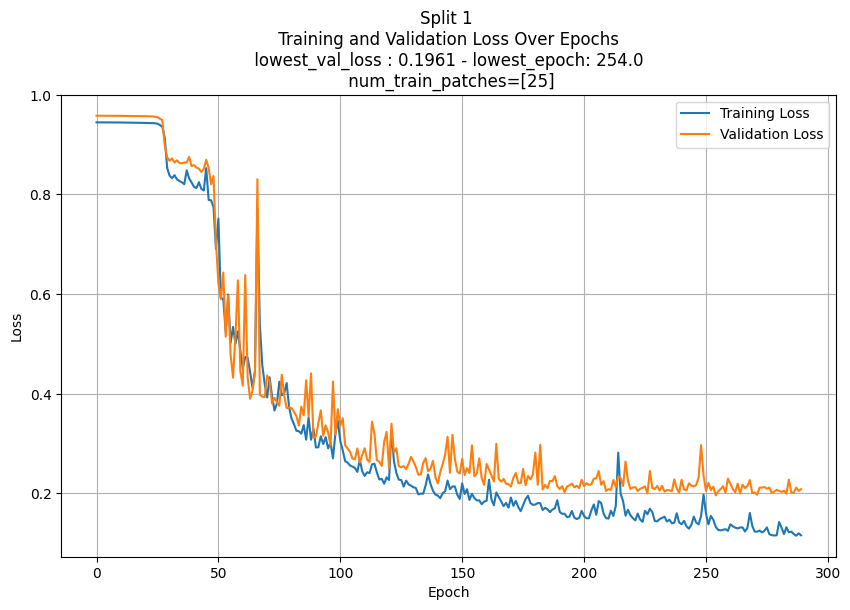


========== PLOTTING BEST_CHECKPOINT (EPOCH) VALIDATION RESULTS ==========
========== GROUND TRUTH VS PREDICTIONS ==========



/tmp/ipykernel_1082210/3107027896.py:258: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Validation results plot for split 1 saved at: executions/unet/tuning-train-test/id=123/train_test_split_1/validation_results_split_1.png


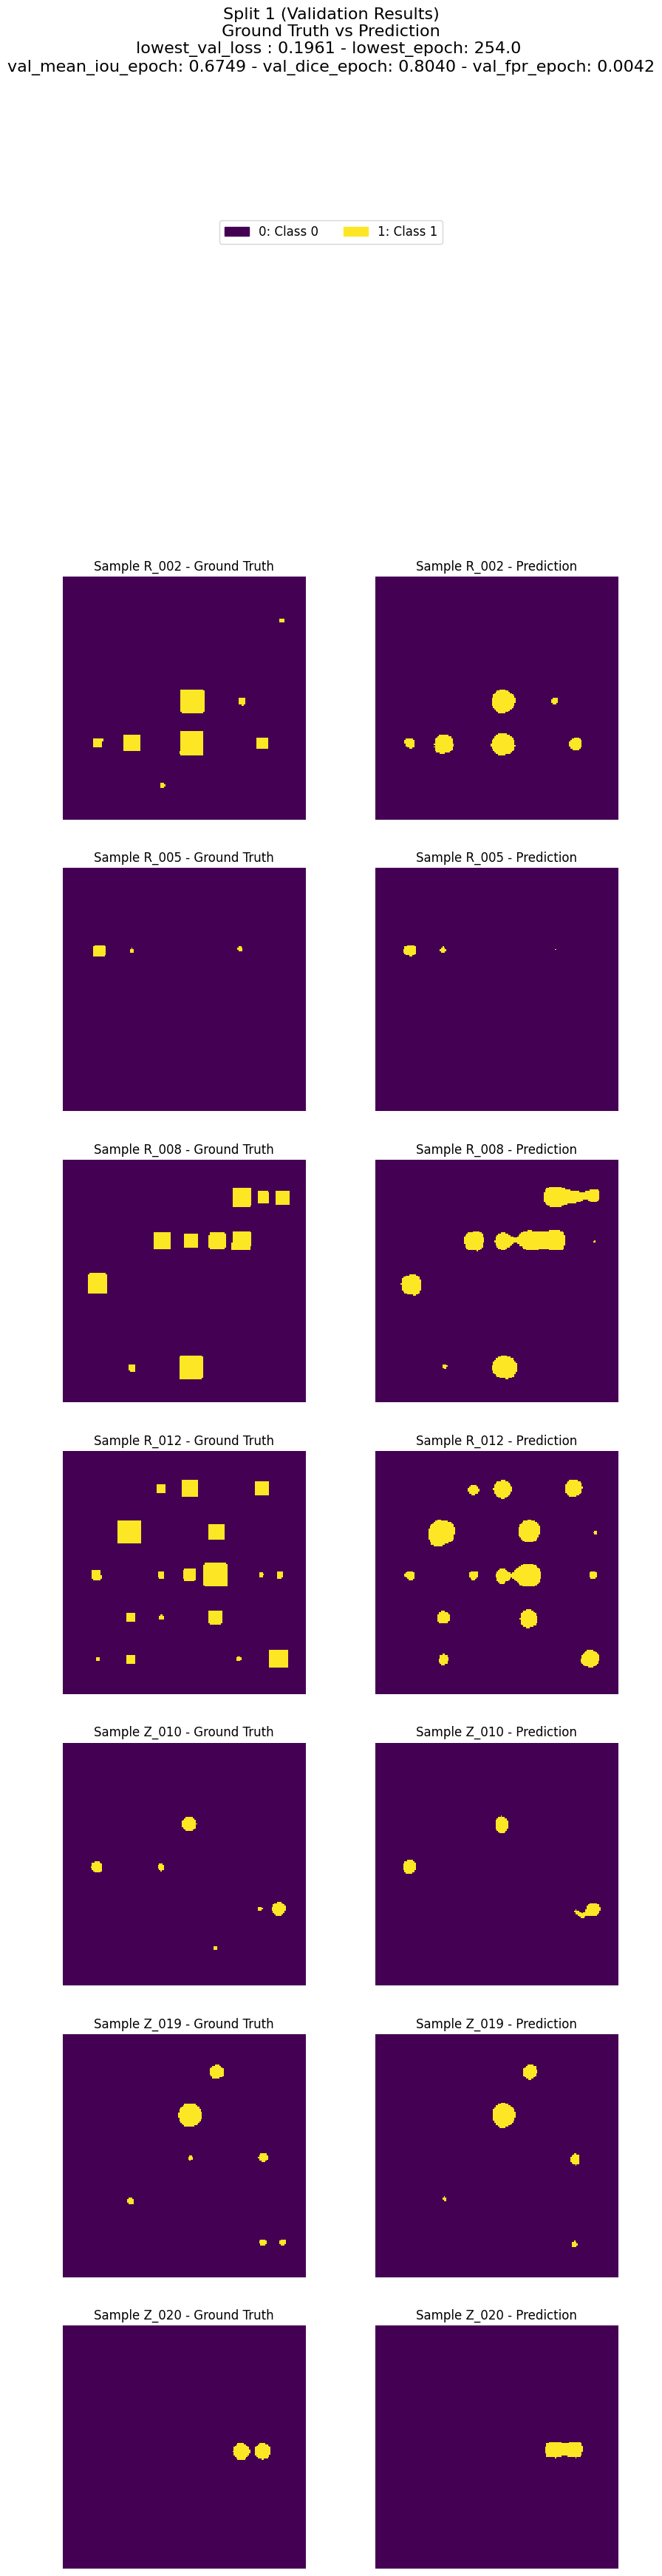


========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_009', 'R_015', 'R_019', 'Z_005', 'Z_014', 'Z_015'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_009 ...

R_009 loaded

Processing & loading sample R_015 ...

R_015 loaded

Processing & loading sample R_019 ...

R_019 loaded

Processing & loading sample Z_005 ...

Z_005 loaded

Processing & loading sample Z_014 ...

Z_014 loaded

Processing & loading sample Z_015 ...

Z_015 loaded

The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

==> DATA PREPOCESSING AND LOADING FINISHED


========== TESTING STARTS ==========

Found checkpoint: executions/unet/tuning-train-test/id=123/train_test_split_1/best-checkpoint-epoch=254-val_loss=0.20.ckpt


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

Starting testing epoch...
==> (TESTING) Average Dice Loss (include_background=[False]): 0.221392

==> (TESTING) Average Mean IoU (include_background=[False]): 0.650175

==> (TESTING) Average Dice Coefficient (include_background=[False]): 0.779381

==> (TESTING) Average FPR (include_background=[False]): 0.009433
Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch         0.779381275177002
     test_fpr_epoch        0.009432836435735226
     test_loss_epoch        0.22139234840869904
   test_mean_iou_epoch      0.6501747965812683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing completed in 0h 0m 2s

========== TESTING FINISHED ========

/tmp/ipykernel_1082210/3107027896.py:404: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Testing results plot for split 1 saved at: executions/unet/tuning-train-test/id=123/train_test_split_1/testing_results_split_1.png


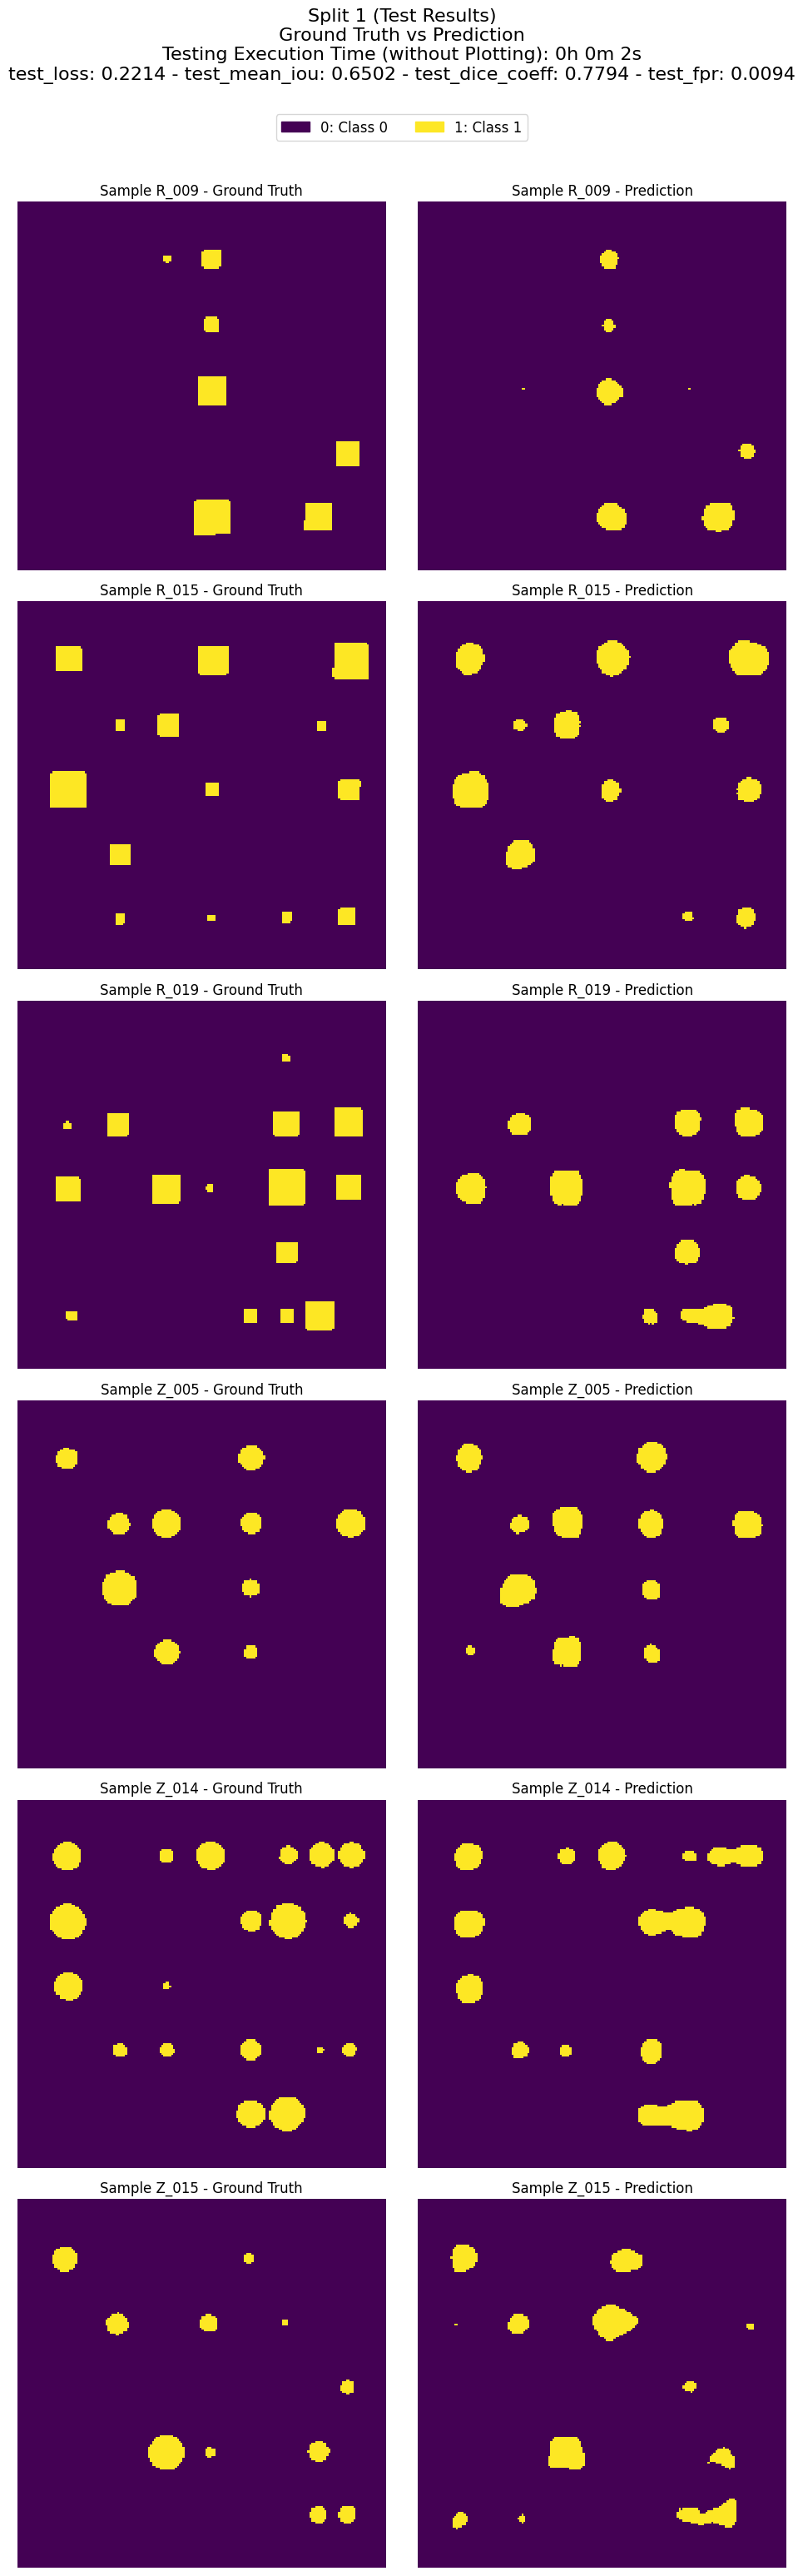

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



==================== TRAIN/TEST SPLIT: 2 ====================


===============> TRAINING DATA PREPARATION

 SAMPLES: dict_keys(['R_003', 'R_004', 'R_006', 'R_007', 'R_009', 'R_011', 'R_013', 'R_014', 'R_015', 'R_017', 'R_018', 'R_019', 'Z_003', 'Z_005', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_011', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_017'])



==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_003 ...

R_003 loaded

Processing & loading sample R_004 ...

R_004 loaded

Processing & loading sample R_006 ...

R_006 loaded

Processing & loading sample R_007 ...

R_007 loaded

Processing & loading sample R_009 ...

R_009 loaded

Processing & loading sample R_011 ...

R_011 loaded

Processing & loading sample R_013 ...

R_013 loaded

Processing & loading sample R_014 ...

R_014 loaded

Processing & loading sample R_015 ...

R_015 loaded

Processing & loading sample R_017 ...

R_017 loaded

Processing & loading sample R_018 ...

R_018 loaded

Processing & loa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | UNet_VGG11 | 25.4 M | train
1 | loss_fn | DiceLoss   | 0      | train
-----------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.474   Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.969635

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.057315

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.103944

==> (VALIDATION) Average FPR (include_background=[False]): 0.146702



Training: |                                                                                                   …

Starting training epoch 0...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957258

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.051368

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.093039

==> (VALIDATION) Average FPR (include_background=[False]): 0.492406

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932815
Finished training epoch 0

Starting training epoch 1...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957254

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.051943

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.093956

==> (VALIDATION) Average FPR (include_background=[False]): 0.479849

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932813
Finished training epoch 1

Starting training epoch 2...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957249

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.052577

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.094935

==> (VALIDATION) Average FPR (include_background=[False]): 0.459716

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932806
Finished training epoch 2

Starting training epoch 3...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957238

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.053688

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.096660

==> (VALIDATION) Average FPR (include_background=[False]): 0.422324

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932795
Finished training epoch 3

Starting training epoch 4...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957226

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.055028

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.098744

==> (VALIDATION) Average FPR (include_background=[False]): 0.381422

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932778
Finished training epoch 4

Starting training epoch 5...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957208

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.057336

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.102701

==> (VALIDATION) Average FPR (include_background=[False]): 0.330478

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932759
Finished training epoch 5

Starting training epoch 6...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957188

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.058472

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.105055

==> (VALIDATION) Average FPR (include_background=[False]): 0.280840

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932732
Finished training epoch 6

Starting training epoch 7...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957163

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.060837

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.109924

==> (VALIDATION) Average FPR (include_background=[False]): 0.234208

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932700
Finished training epoch 7

Starting training epoch 8...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957136

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.064198

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.116597

==> (VALIDATION) Average FPR (include_background=[False]): 0.194841

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932662
Finished training epoch 8

Starting training epoch 9...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957100

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.067479

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.122746

==> (VALIDATION) Average FPR (include_background=[False]): 0.159407

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932620
Finished training epoch 9

Starting training epoch 10...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957063

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.071760

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130036

==> (VALIDATION) Average FPR (include_background=[False]): 0.131444

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932570
Finished training epoch 10

Starting training epoch 11...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957017

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076901

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.138032

==> (VALIDATION) Average FPR (include_background=[False]): 0.106488

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932517
Finished training epoch 11

Starting training epoch 12...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956965

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.082337

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.145445

==> (VALIDATION) Average FPR (include_background=[False]): 0.091965

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932453
Finished training epoch 12

Starting training epoch 13...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956907

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.085605

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.149198

==> (VALIDATION) Average FPR (include_background=[False]): 0.081954

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932376
Finished training epoch 13

Starting training epoch 14...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956834

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.084444

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.147047

==> (VALIDATION) Average FPR (include_background=[False]): 0.075577

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932285
Finished training epoch 14

Starting training epoch 15...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956762

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.080498

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.141284

==> (VALIDATION) Average FPR (include_background=[False]): 0.071076

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932172
Finished training epoch 15

Starting training epoch 16...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956675

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.073318

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130967

==> (VALIDATION) Average FPR (include_background=[False]): 0.067003

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.932058
Finished training epoch 16

Starting training epoch 17...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956578

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.065066

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.118305

==> (VALIDATION) Average FPR (include_background=[False]): 0.063382

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.931932
Finished training epoch 17

Starting training epoch 18...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956469

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.058380

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.107461

==> (VALIDATION) Average FPR (include_background=[False]): 0.059940

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.931788
Finished training epoch 18

Starting training epoch 19...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956329

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.055067

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.101976

==> (VALIDATION) Average FPR (include_background=[False]): 0.056757

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.931623
Finished training epoch 19

Starting training epoch 20...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956156

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.055860

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.103445

==> (VALIDATION) Average FPR (include_background=[False]): 0.053490

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.931397
Finished training epoch 20

Starting training epoch 21...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955854

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.063011

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.115795

==> (VALIDATION) Average FPR (include_background=[False]): 0.049301

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.931086
Finished training epoch 21

Starting training epoch 22...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955317

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086502

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.154267

==> (VALIDATION) Average FPR (include_background=[False]): 0.040091

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.930540
Finished training epoch 22

Starting training epoch 23...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.954149

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.163242

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.267734

==> (VALIDATION) Average FPR (include_background=[False]): 0.019624

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.929487
Finished training epoch 23

Starting training epoch 24...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.950994

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.294704

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.431990

==> (VALIDATION) Average FPR (include_background=[False]): 0.009361

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.926900
Finished training epoch 24

Starting training epoch 25...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.923850

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.113747

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.197836

==> (VALIDATION) Average FPR (include_background=[False]): 0.067267

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.911878
Finished training epoch 25

Starting training epoch 26...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.870703

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.075563

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.136124

==> (VALIDATION) Average FPR (include_background=[False]): 0.150229

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.837806
Finished training epoch 26

Starting training epoch 27...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.872129

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.071934

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.129804

==> (VALIDATION) Average FPR (include_background=[False]): 0.197325

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.806840
Finished training epoch 27

Starting training epoch 28...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.880096

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.066898

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.121409

==> (VALIDATION) Average FPR (include_background=[False]): 0.237544

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.806676
Finished training epoch 28

Starting training epoch 29...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.855599

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.082518

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.147805

==> (VALIDATION) Average FPR (include_background=[False]): 0.113773

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.795873
Finished training epoch 29

Starting training epoch 30...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.846766

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.088830

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.157908

==> (VALIDATION) Average FPR (include_background=[False]): 0.107436

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.782102
Finished training epoch 30

Starting training epoch 31...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.835860

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.097693

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.171746

==> (VALIDATION) Average FPR (include_background=[False]): 0.105436

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.770194
Finished training epoch 31

Starting training epoch 32...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.830565

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.108119

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.183706

==> (VALIDATION) Average FPR (include_background=[False]): 0.000116

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.773074
Finished training epoch 32

Starting training epoch 33...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.821033

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.110209

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.191051

==> (VALIDATION) Average FPR (include_background=[False]): 0.101074

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.759117
Finished training epoch 33

Starting training epoch 34...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.699018

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.314525

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.457105

==> (VALIDATION) Average FPR (include_background=[False]): 0.004112

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.695611
Finished training epoch 34

Starting training epoch 35...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.620500

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.298559

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.434505

==> (VALIDATION) Average FPR (include_background=[False]): 0.001524

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.627682
Finished training epoch 35

Starting training epoch 36...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.559366

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.387130

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.529078

==> (VALIDATION) Average FPR (include_background=[False]): 0.004110

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.586159
Finished training epoch 36

Starting training epoch 37...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.609914

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.397016

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.542008

==> (VALIDATION) Average FPR (include_background=[False]): 0.013250

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.608732
Finished training epoch 37

Starting training epoch 38...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.507401

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.403290

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.546124

==> (VALIDATION) Average FPR (include_background=[False]): 0.004779

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.551403
Finished training epoch 38

Starting training epoch 39...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.486544

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.406141

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.547950

==> (VALIDATION) Average FPR (include_background=[False]): 0.004186

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.497727
Finished training epoch 39

Starting training epoch 40...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.707784

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.223205

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.348855

==> (VALIDATION) Average FPR (include_background=[False]): 0.056597

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.518989
Finished training epoch 40

Starting training epoch 41...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.694172

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.198908

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.306579

==> (VALIDATION) Average FPR (include_background=[False]): 0.000104

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.606015
Finished training epoch 41

Starting training epoch 42...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.468444

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.413220

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.555828

==> (VALIDATION) Average FPR (include_background=[False]): 0.005361

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.585308
Finished training epoch 42

Starting training epoch 43...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.483249

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.390061

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.530117

==> (VALIDATION) Average FPR (include_background=[False]): 0.003074

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.480945
Finished training epoch 43

Starting training epoch 44...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.456082

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.435014

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.576391

==> (VALIDATION) Average FPR (include_background=[False]): 0.007877

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.490607
Finished training epoch 44

Starting training epoch 45...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.453045

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.440485

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.580481

==> (VALIDATION) Average FPR (include_background=[False]): 0.009787

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.459797
Finished training epoch 45

Starting training epoch 46...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.450257

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.423993

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.565003

==> (VALIDATION) Average FPR (include_background=[False]): 0.004365

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.464246
Finished training epoch 46

Starting training epoch 47...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.506592

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.355501

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.494845

==> (VALIDATION) Average FPR (include_background=[False]): 0.001803

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.478329
Finished training epoch 47

Starting training epoch 48...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.423466

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.456114

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.594761

==> (VALIDATION) Average FPR (include_background=[False]): 0.007137

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.435893
Finished training epoch 48

Starting training epoch 49...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.420845

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.459668

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.597643

==> (VALIDATION) Average FPR (include_background=[False]): 0.008173

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.431940
Finished training epoch 49

Starting training epoch 50...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.564831

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.387477

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.547424

==> (VALIDATION) Average FPR (include_background=[False]): 0.024304

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.418783
Finished training epoch 50

Starting training epoch 51...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.438249

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.430237

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.569952

==> (VALIDATION) Average FPR (include_background=[False]): 0.003049

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.444772
Finished training epoch 51

Starting training epoch 52...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.512344

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.423515

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.584818

==> (VALIDATION) Average FPR (include_background=[False]): 0.019033

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.406890
Finished training epoch 52

Starting training epoch 53...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.448647

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.418451

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.557681

==> (VALIDATION) Average FPR (include_background=[False]): 0.002737

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.490460
Finished training epoch 53

Starting training epoch 54...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.461770

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.402601

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.543275

==> (VALIDATION) Average FPR (include_background=[False]): 0.002088

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.419058
Finished training epoch 54

Starting training epoch 55...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.409499

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.475257

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.628495

==> (VALIDATION) Average FPR (include_background=[False]): 0.011437

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.476192
Finished training epoch 55

Starting training epoch 56...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.455684

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.409730

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.550495

==> (VALIDATION) Average FPR (include_background=[False]): 0.002076

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.410351
Finished training epoch 56

Starting training epoch 57...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.444352

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.421588

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.562602

==> (VALIDATION) Average FPR (include_background=[False]): 0.002368

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.414391
Finished training epoch 57

Starting training epoch 58...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.450970

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.414565

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.555564

==> (VALIDATION) Average FPR (include_background=[False]): 0.002071

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.416190
Finished training epoch 58

Starting training epoch 59...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.653219

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.257188

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.391310

==> (VALIDATION) Average FPR (include_background=[False]): 0.050049

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.396092
Finished training epoch 59

Starting training epoch 60...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.391191

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.488770

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.621990

==> (VALIDATION) Average FPR (include_background=[False]): 0.004575

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.457266
Finished training epoch 60

Starting training epoch 61...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.383751

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.497124

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.628856

==> (VALIDATION) Average FPR (include_background=[False]): 0.005075

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.374375
Finished training epoch 61

Starting training epoch 62...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.380120

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.496222

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.627901

==> (VALIDATION) Average FPR (include_background=[False]): 0.006297

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.372707
Finished training epoch 62

Starting training epoch 63...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.370304

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.499263

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.646101

==> (VALIDATION) Average FPR (include_background=[False]): 0.009690

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.374265
Finished training epoch 63

Starting training epoch 64...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.637265

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.238428

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.359168

==> (VALIDATION) Average FPR (include_background=[False]): 0.000287

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.381197
Finished training epoch 64

Starting training epoch 65...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.375637

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.501950

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.631904

==> (VALIDATION) Average FPR (include_background=[False]): 0.006435

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.476534
Finished training epoch 65

Starting training epoch 66...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.372276

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.513922

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.641910

==> (VALIDATION) Average FPR (include_background=[False]): 0.003591

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.400739
Finished training epoch 66

Starting training epoch 67...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.351715

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.515793

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.660690

==> (VALIDATION) Average FPR (include_background=[False]): 0.008937

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.346425
Finished training epoch 67

Starting training epoch 68...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.358125

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.515776

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.643489

==> (VALIDATION) Average FPR (include_background=[False]): 0.005964

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.341374
Finished training epoch 68

Starting training epoch 69...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.418522

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.449043

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.587735

==> (VALIDATION) Average FPR (include_background=[False]): 0.001813

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.369780
Finished training epoch 69

Starting training epoch 70...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.362127

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.519952

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.646875

==> (VALIDATION) Average FPR (include_background=[False]): 0.004542

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.376323
Finished training epoch 70

Starting training epoch 71...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.356634

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.527829

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.652876

==> (VALIDATION) Average FPR (include_background=[False]): 0.005760

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.340896
Finished training epoch 71

Starting training epoch 72...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.384459

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.505513

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.663341

==> (VALIDATION) Average FPR (include_background=[False]): 0.013539

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.323361
Finished training epoch 72

Starting training epoch 73...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.354137

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.530744

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.655295

==> (VALIDATION) Average FPR (include_background=[False]): 0.003614

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.377407
Finished training epoch 73

Starting training epoch 74...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.384675

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.492160

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.624451

==> (VALIDATION) Average FPR (include_background=[False]): 0.002076

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.402745
Finished training epoch 74

Starting training epoch 75...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.350587

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.519724

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.646111

==> (VALIDATION) Average FPR (include_background=[False]): 0.007114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.376376
Finished training epoch 75

Starting training epoch 76...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.346597

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.539535

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.661893

==> (VALIDATION) Average FPR (include_background=[False]): 0.003644

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.315444
Finished training epoch 76

Starting training epoch 77...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.340233

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.547611

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.667890

==> (VALIDATION) Average FPR (include_background=[False]): 0.003280

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.303203
Finished training epoch 77

Starting training epoch 78...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.351132

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.529232

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.654104

==> (VALIDATION) Average FPR (include_background=[False]): 0.004071

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.324959
Finished training epoch 78

Starting training epoch 79...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.333505

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.539715

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.663444

==> (VALIDATION) Average FPR (include_background=[False]): 0.005976

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.302584
Finished training epoch 79

Starting training epoch 80...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.309546

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.555050

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.700980

==> (VALIDATION) Average FPR (include_background=[False]): 0.008436

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.308554
Finished training epoch 80

Starting training epoch 81...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.309041

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.566123

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.704738

==> (VALIDATION) Average FPR (include_background=[False]): 0.006563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.300903
Finished training epoch 81

Starting training epoch 82...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.328792

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.563376

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.679499

==> (VALIDATION) Average FPR (include_background=[False]): 0.003381

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.290512
Finished training epoch 82

Starting training epoch 83...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311399

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.565075

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.689557

==> (VALIDATION) Average FPR (include_background=[False]): 0.003726

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.279686
Finished training epoch 83

Starting training epoch 84...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336628

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.535876

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.661342

==> (VALIDATION) Average FPR (include_background=[False]): 0.006943

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.331165
Finished training epoch 84

Starting training epoch 85...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336784

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.545066

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.665961

==> (VALIDATION) Average FPR (include_background=[False]): 0.004028

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.299006
Finished training epoch 85

Starting training epoch 86...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.330989

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.559061

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.676448

==> (VALIDATION) Average FPR (include_background=[False]): 0.002778

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.277733
Finished training epoch 86

Starting training epoch 87...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.326211

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.565127

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.680738

==> (VALIDATION) Average FPR (include_background=[False]): 0.002998

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.267508
Finished training epoch 87

Starting training epoch 88...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.321414

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.553079

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.674795

==> (VALIDATION) Average FPR (include_background=[False]): 0.006256

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.300459
Finished training epoch 88

Starting training epoch 89...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.346270

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.520118

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.672027

==> (VALIDATION) Average FPR (include_background=[False]): 0.013332

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.278473
Finished training epoch 89

Starting training epoch 90...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311924

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.557480

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.699910

==> (VALIDATION) Average FPR (include_background=[False]): 0.008806

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.260836
Finished training epoch 90

Starting training epoch 91...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.322146

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.566166

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.681526

==> (VALIDATION) Average FPR (include_background=[False]): 0.002695

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.278474
Finished training epoch 91

Starting training epoch 92...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.316818

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.572960

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.686325

==> (VALIDATION) Average FPR (include_background=[False]): 0.004732

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.261240
Finished training epoch 92

Starting training epoch 93...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.304753

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.581989

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.702992

==> (VALIDATION) Average FPR (include_background=[False]): 0.005062

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.248769
Finished training epoch 93

Starting training epoch 94...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.312102

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.577906

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.689963

==> (VALIDATION) Average FPR (include_background=[False]): 0.003590

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.248812
Finished training epoch 94

Starting training epoch 95...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.307325

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.578885

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.693969

==> (VALIDATION) Average FPR (include_background=[False]): 0.003683

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.297354
Finished training epoch 95

Starting training epoch 96...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.314553

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.545203

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.698434

==> (VALIDATION) Average FPR (include_background=[False]): 0.011524

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.284700
Finished training epoch 96

Starting training epoch 97...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.310653

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573930

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.690397

==> (VALIDATION) Average FPR (include_background=[False]): 0.003677

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.257036
Finished training epoch 97

Starting training epoch 98...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.298297

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.574286

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.707567

==> (VALIDATION) Average FPR (include_background=[False]): 0.006729

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.251310
Finished training epoch 98

Starting training epoch 99...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.298941

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582381

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.704334

==> (VALIDATION) Average FPR (include_background=[False]): 0.005369

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.235756
Finished training epoch 99

Starting training epoch 100...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.286660

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.591476

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.716413

==> (VALIDATION) Average FPR (include_background=[False]): 0.004231

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238057
Finished training epoch 100

Starting training epoch 101...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.297144

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.578322

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.716148

==> (VALIDATION) Average FPR (include_background=[False]): 0.007576

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.233508
Finished training epoch 101

Starting training epoch 102...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.375726

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.488751

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.640687

==> (VALIDATION) Average FPR (include_background=[False]): 0.015048

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.237312
Finished training epoch 102

Starting training epoch 103...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.313045

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.577753

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.689953

==> (VALIDATION) Average FPR (include_background=[False]): 0.002706

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.237459
Finished training epoch 103

Starting training epoch 104...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.289242

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.590705

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.712171

==> (VALIDATION) Average FPR (include_background=[False]): 0.004236

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.252817
Finished training epoch 104

Starting training epoch 105...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.285508

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.578921

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.725559

==> (VALIDATION) Average FPR (include_background=[False]): 0.008543

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.291618
Finished training epoch 105

Starting training epoch 106...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.292647

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582375

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.707100

==> (VALIDATION) Average FPR (include_background=[False]): 0.004989

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.258098
Finished training epoch 106

Starting training epoch 107...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.312320

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.553430

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.694873

==> (VALIDATION) Average FPR (include_background=[False]): 0.009236

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.249928
Finished training epoch 107

Starting training epoch 108...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.306435

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573655

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.697377

==> (VALIDATION) Average FPR (include_background=[False]): 0.006108

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.253832
Finished training epoch 108

Starting training epoch 109...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.339964

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.543958

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.664923

==> (VALIDATION) Average FPR (include_background=[False]): 0.001066

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238788
Finished training epoch 109

Starting training epoch 110...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.305823

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.562208

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.700721

==> (VALIDATION) Average FPR (include_background=[False]): 0.009236

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.237592
Finished training epoch 110

Starting training epoch 111...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.305688

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.581603

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.692376

==> (VALIDATION) Average FPR (include_background=[False]): 0.003135

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.217064
Finished training epoch 111

Starting training epoch 112...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.307435

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586081

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.695695

==> (VALIDATION) Average FPR (include_background=[False]): 0.003174

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.218014
Finished training epoch 112

Starting training epoch 113...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.276332

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.604416

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.727462

==> (VALIDATION) Average FPR (include_background=[False]): 0.003541

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.212057
Finished training epoch 113

Starting training epoch 114...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.325983

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.560094

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.677007

==> (VALIDATION) Average FPR (include_background=[False]): 0.001485

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210753
Finished training epoch 114

Starting training epoch 115...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.309935

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.579905

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.691519

==> (VALIDATION) Average FPR (include_background=[False]): 0.002644

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.224784
Finished training epoch 115

Starting training epoch 116...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263530

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.612491

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742005

==> (VALIDATION) Average FPR (include_background=[False]): 0.004604

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.211936
Finished training epoch 116

Starting training epoch 117...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.304859

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586580

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.696216

==> (VALIDATION) Average FPR (include_background=[False]): 0.003062

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.206422
Finished training epoch 117

Starting training epoch 118...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.295360

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.575104

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.713606

==> (VALIDATION) Average FPR (include_background=[False]): 0.007780

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.207295
Finished training epoch 118

Starting training epoch 119...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244412

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623968

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758244

==> (VALIDATION) Average FPR (include_background=[False]): 0.003948

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.223690
Finished training epoch 119

Starting training epoch 120...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.316215

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.549066

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.691648

==> (VALIDATION) Average FPR (include_background=[False]): 0.009646

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210889
Finished training epoch 120

Starting training epoch 121...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249328

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.620956

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.755321

==> (VALIDATION) Average FPR (include_background=[False]): 0.004977

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.217041
Finished training epoch 121

Starting training epoch 122...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.307240

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.552526

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.698522

==> (VALIDATION) Average FPR (include_background=[False]): 0.010449

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.223703
Finished training epoch 122

Starting training epoch 123...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.313892

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573121

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.686535

==> (VALIDATION) Average FPR (include_background=[False]): 0.001959

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.215129
Finished training epoch 123

Starting training epoch 124...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.273066

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.595553

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.729110

==> (VALIDATION) Average FPR (include_background=[False]): 0.003425

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.223248
Finished training epoch 124

Starting training epoch 125...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.260311

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.607819

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.744804

==> (VALIDATION) Average FPR (include_background=[False]): 0.007138

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.219782
Finished training epoch 125

Starting training epoch 126...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.297971

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.585181

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.701491

==> (VALIDATION) Average FPR (include_background=[False]): 0.002580

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.207505
Finished training epoch 126

Starting training epoch 127...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318292

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.569639

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.684087

==> (VALIDATION) Average FPR (include_background=[False]): 0.002149

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.253737
Finished training epoch 127

Starting training epoch 128...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.246514

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624685

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759260

==> (VALIDATION) Average FPR (include_background=[False]): 0.005318

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.230840
Finished training epoch 128

Starting training epoch 129...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236588

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635666

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767357

==> (VALIDATION) Average FPR (include_background=[False]): 0.004406

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.219309
Finished training epoch 129

Starting training epoch 130...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.267453

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.597815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.731325

==> (VALIDATION) Average FPR (include_background=[False]): 0.002164

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.207390
Finished training epoch 130

Starting training epoch 131...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.321399

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.553396

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.680303

==> (VALIDATION) Average FPR (include_background=[False]): 0.008318

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.216823
Finished training epoch 131

Starting training epoch 132...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.260032

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.612785

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.739906

==> (VALIDATION) Average FPR (include_background=[False]): 0.004323

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201106
Finished training epoch 132

Starting training epoch 133...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.251563

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.621917

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754822

==> (VALIDATION) Average FPR (include_background=[False]): 0.005452

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191396
Finished training epoch 133

Starting training epoch 134...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.259615

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.612047

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742172

==> (VALIDATION) Average FPR (include_background=[False]): 0.003413

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.198177
Finished training epoch 134

Starting training epoch 135...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336507

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.523113

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.670392

==> (VALIDATION) Average FPR (include_background=[False]): 0.011898

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191151
Finished training epoch 135

Starting training epoch 136...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.245117

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624065

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758340

==> (VALIDATION) Average FPR (include_background=[False]): 0.004855

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.209442
Finished training epoch 136

Starting training epoch 137...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.326188

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.556816

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.674357

==> (VALIDATION) Average FPR (include_background=[False]): 0.001151

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190841
Finished training epoch 137

Starting training epoch 138...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.270622

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.608059

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.732671

==> (VALIDATION) Average FPR (include_background=[False]): 0.003922

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.243078
Finished training epoch 138

Starting training epoch 139...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228725

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.641465

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773322

==> (VALIDATION) Average FPR (include_background=[False]): 0.004077

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193541
Finished training epoch 139

Starting training epoch 140...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244514

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627076

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757220

==> (VALIDATION) Average FPR (include_background=[False]): 0.002866

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192601
Finished training epoch 140

Starting training epoch 141...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.248714

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622760

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.752075

==> (VALIDATION) Average FPR (include_background=[False]): 0.003282

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191188
Finished training epoch 141

Starting training epoch 142...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257893

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.608374

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.744606

==> (VALIDATION) Average FPR (include_background=[False]): 0.007170

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191909
Finished training epoch 142

Starting training epoch 143...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237918

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632708

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764607

==> (VALIDATION) Average FPR (include_background=[False]): 0.003061

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185302
Finished training epoch 143

Starting training epoch 144...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.245911

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622984

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756253

==> (VALIDATION) Average FPR (include_background=[False]): 0.003945

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.218421
Finished training epoch 144

Starting training epoch 145...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.274331

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.604711

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728109

==> (VALIDATION) Average FPR (include_background=[False]): 0.003066

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210161
Finished training epoch 145

Starting training epoch 146...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249626

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615435

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.751566

==> (VALIDATION) Average FPR (include_background=[False]): 0.005196

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201837
Finished training epoch 146

Starting training epoch 147...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241333

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626524

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761219

==> (VALIDATION) Average FPR (include_background=[False]): 0.005877

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193924
Finished training epoch 147

Starting training epoch 148...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237166

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635984

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768034

==> (VALIDATION) Average FPR (include_background=[False]): 0.002672

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184913
Finished training epoch 148

Starting training epoch 149...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232507

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635491

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770337

==> (VALIDATION) Average FPR (include_background=[False]): 0.005385

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188744
Finished training epoch 149

Starting training epoch 150...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.240364

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624208

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759496

==> (VALIDATION) Average FPR (include_background=[False]): 0.004839

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.197836
Finished training epoch 150

Starting training epoch 151...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257804

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.613531

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745095

==> (VALIDATION) Average FPR (include_background=[False]): 0.005440

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196724
Finished training epoch 151

Starting training epoch 152...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239786

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626157

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759631

==> (VALIDATION) Average FPR (include_background=[False]): 0.004356

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188305
Finished training epoch 152

Starting training epoch 153...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.266666

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596369

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.736108

==> (VALIDATION) Average FPR (include_background=[False]): 0.007896

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184819
Finished training epoch 153

Starting training epoch 154...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237965

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633472

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764019

==> (VALIDATION) Average FPR (include_background=[False]): 0.004319

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176821
Finished training epoch 154

Starting training epoch 155...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.233219

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633571

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766802

==> (VALIDATION) Average FPR (include_background=[False]): 0.003576

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174340
Finished training epoch 155

Starting training epoch 156...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244034

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627613

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756855

==> (VALIDATION) Average FPR (include_background=[False]): 0.003434

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169704
Finished training epoch 156

Starting training epoch 157...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.261711

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.606513

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.739767

==> (VALIDATION) Average FPR (include_background=[False]): 0.006079

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176072
Finished training epoch 157

Starting training epoch 158...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.235392

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635693

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768452

==> (VALIDATION) Average FPR (include_background=[False]): 0.005053

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.172148
Finished training epoch 158

Starting training epoch 159...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232035

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642906

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772026

==> (VALIDATION) Average FPR (include_background=[False]): 0.003477

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169942
Finished training epoch 159

Starting training epoch 160...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237281

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634253

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766212

==> (VALIDATION) Average FPR (include_background=[False]): 0.004548

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171037
Finished training epoch 160

Starting training epoch 161...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242401

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761003

==> (VALIDATION) Average FPR (include_background=[False]): 0.005916

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169303
Finished training epoch 161

Starting training epoch 162...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241652

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.621646

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759394

==> (VALIDATION) Average FPR (include_background=[False]): 0.004563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191907
Finished training epoch 162

Starting training epoch 163...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234806

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636220

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768496

==> (VALIDATION) Average FPR (include_background=[False]): 0.005297

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193388
Finished training epoch 163

Starting training epoch 164...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219877

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651475

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782270

==> (VALIDATION) Average FPR (include_background=[False]): 0.004349

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.173009
Finished training epoch 164

Starting training epoch 165...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219222

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649732

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782540

==> (VALIDATION) Average FPR (include_background=[False]): 0.004049

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177532
Finished training epoch 165

Starting training epoch 166...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.336129

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.531593

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.665597

==> (VALIDATION) Average FPR (include_background=[False]): 0.000913

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180099
Finished training epoch 166

Starting training epoch 167...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.306705

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.575240

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.694186

==> (VALIDATION) Average FPR (include_background=[False]): 0.001955

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.287090
Finished training epoch 167

Starting training epoch 168...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227319

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.641756

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775369

==> (VALIDATION) Average FPR (include_background=[False]): 0.005677

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188794
Finished training epoch 168

Starting training epoch 169...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227152

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643302

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773568

==> (VALIDATION) Average FPR (include_background=[False]): 0.004293

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174796
Finished training epoch 169

Starting training epoch 170...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.255919

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.619370

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.748122

==> (VALIDATION) Average FPR (include_background=[False]): 0.002169

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177736
Finished training epoch 170

Starting training epoch 171...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224492

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646655

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776884

==> (VALIDATION) Average FPR (include_background=[False]): 0.002688

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174117
Finished training epoch 171

Starting training epoch 172...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224072

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645997

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777412

==> (VALIDATION) Average FPR (include_background=[False]): 0.004586

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166561
Finished training epoch 172

Starting training epoch 173...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.248123

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623064

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754768

==> (VALIDATION) Average FPR (include_background=[False]): 0.005049

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.172277
Finished training epoch 173

Starting training epoch 174...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.235816

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637045

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766195

==> (VALIDATION) Average FPR (include_background=[False]): 0.003419

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170069
Finished training epoch 174

Starting training epoch 175...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243712

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624243

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758806

==> (VALIDATION) Average FPR (include_background=[False]): 0.006486

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163646
Finished training epoch 175

Starting training epoch 176...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237575

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637019

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765522

==> (VALIDATION) Average FPR (include_background=[False]): 0.002789

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166300
Finished training epoch 176

Starting training epoch 177...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.287138

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.590184

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.712989

==> (VALIDATION) Average FPR (include_background=[False]): 0.001876

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185894
Finished training epoch 177

Starting training epoch 178...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228651

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637638

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768819

==> (VALIDATION) Average FPR (include_background=[False]): 0.003452

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170659
Finished training epoch 178

Starting training epoch 179...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232850

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639710

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769671

==> (VALIDATION) Average FPR (include_background=[False]): 0.004313

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162024
Finished training epoch 179

Starting training epoch 180...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.247148

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627171

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756453

==> (VALIDATION) Average FPR (include_background=[False]): 0.001802

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169697
Finished training epoch 180

Starting training epoch 181...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.240212

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631478

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763240

==> (VALIDATION) Average FPR (include_background=[False]): 0.006118

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166748
Finished training epoch 181

Starting training epoch 182...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227461

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773635

==> (VALIDATION) Average FPR (include_background=[False]): 0.004493

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164307
Finished training epoch 182

Starting training epoch 183...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226405

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646603

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776203

==> (VALIDATION) Average FPR (include_background=[False]): 0.003274

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.160747
Finished training epoch 183

Starting training epoch 184...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.363369

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.488103

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.639940

==> (VALIDATION) Average FPR (include_background=[False]): 0.015402

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176708
Finished training epoch 184

Starting training epoch 185...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257384

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.618468

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745162

==> (VALIDATION) Average FPR (include_background=[False]): 0.001871

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.198290
Finished training epoch 185

Starting training epoch 186...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220698

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647495

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779910

==> (VALIDATION) Average FPR (include_background=[False]): 0.004526

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.189403
Finished training epoch 186

Starting training epoch 187...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219505

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650037

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782462

==> (VALIDATION) Average FPR (include_background=[False]): 0.004614

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167987
Finished training epoch 187

Starting training epoch 188...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227621

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642752

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774444

==> (VALIDATION) Average FPR (include_background=[False]): 0.004320

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162414
Finished training epoch 188

Starting training epoch 189...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243219

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631282

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760241

==> (VALIDATION) Average FPR (include_background=[False]): 0.001909

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156918
Finished training epoch 189

Starting training epoch 190...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229813

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642462

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773488

==> (VALIDATION) Average FPR (include_background=[False]): 0.004276

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159386
Finished training epoch 190

Starting training epoch 191...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223853

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647793

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778293

==> (VALIDATION) Average FPR (include_background=[False]): 0.004871

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151555
Finished training epoch 191

Starting training epoch 192...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216617

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.653554

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785142

==> (VALIDATION) Average FPR (include_background=[False]): 0.004204

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199541
Finished training epoch 192

Starting training epoch 193...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.298499

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586849

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.699535

==> (VALIDATION) Average FPR (include_background=[False]): 0.001627

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.202563
Finished training epoch 193

Starting training epoch 194...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.238706

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631077

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759758

==> (VALIDATION) Average FPR (include_background=[False]): 0.002752

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175920
Finished training epoch 194

Starting training epoch 195...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226197

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643896

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774128

==> (VALIDATION) Average FPR (include_background=[False]): 0.004426

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163652
Finished training epoch 195

Starting training epoch 196...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216314

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655533

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785981

==> (VALIDATION) Average FPR (include_background=[False]): 0.002891

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153271
Finished training epoch 196

Starting training epoch 197...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.235453

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635421

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767071

==> (VALIDATION) Average FPR (include_background=[False]): 0.005868

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154219
Finished training epoch 197

Starting training epoch 198...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215386

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657656

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786869

==> (VALIDATION) Average FPR (include_background=[False]): 0.004002

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150548
Finished training epoch 198

Starting training epoch 199...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227851

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642098

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772799

==> (VALIDATION) Average FPR (include_background=[False]): 0.004873

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151119
Finished training epoch 199

Starting training epoch 200...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231862

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635725

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766780

==> (VALIDATION) Average FPR (include_background=[False]): 0.004673

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155602
Finished training epoch 200

Starting training epoch 201...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225032

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646278

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775302

==> (VALIDATION) Average FPR (include_background=[False]): 0.003235

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149078
Finished training epoch 201

Starting training epoch 202...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222255

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651520

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781930

==> (VALIDATION) Average FPR (include_background=[False]): 0.004820

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147757
Finished training epoch 202

Starting training epoch 203...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200862

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671558

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800568

==> (VALIDATION) Average FPR (include_background=[False]): 0.003349

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147698
Finished training epoch 203

Starting training epoch 204...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224880

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645550

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775156

==> (VALIDATION) Average FPR (include_background=[False]): 0.003334

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.160207
Finished training epoch 204

Starting training epoch 205...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232893

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638402

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769887

==> (VALIDATION) Average FPR (include_background=[False]): 0.006044

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170975
Finished training epoch 205

Starting training epoch 206...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218071

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651739

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782264

==> (VALIDATION) Average FPR (include_background=[False]): 0.002183

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156258
Finished training epoch 206

Starting training epoch 207...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226872

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644488

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774719

==> (VALIDATION) Average FPR (include_background=[False]): 0.005015

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153816
Finished training epoch 207

Starting training epoch 208...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227872

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643681

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772458

==> (VALIDATION) Average FPR (include_background=[False]): 0.003686

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.181073
Finished training epoch 208

Starting training epoch 209...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222644

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650234

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778935

==> (VALIDATION) Average FPR (include_background=[False]): 0.002890

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.157234
Finished training epoch 209

Starting training epoch 210...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232220

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638932

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767258

==> (VALIDATION) Average FPR (include_background=[False]): 0.004680

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162937
Finished training epoch 210

Starting training epoch 211...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208940

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661949

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790611

==> (VALIDATION) Average FPR (include_background=[False]): 0.003040

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149695
Finished training epoch 211

Starting training epoch 212...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228297

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642228

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772107

==> (VALIDATION) Average FPR (include_background=[False]): 0.005611

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147834
Finished training epoch 212

Starting training epoch 213...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221436

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651045

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779186

==> (VALIDATION) Average FPR (include_background=[False]): 0.002643

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142261
Finished training epoch 213

Starting training epoch 214...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214558

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659895

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787153

==> (VALIDATION) Average FPR (include_background=[False]): 0.003970

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145851
Finished training epoch 214

Starting training epoch 215...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218786

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652104

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782742

==> (VALIDATION) Average FPR (include_background=[False]): 0.004178

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.146024
Finished training epoch 215

Starting training epoch 216...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218419

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652557

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784533

==> (VALIDATION) Average FPR (include_background=[False]): 0.001666

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165797
Finished training epoch 216

Starting training epoch 217...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214454

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655681

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784816

==> (VALIDATION) Average FPR (include_background=[False]): 0.002154

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154464
Finished training epoch 217

Starting training epoch 218...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.247030

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.618021

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754243

==> (VALIDATION) Average FPR (include_background=[False]): 0.006433

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148055
Finished training epoch 218

Starting training epoch 219...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211885

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663163

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789874

==> (VALIDATION) Average FPR (include_background=[False]): 0.002757

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151035
Finished training epoch 219

Starting training epoch 220...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229215

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644776

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773134

==> (VALIDATION) Average FPR (include_background=[False]): 0.005310

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140816
Finished training epoch 220

Starting training epoch 221...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219312

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654963

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781737

==> (VALIDATION) Average FPR (include_background=[False]): 0.002759

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149249
Finished training epoch 221

Starting training epoch 222...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229472

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639586

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772235

==> (VALIDATION) Average FPR (include_background=[False]): 0.004865

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152692
Finished training epoch 222

Starting training epoch 223...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236027

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640390

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765700

==> (VALIDATION) Average FPR (include_background=[False]): 0.002065

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.172831
Finished training epoch 223

Starting training epoch 224...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226286

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651234

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776431

==> (VALIDATION) Average FPR (include_background=[False]): 0.004411

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147779
Finished training epoch 224

Starting training epoch 225...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212820

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663335

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789544

==> (VALIDATION) Average FPR (include_background=[False]): 0.002613

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142403
Finished training epoch 225

Starting training epoch 226...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215415

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658593

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786203

==> (VALIDATION) Average FPR (include_background=[False]): 0.002636

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150013
Finished training epoch 226

Starting training epoch 227...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216908

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655397

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783035

==> (VALIDATION) Average FPR (include_background=[False]): 0.004335

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142920
Finished training epoch 227

Starting training epoch 228...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216497

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654644

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783497

==> (VALIDATION) Average FPR (include_background=[False]): 0.001882

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140065
Finished training epoch 228

Starting training epoch 229...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200582

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.674157

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801143

==> (VALIDATION) Average FPR (include_background=[False]): 0.003263

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147024
Finished training epoch 229

Starting training epoch 230...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210623

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666382

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791430

==> (VALIDATION) Average FPR (include_background=[False]): 0.004256

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134403
Finished training epoch 230

Starting training epoch 231...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205080

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669323

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795088

==> (VALIDATION) Average FPR (include_background=[False]): 0.003181

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136772
Finished training epoch 231

Starting training epoch 232...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208356

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667780

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794330

==> (VALIDATION) Average FPR (include_background=[False]): 0.004414

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132828
Finished training epoch 232

Starting training epoch 233...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200238

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675812

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799835

==> (VALIDATION) Average FPR (include_background=[False]): 0.003219

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129804
Finished training epoch 233

Starting training epoch 234...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212925

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661329

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787474

==> (VALIDATION) Average FPR (include_background=[False]): 0.003335

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138604
Finished training epoch 234

Starting training epoch 235...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.335010

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.542856

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.664249

==> (VALIDATION) Average FPR (include_background=[False]): 0.001000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.216944
Finished training epoch 235

Starting training epoch 236...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198061

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.679345

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805479

==> (VALIDATION) Average FPR (include_background=[False]): 0.002694

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167415
Finished training epoch 236

Starting training epoch 237...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218147

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655560

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782605

==> (VALIDATION) Average FPR (include_background=[False]): 0.005157

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145721
Finished training epoch 237

Starting training epoch 238...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209105

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666263

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792800

==> (VALIDATION) Average FPR (include_background=[False]): 0.004165

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137955
Finished training epoch 238

Starting training epoch 239...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211337

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665814

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789729

==> (VALIDATION) Average FPR (include_background=[False]): 0.002831

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141571
Finished training epoch 239

Starting training epoch 240...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208484

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667508

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792221

==> (VALIDATION) Average FPR (include_background=[False]): 0.002863

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133577
Finished training epoch 240

Starting training epoch 241...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220022

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652686

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779787

==> (VALIDATION) Average FPR (include_background=[False]): 0.002002

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136678
Finished training epoch 241

Starting training epoch 242...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207786

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671016

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795195

==> (VALIDATION) Average FPR (include_background=[False]): 0.003503

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156324
Finished training epoch 242

Starting training epoch 243...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204996

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670892

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795977

==> (VALIDATION) Average FPR (include_background=[False]): 0.003308

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.170972
Finished training epoch 243

Starting training epoch 244...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199102

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680551

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803877

==> (VALIDATION) Average FPR (include_background=[False]): 0.003235

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.143572
Finished training epoch 244

Starting training epoch 245...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.258340

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.607191

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.744235

==> (VALIDATION) Average FPR (include_background=[False]): 0.008114

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151261
Finished training epoch 245

Starting training epoch 246...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206711

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670265

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795351

==> (VALIDATION) Average FPR (include_background=[False]): 0.003714

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139424
Finished training epoch 246

Starting training epoch 247...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207933

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668322

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793566

==> (VALIDATION) Average FPR (include_background=[False]): 0.004523

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.127064
Finished training epoch 247

Starting training epoch 248...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209318

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666955

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791032

==> (VALIDATION) Average FPR (include_background=[False]): 0.004132

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125397
Finished training epoch 248

Starting training epoch 249...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210130

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669405

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793489

==> (VALIDATION) Average FPR (include_background=[False]): 0.002994

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126533
Finished training epoch 249

Starting training epoch 250...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228083

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647046

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773964

==> (VALIDATION) Average FPR (include_background=[False]): 0.006135

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125713
Finished training epoch 250

Starting training epoch 251...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208045

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671772

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792631

==> (VALIDATION) Average FPR (include_background=[False]): 0.002907

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.127323
Finished training epoch 251

Starting training epoch 252...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216378

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658265

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783944

==> (VALIDATION) Average FPR (include_background=[False]): 0.004651

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125091
Finished training epoch 252

Starting training epoch 253...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200138

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680570

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803746

==> (VALIDATION) Average FPR (include_background=[False]): 0.003568

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124809
Finished training epoch 253

Starting training epoch 254...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202070

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678602

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800461

==> (VALIDATION) Average FPR (include_background=[False]): 0.002458

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123146
Finished training epoch 254

Starting training epoch 255...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202268

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.674761

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800141

==> (VALIDATION) Average FPR (include_background=[False]): 0.004803

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.135380
Finished training epoch 255

Starting training epoch 256...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214644

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660248

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785981

==> (VALIDATION) Average FPR (include_background=[False]): 0.004380

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128528
Finished training epoch 256

Starting training epoch 257...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215680

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658701

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783904

==> (VALIDATION) Average FPR (include_background=[False]): 0.002536

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132334
Finished training epoch 257

Starting training epoch 258...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207657

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671678

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794571

==> (VALIDATION) Average FPR (include_background=[False]): 0.003077

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136717
Finished training epoch 258

Starting training epoch 259...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201347

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678068

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800191

==> (VALIDATION) Average FPR (include_background=[False]): 0.002615

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123618
Finished training epoch 259

Starting training epoch 260...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217212

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659531

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784223

==> (VALIDATION) Average FPR (include_background=[False]): 0.005466

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.120110
Finished training epoch 260

Starting training epoch 261...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191200

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.686850

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808857

==> (VALIDATION) Average FPR (include_background=[False]): 0.003314

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125675
Finished training epoch 261

Starting training epoch 262...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202075

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675153

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799594

==> (VALIDATION) Average FPR (include_background=[False]): 0.004803

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125873
Finished training epoch 262

Starting training epoch 263...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204499

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.672304

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795429

==> (VALIDATION) Average FPR (include_background=[False]): 0.002190

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125099
Finished training epoch 263

Starting training epoch 264...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191969

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689859

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809945

==> (VALIDATION) Average FPR (include_background=[False]): 0.003330

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131701
Finished training epoch 264

Starting training epoch 265...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201642

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.677267

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799160

==> (VALIDATION) Average FPR (include_background=[False]): 0.002903

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123155
Finished training epoch 265

Starting training epoch 266...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.188397

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692087

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811845

==> (VALIDATION) Average FPR (include_background=[False]): 0.003892

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130816
Finished training epoch 266

Starting training epoch 267...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200302

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676324

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800230

==> (VALIDATION) Average FPR (include_background=[False]): 0.002052

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125579
Finished training epoch 267

Starting training epoch 268...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201464

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.678281

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800377

==> (VALIDATION) Average FPR (include_background=[False]): 0.004881

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124735
Finished training epoch 268

Starting training epoch 269...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191043

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692310

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811186

==> (VALIDATION) Average FPR (include_background=[False]): 0.003198

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123689
Finished training epoch 269

Starting training epoch 270...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200127

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.681557

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800871

==> (VALIDATION) Average FPR (include_background=[False]): 0.003919

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116538
Finished training epoch 270

Starting training epoch 271...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197148

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682423

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802871

==> (VALIDATION) Average FPR (include_background=[False]): 0.003545

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.114389
Finished training epoch 271

Starting training epoch 272...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203511

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676057

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797269

==> (VALIDATION) Average FPR (include_background=[False]): 0.004137

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116659
Finished training epoch 272

Starting training epoch 273...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.187858

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.694447

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.814218

==> (VALIDATION) Average FPR (include_background=[False]): 0.003923

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116401
Finished training epoch 273

Starting training epoch 274...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243509

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622837

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757913

==> (VALIDATION) Average FPR (include_background=[False]): 0.007116

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134125
Finished training epoch 274

Starting training epoch 275...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.235662

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642967

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766472

==> (VALIDATION) Average FPR (include_background=[False]): 0.002017

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156460
Finished training epoch 275

Starting training epoch 276...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186977

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693042

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815497

==> (VALIDATION) Average FPR (include_background=[False]): 0.002924

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144043
Finished training epoch 276

Starting training epoch 277...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214629

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661939

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786338

==> (VALIDATION) Average FPR (include_background=[False]): 0.004065

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148987
Finished training epoch 277

Starting training epoch 278...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200040

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.679955

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801178

==> (VALIDATION) Average FPR (include_background=[False]): 0.004582

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130432
Finished training epoch 278

Starting training epoch 279...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194277

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688353

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808180

==> (VALIDATION) Average FPR (include_background=[False]): 0.003750

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124190
Finished training epoch 279

Starting training epoch 280...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204287

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.674132

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795223

==> (VALIDATION) Average FPR (include_background=[False]): 0.002487

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.114020
Finished training epoch 280

Starting training epoch 281...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200804

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676974

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800647

==> (VALIDATION) Average FPR (include_background=[False]): 0.005183

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116792
Finished training epoch 281

Starting training epoch 282...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202485

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675707

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798529

==> (VALIDATION) Average FPR (include_background=[False]): 0.004633

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.117932
Finished training epoch 282

Starting training epoch 283...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193013

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.686039

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806641

==> (VALIDATION) Average FPR (include_background=[False]): 0.003285

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.120882
Finished training epoch 283

Starting training epoch 284...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192207

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689335

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809552

==> (VALIDATION) Average FPR (include_background=[False]): 0.004226

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126768
Finished training epoch 284

Starting training epoch 285...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205564

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.673430

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796478

==> (VALIDATION) Average FPR (include_background=[False]): 0.005080

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128718
Finished training epoch 285

Starting training epoch 286...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190298

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692377

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811824

==> (VALIDATION) Average FPR (include_background=[False]): 0.003293

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.120988
Finished training epoch 286

Starting training epoch 287...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193649

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685921

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806506

==> (VALIDATION) Average FPR (include_background=[False]): 0.003096

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121487
Finished training epoch 287

Starting training epoch 288...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189999

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.693264

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.811711

==> (VALIDATION) Average FPR (include_background=[False]): 0.003630

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121987
Finished training epoch 288

Starting training epoch 289...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193543

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.690515

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809146

==> (VALIDATION) Average FPR (include_background=[False]): 0.003200

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110468
Finished training epoch 289

Starting training epoch 290...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194759

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.684783

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805397

==> (VALIDATION) Average FPR (include_background=[False]): 0.004608

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.113437
Finished training epoch 290

Starting training epoch 291...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.189021

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.694840

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812951

==> (VALIDATION) Average FPR (include_background=[False]): 0.003387

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.114454
Finished training epoch 291

Starting training epoch 292...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197018

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.686396

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805347

==> (VALIDATION) Average FPR (include_background=[False]): 0.004117

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111683
Finished training epoch 292

Starting training epoch 293...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194041

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685733

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805954

==> (VALIDATION) Average FPR (include_background=[False]): 0.004629

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116694
Finished training epoch 293

Starting training epoch 294...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.193151

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685762

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.807216

==> (VALIDATION) Average FPR (include_background=[False]): 0.003277

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.118239
Finished training epoch 294

Starting training epoch 295...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.180499

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.704581

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.820855

==> (VALIDATION) Average FPR (include_background=[False]): 0.002669

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.127415
Finished training epoch 295

Starting training epoch 296...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192592

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685616

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806998

==> (VALIDATION) Average FPR (include_background=[False]): 0.004415

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111247
Finished training epoch 296

Starting training epoch 297...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191928

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691459

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809623

==> (VALIDATION) Average FPR (include_background=[False]): 0.003884

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109867
Finished training epoch 297

Starting training epoch 298...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185669

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.696578

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815657

==> (VALIDATION) Average FPR (include_background=[False]): 0.003543

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.107713
Finished training epoch 298

Starting training epoch 299...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196497

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.684054

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804171

==> (VALIDATION) Average FPR (include_background=[False]): 0.004592

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111992
Finished training epoch 299

Starting training epoch 300...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201033

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.680055

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801157

==> (VALIDATION) Average FPR (include_background=[False]): 0.004809

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.110423
Finished training epoch 300

Starting training epoch 301...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192577

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688228

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.807107

==> (VALIDATION) Average FPR (include_background=[False]): 0.002407

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.118571
Finished training epoch 301

Starting training epoch 302...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186432

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.695313

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815217

==> (VALIDATION) Average FPR (include_background=[False]): 0.004319

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108598
Finished training epoch 302

Starting training epoch 303...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184316

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.696619

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815711

==> (VALIDATION) Average FPR (include_background=[False]): 0.003318

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104087
Finished training epoch 303

Starting training epoch 304...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216572

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664457

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783065

==> (VALIDATION) Average FPR (include_background=[False]): 0.004054

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104764
Finished training epoch 304

Starting training epoch 305...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194633

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.686737

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804741

==> (VALIDATION) Average FPR (include_background=[False]): 0.002621

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.114037
Finished training epoch 305

Starting training epoch 306...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196976

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.683890

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804140

==> (VALIDATION) Average FPR (include_background=[False]): 0.004858

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.103598
Finished training epoch 306

Starting training epoch 307...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.183000

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.699010

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.816758

==> (VALIDATION) Average FPR (include_background=[False]): 0.003538

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102426
Finished training epoch 307

Starting training epoch 308...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185178

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.698540

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.815011

==> (VALIDATION) Average FPR (include_background=[False]): 0.003250

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.100465
Finished training epoch 308

Starting training epoch 309...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184863

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.699849

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817162

==> (VALIDATION) Average FPR (include_background=[False]): 0.003836

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.099272
Finished training epoch 309

Starting training epoch 310...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199889

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.677513

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799577

==> (VALIDATION) Average FPR (include_background=[False]): 0.005005

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.100987
Finished training epoch 310

Starting training epoch 311...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194217

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687509

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.807818

==> (VALIDATION) Average FPR (include_background=[False]): 0.003557

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116594
Finished training epoch 311

Starting training epoch 312...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.185145

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.700666

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.817364

==> (VALIDATION) Average FPR (include_background=[False]): 0.003321

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121983
Finished training epoch 312

Starting training epoch 313...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.184735

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.699141

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.816982

==> (VALIDATION) Average FPR (include_background=[False]): 0.003279

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115454
Finished training epoch 313

Starting training epoch 314...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192049

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.689124

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808313

==> (VALIDATION) Average FPR (include_background=[False]): 0.004682

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.103542
Finished training epoch 314

Starting training epoch 315...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191424

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.691687

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809899

==> (VALIDATION) Average FPR (include_background=[False]): 0.003897

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.097803
Finished training epoch 315

Starting training epoch 316...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195884

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687272

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805884

==> (VALIDATION) Average FPR (include_background=[False]): 0.002633

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102911
Finished training epoch 316

Starting training epoch 317...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.192194

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688974

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.808018

==> (VALIDATION) Average FPR (include_background=[False]): 0.003541

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.101022
Finished training epoch 317

Starting training epoch 318...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196451

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.686754

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803204

==> (VALIDATION) Average FPR (include_background=[False]): 0.003023

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.097201
Finished training epoch 318

Starting training epoch 319...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190517

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.692267

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.810379

==> (VALIDATION) Average FPR (include_background=[False]): 0.003411

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.100584
Finished training epoch 319

Starting training epoch 320...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.195110

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682272

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804894

==> (VALIDATION) Average FPR (include_background=[False]): 0.002095

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.107881
Finished training epoch 320

Starting training epoch 321...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.181512

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.701736

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.819031

==> (VALIDATION) Average FPR (include_background=[False]): 0.003569

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108392
Finished training epoch 321

Starting training epoch 322...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198227

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.684502

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802632

==> (VALIDATION) Average FPR (include_background=[False]): 0.003782

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.101258
Finished training epoch 322

Starting training epoch 323...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196081

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.687535

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805015

==> (VALIDATION) Average FPR (include_background=[False]): 0.002621

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108604
Finished training epoch 323

Starting training epoch 324...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222535

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.653983

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777093

==> (VALIDATION) Average FPR (include_background=[False]): 0.002393

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.106981
Finished training epoch 324

Starting training epoch 325...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196743

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.682235

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803306

==> (VALIDATION) Average FPR (include_background=[False]): 0.003590

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128790
Finished training epoch 325

Starting training epoch 326...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202427

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676100

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799027

==> (VALIDATION) Average FPR (include_background=[False]): 0.005249

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131789
Finished training epoch 326

Starting training epoch 327...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.186941

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.695790

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.813312

==> (VALIDATION) Average FPR (include_background=[False]): 0.002674

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115904
Finished training epoch 327

Starting training epoch 328...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.190237

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.694504

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.812215

==> (VALIDATION) Average FPR (include_background=[False]): 0.004198

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137124
Finished training epoch 328

Starting training epoch 329...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.194722

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.685739

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.806212

==> (VALIDATION) Average FPR (include_background=[False]): 0.002246

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108792
Finished training epoch 329

Starting training epoch 330...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.191345

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.688895

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.809478

==> (VALIDATION) Average FPR (include_background=[False]): 0.004266

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.100421
Finished training epoch 330

Training completed in 0h 6m 27s

========== TRAINING FINISHED ==========


========== PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION ==========

Lowest val_loss: 0.1804984956979751 at epoch 295.0
Training and validation loss evolution plot for split 2 saved at: executions/unet/tuning-train-test/id=123/train_test_split_2/training_validation_loss_evolution_split_2.png


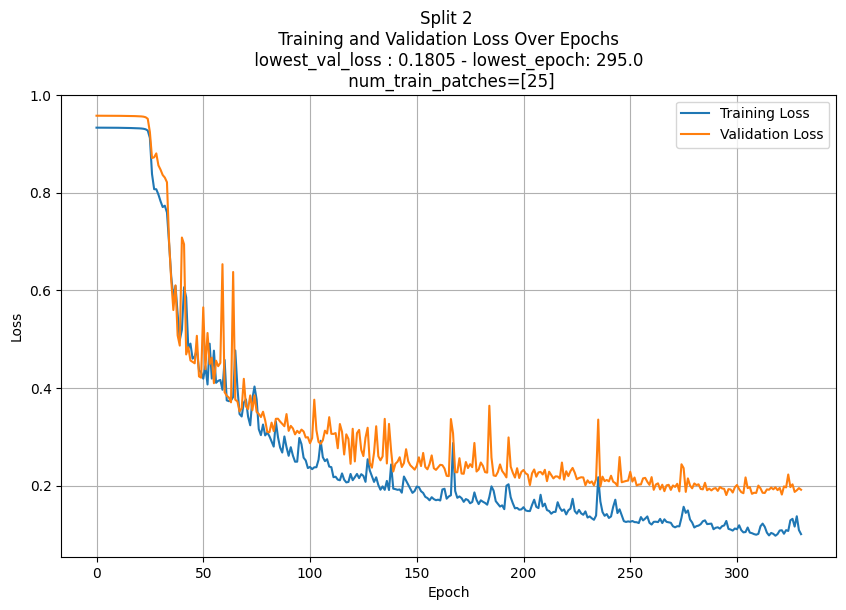


========== PLOTTING BEST_CHECKPOINT (EPOCH) VALIDATION RESULTS ==========
========== GROUND TRUTH VS PREDICTIONS ==========



/tmp/ipykernel_1082210/3107027896.py:258: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Validation results plot for split 2 saved at: executions/unet/tuning-train-test/id=123/train_test_split_2/validation_results_split_2.png


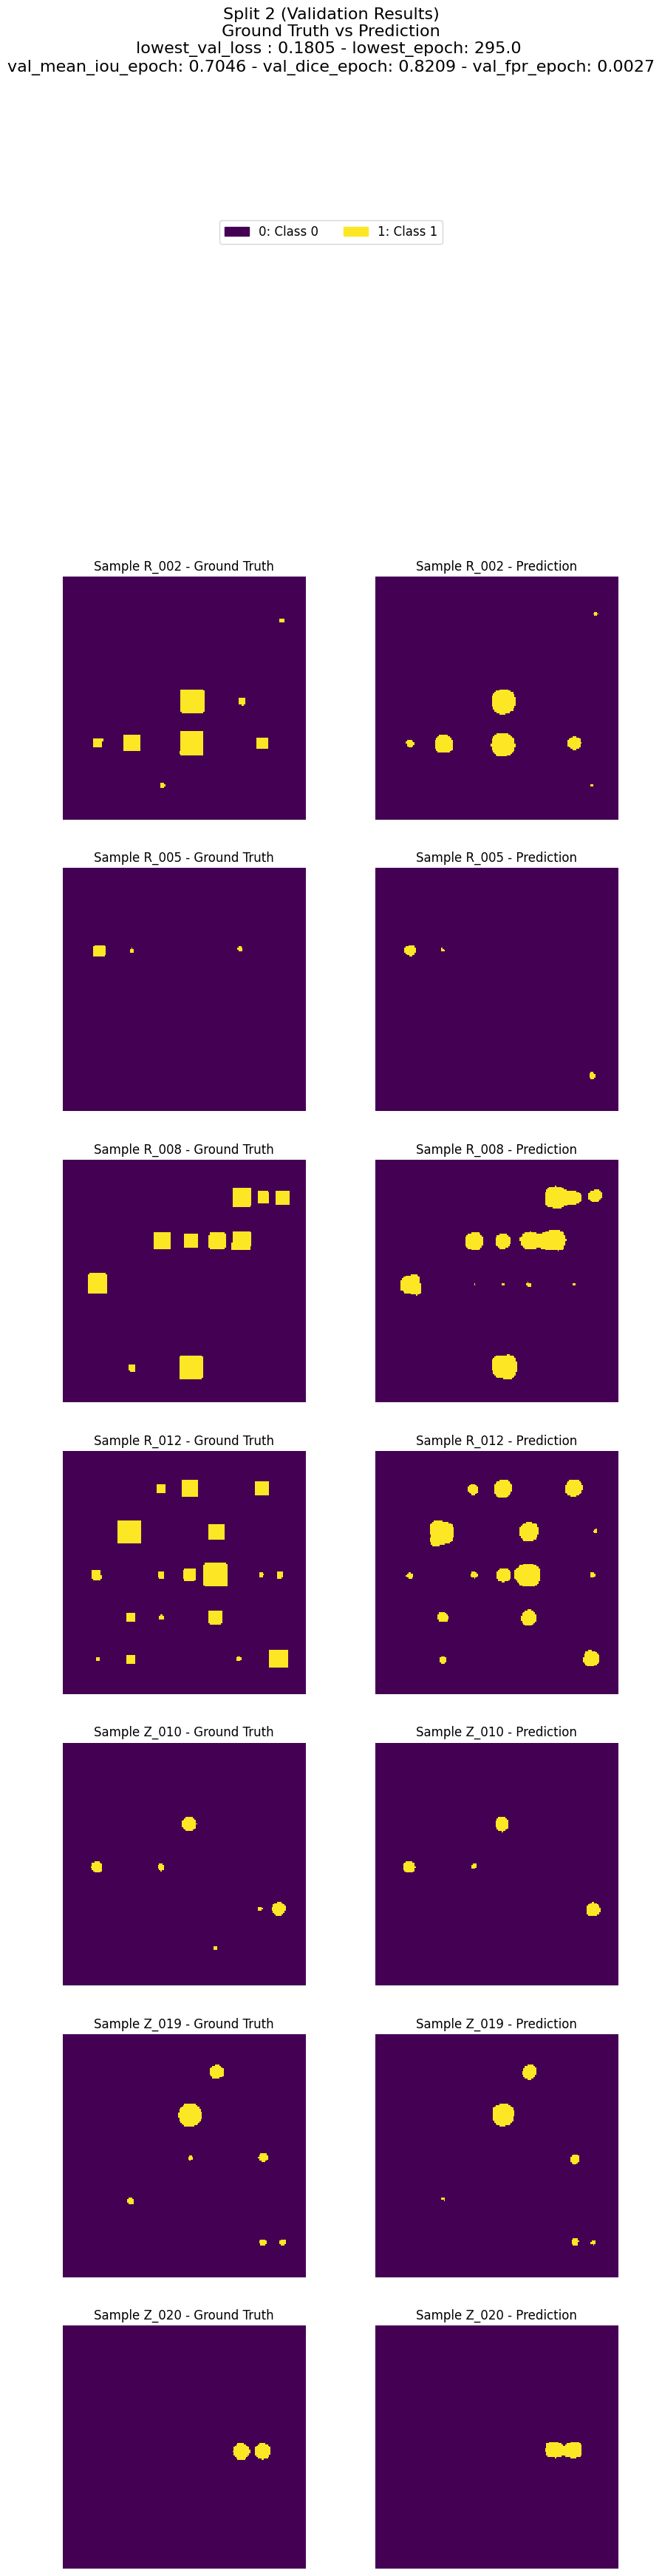


========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_010', 'R_016', 'R_020', 'Z_002', 'Z_004', 'Z_018'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_010 ...

R_010 loaded

Processing & loading sample R_016 ...

R_016 loaded

Processing & loading sample R_020 ...

R_020 loaded

Processing & loading sample Z_002 ...

Z_002 loaded

Processing & loading sample Z_004 ...

Z_004 loaded

Processing & loading sample Z_018 ...

Z_018 loaded

The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

==> DATA PREPOCESSING AND LOADING FINISHED


========== TESTING STARTS ==========

Found checkpoint: executions/unet/tuning-train-test/id=123/train_test_split_2/best-checkpoint-epoch=295-val_loss=0.18.ckpt


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

Starting testing epoch...
==> (TESTING) Average Dice Loss (include_background=[False]): 0.199750

==> (TESTING) Average Mean IoU (include_background=[False]): 0.676672

==> (TESTING) Average Dice Coefficient (include_background=[False]): 0.801466

==> (TESTING) Average FPR (include_background=[False]): 0.002454
Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.8014657497406006
     test_fpr_epoch        0.0024544557090848684
     test_loss_epoch        0.19974958896636963
   test_mean_iou_epoch      0.6766721606254578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing completed in 0h 0m 2s

========== TESTING FINISHED =======

/tmp/ipykernel_1082210/3107027896.py:404: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Testing results plot for split 2 saved at: executions/unet/tuning-train-test/id=123/train_test_split_2/testing_results_split_2.png


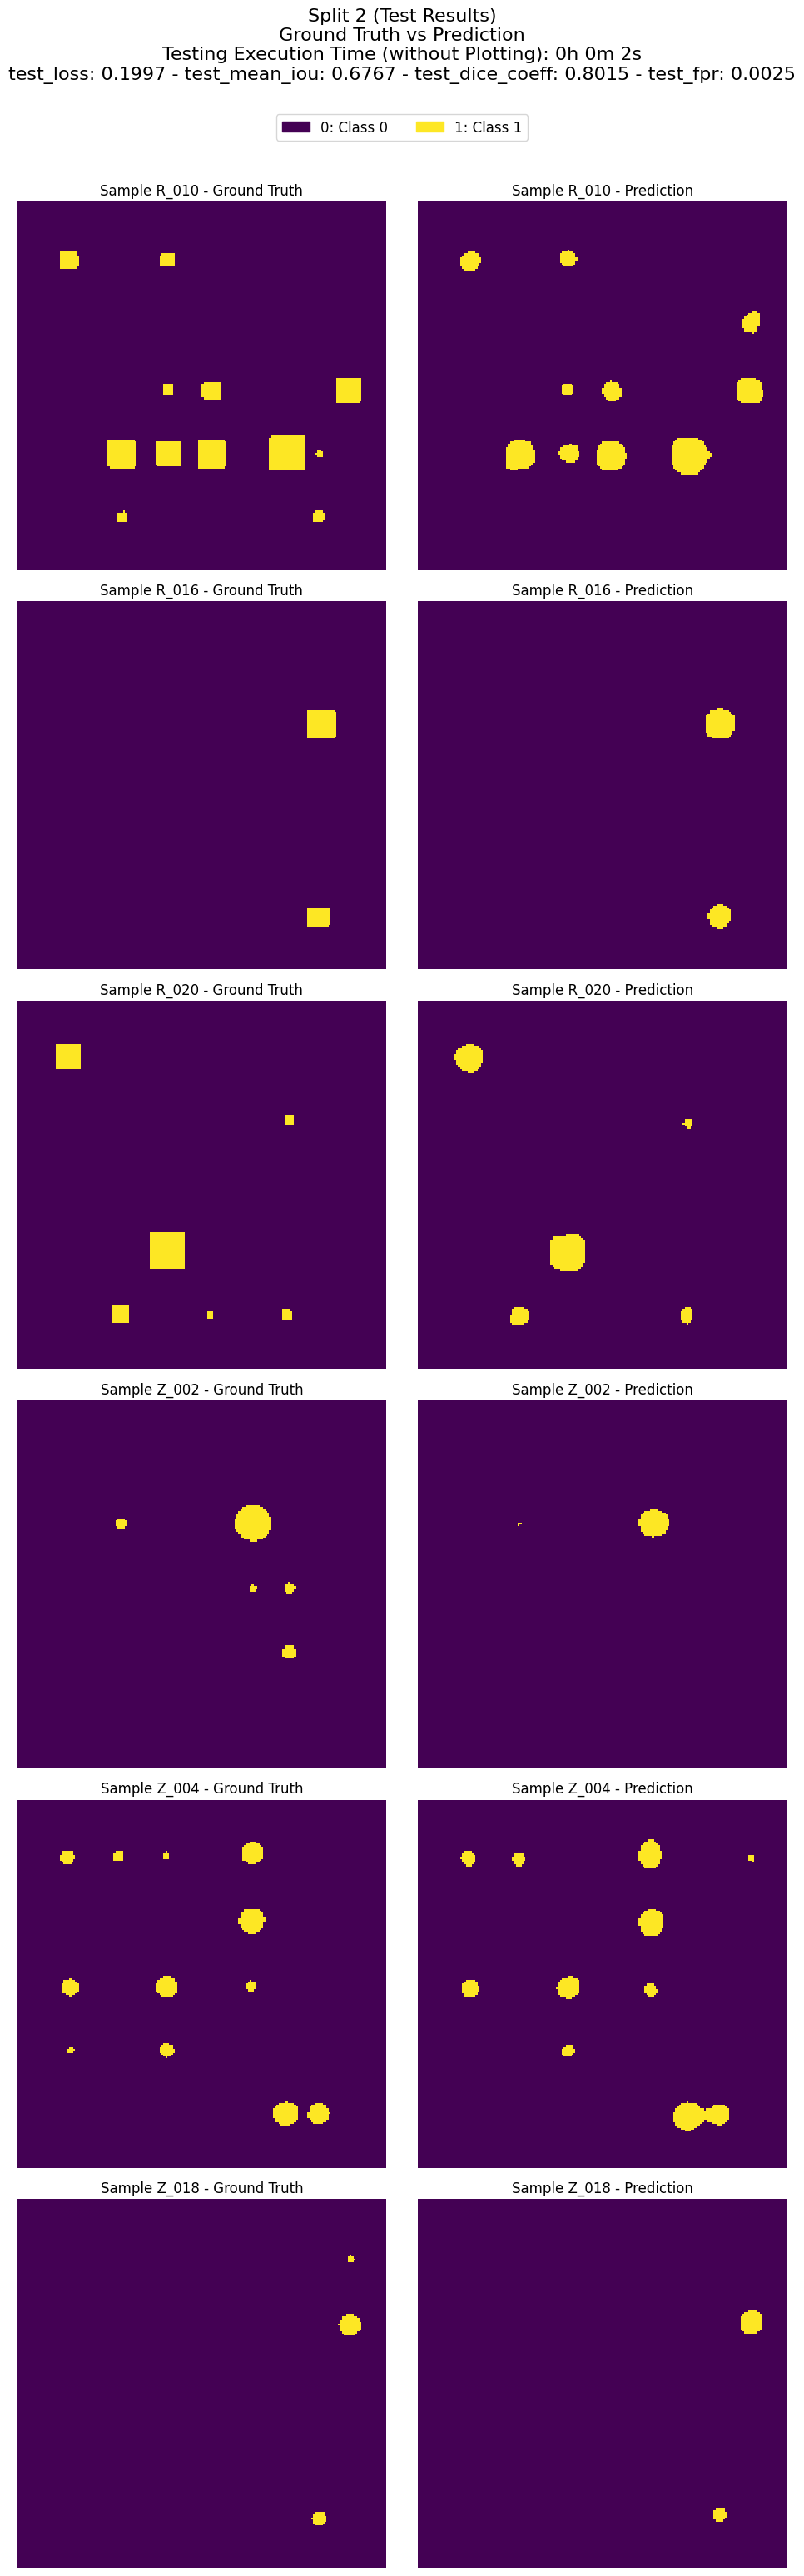

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



==================== TRAIN/TEST SPLIT: 3 ====================


===============> TRAINING DATA PREPARATION

 SAMPLES: dict_keys(['R_006', 'R_007', 'R_009', 'R_010', 'R_011', 'R_013', 'R_014', 'R_015', 'R_016', 'R_018', 'R_019', 'R_020', 'Z_002', 'Z_003', 'Z_004', 'Z_005', 'Z_006', 'Z_008', 'Z_012', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_017', 'Z_018'])



==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_006 ...

R_006 loaded

Processing & loading sample R_007 ...

R_007 loaded

Processing & loading sample R_009 ...

R_009 loaded

Processing & loading sample R_010 ...

R_010 loaded

Processing & loading sample R_011 ...

R_011 loaded

Processing & loading sample R_013 ...

R_013 loaded

Processing & loading sample R_014 ...

R_014 loaded

Processing & loading sample R_015 ...

R_015 loaded

Processing & loading sample R_016 ...

R_016 loaded

Processing & loading sample R_018 ...

R_018 loaded

Processing & loading sample R_019 ...

R_019 loaded

Processing & loa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | UNet_VGG11 | 25.4 M | train
1 | loss_fn | DiceLoss   | 0      | train
-----------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.474   Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.970064

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.007251

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.014340

==> (VALIDATION) Average FPR (include_background=[False]): 0.370270



Training: |                                                                                                   …

Starting training epoch 0...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957820

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.016030

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.031348

==> (VALIDATION) Average FPR (include_background=[False]): 0.250413

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935866
Finished training epoch 0

Starting training epoch 1...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957817

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.016755

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.032715

==> (VALIDATION) Average FPR (include_background=[False]): 0.230975

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935864
Finished training epoch 1

Starting training epoch 2...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957809

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.018339

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.035721

==> (VALIDATION) Average FPR (include_background=[False]): 0.194812

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935856
Finished training epoch 2

Starting training epoch 3...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957798

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.020198

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.039223

==> (VALIDATION) Average FPR (include_background=[False]): 0.152634

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935844
Finished training epoch 3

Starting training epoch 4...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957781

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022824

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.044107

==> (VALIDATION) Average FPR (include_background=[False]): 0.107388

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935827
Finished training epoch 4

Starting training epoch 5...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.025112

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.048368

==> (VALIDATION) Average FPR (include_background=[False]): 0.077338

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935803
Finished training epoch 5

Starting training epoch 6...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957737

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.025188

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.048484

==> (VALIDATION) Average FPR (include_background=[False]): 0.058584

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935773
Finished training epoch 6

Starting training epoch 7...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957705

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.024762

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.047626

==> (VALIDATION) Average FPR (include_background=[False]): 0.047753

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935738
Finished training epoch 7

Starting training epoch 8...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957664

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.023978

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.046036

==> (VALIDATION) Average FPR (include_background=[False]): 0.040523

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935694
Finished training epoch 8

Starting training epoch 9...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957615

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.023192

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.044546

==> (VALIDATION) Average FPR (include_background=[False]): 0.037006

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935638
Finished training epoch 9

Starting training epoch 10...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957550

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.023221

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.044553

==> (VALIDATION) Average FPR (include_background=[False]): 0.034211

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935569
Finished training epoch 10

Starting training epoch 11...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957476

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.022995

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.044081

==> (VALIDATION) Average FPR (include_background=[False]): 0.031726

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935480
Finished training epoch 11

Starting training epoch 12...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957398

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.023099

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.044169

==> (VALIDATION) Average FPR (include_background=[False]): 0.029589

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935379
Finished training epoch 12

Starting training epoch 13...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957315

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.023807

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.045396

==> (VALIDATION) Average FPR (include_background=[False]): 0.027643

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935273
Finished training epoch 13

Starting training epoch 14...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957231

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.024527

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.046709

==> (VALIDATION) Average FPR (include_background=[False]): 0.026047

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935160
Finished training epoch 14

Starting training epoch 15...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957140

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.026983

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.051093

==> (VALIDATION) Average FPR (include_background=[False]): 0.024508

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.935041
Finished training epoch 15

Starting training epoch 16...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957039

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.029675

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.055951

==> (VALIDATION) Average FPR (include_background=[False]): 0.023939

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.934913
Finished training epoch 16

Starting training epoch 17...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956939

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.032693

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.061378

==> (VALIDATION) Average FPR (include_background=[False]): 0.023335

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.934779
Finished training epoch 17

Starting training epoch 18...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956820

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.040077

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.074707

==> (VALIDATION) Average FPR (include_background=[False]): 0.023873

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.934636
Finished training epoch 18

Starting training epoch 19...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956653

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.051703

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.095723

==> (VALIDATION) Average FPR (include_background=[False]): 0.024971

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.934456
Finished training epoch 19

Starting training epoch 20...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956346

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.088358

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.158225

==> (VALIDATION) Average FPR (include_background=[False]): 0.028889

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.934173
Finished training epoch 20

Starting training epoch 21...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955634

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.166049

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.270860

==> (VALIDATION) Average FPR (include_background=[False]): 0.073272

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.933535
Finished training epoch 21

Starting training epoch 22...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.953809

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.028750

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.054928

==> (VALIDATION) Average FPR (include_background=[False]): 0.779273

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.931968
Finished training epoch 22

Starting training epoch 23...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.949591

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.027481

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.052585

==> (VALIDATION) Average FPR (include_background=[False]): 0.822095

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.928131
Finished training epoch 23

Starting training epoch 24...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.918757

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.065876

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.119537

==> (VALIDATION) Average FPR (include_background=[False]): 0.276347

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.911359
Finished training epoch 24

Starting training epoch 25...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.874655

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.072422

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130850

==> (VALIDATION) Average FPR (include_background=[False]): 0.184384

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.841774
Finished training epoch 25

Starting training epoch 26...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.877275

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.068852

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.124685

==> (VALIDATION) Average FPR (include_background=[False]): 0.215353

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.812915
Finished training epoch 26

Starting training epoch 27...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.863356

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.077284

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.138939

==> (VALIDATION) Average FPR (include_background=[False]): 0.151190

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.817035
Finished training epoch 27

Starting training epoch 28...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.866342

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.075062

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.135173

==> (VALIDATION) Average FPR (include_background=[False]): 0.173801

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.811086
Finished training epoch 28

Starting training epoch 29...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.873776

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.070738

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.127778

==> (VALIDATION) Average FPR (include_background=[False]): 0.213888

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.804421
Finished training epoch 29

Starting training epoch 30...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.859365

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.079068

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.141989

==> (VALIDATION) Average FPR (include_background=[False]): 0.144111

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.802243
Finished training epoch 30

Starting training epoch 31...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.850816

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.085777

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.153403

==> (VALIDATION) Average FPR (include_background=[False]): 0.100048

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.792062
Finished training epoch 31

Starting training epoch 32...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.872362

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.071600

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.129098

==> (VALIDATION) Average FPR (include_background=[False]): 0.214139

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.813391
Finished training epoch 32

Starting training epoch 33...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.851081

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.086041

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.154503

==> (VALIDATION) Average FPR (include_background=[False]): 0.049399

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.796042
Finished training epoch 33

Starting training epoch 34...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.851921

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.085146

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.151514

==> (VALIDATION) Average FPR (include_background=[False]): 0.134513

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.789437
Finished training epoch 34

Starting training epoch 35...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.900996

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.048566

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.089842

==> (VALIDATION) Average FPR (include_background=[False]): 0.000312

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.790968
Finished training epoch 35

Starting training epoch 36...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.820279

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.129927

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.221560

==> (VALIDATION) Average FPR (include_background=[False]): 0.004824

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.759316
Finished training epoch 36

Starting training epoch 37...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.803051

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.127945

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.218768

==> (VALIDATION) Average FPR (include_background=[False]): 0.067220

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.773446
Finished training epoch 37

Starting training epoch 38...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.795595

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.132122

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.224548

==> (VALIDATION) Average FPR (include_background=[False]): 0.074563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.731296
Finished training epoch 38

Starting training epoch 39...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.770663

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.162991

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.269924

==> (VALIDATION) Average FPR (include_background=[False]): 0.057071

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.734985
Finished training epoch 39

Starting training epoch 40...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.648297

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.323432

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.463493

==> (VALIDATION) Average FPR (include_background=[False]): 0.002508

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.678326
Finished training epoch 40

Starting training epoch 41...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.614803

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.395177

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.544692

==> (VALIDATION) Average FPR (include_background=[False]): 0.009457

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.602882
Finished training epoch 41

Starting training epoch 42...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.528045

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.415510

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.555808

==> (VALIDATION) Average FPR (include_background=[False]): 0.004122

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.561079
Finished training epoch 42

Starting training epoch 43...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.720081

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.174758

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.271437

==> (VALIDATION) Average FPR (include_background=[False]): 0.000137

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.528729
Finished training epoch 43

Starting training epoch 44...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.531333

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.417712

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.562151

==> (VALIDATION) Average FPR (include_background=[False]): 0.011015

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.611207
Finished training epoch 44

Starting training epoch 45...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.529829

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.348671

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.488362

==> (VALIDATION) Average FPR (include_background=[False]): 0.002023

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.514835
Finished training epoch 45

Starting training epoch 46...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.706706

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.182579

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.281252

==> (VALIDATION) Average FPR (include_background=[False]): 0.000165

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.559775
Finished training epoch 46

Starting training epoch 47...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.670247

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.264386

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.406664

==> (VALIDATION) Average FPR (include_background=[False]): 0.043979

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.522456
Finished training epoch 47

Starting training epoch 48...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.548811

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.327564

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.466497

==> (VALIDATION) Average FPR (include_background=[False]): 0.001427

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.462137
Finished training epoch 48

Starting training epoch 49...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.528376

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.346008

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.485367

==> (VALIDATION) Average FPR (include_background=[False]): 0.001769

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.541939
Finished training epoch 49

Starting training epoch 50...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.701721

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.212203

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.337683

==> (VALIDATION) Average FPR (include_background=[False]): 0.060904

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.457867
Finished training epoch 50

Starting training epoch 51...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.442369

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.452928

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.592077

==> (VALIDATION) Average FPR (include_background=[False]): 0.006652

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.520255
Finished training epoch 51

Starting training epoch 52...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.469632

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.437245

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.593040

==> (VALIDATION) Average FPR (include_background=[False]): 0.015571

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.448553
Finished training epoch 52

Starting training epoch 53...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.424102

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.458027

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.597933

==> (VALIDATION) Average FPR (include_background=[False]): 0.009277

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.429781
Finished training epoch 53

Starting training epoch 54...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.416656

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.462952

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.600811

==> (VALIDATION) Average FPR (include_background=[False]): 0.005677

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.419846
Finished training epoch 54

Starting training epoch 55...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.414399

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.466260

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.603533

==> (VALIDATION) Average FPR (include_background=[False]): 0.007953

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.477675
Finished training epoch 55

Starting training epoch 56...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.420685

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.462468

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.599801

==> (VALIDATION) Average FPR (include_background=[False]): 0.004454

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.475118
Finished training epoch 56

Starting training epoch 57...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.415722

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.473377

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.609221

==> (VALIDATION) Average FPR (include_background=[False]): 0.005751

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.489963
Finished training epoch 57

Starting training epoch 58...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.412113

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.467874

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.604416

==> (VALIDATION) Average FPR (include_background=[False]): 0.004578

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.419191
Finished training epoch 58

Starting training epoch 59...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.406194

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.468521

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.605076

==> (VALIDATION) Average FPR (include_background=[False]): 0.009333

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.432667
Finished training epoch 59

Starting training epoch 60...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.393626

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.479099

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.614013

==> (VALIDATION) Average FPR (include_background=[False]): 0.008443

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.422423
Finished training epoch 60

Starting training epoch 61...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.428493

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.478455

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.641615

==> (VALIDATION) Average FPR (include_background=[False]): 0.015554

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.389232
Finished training epoch 61

Starting training epoch 62...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.386721

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.490108

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.645494

==> (VALIDATION) Average FPR (include_background=[False]): 0.012292

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.396141
Finished training epoch 62

Starting training epoch 63...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.383290

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.484109

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.619499

==> (VALIDATION) Average FPR (include_background=[False]): 0.009596

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.420124
Finished training epoch 63

Starting training epoch 64...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.364754

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.521159

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.679052

==> (VALIDATION) Average FPR (include_background=[False]): 0.011459

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.394095
Finished training epoch 64

Starting training epoch 65...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.421117

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.482182

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.645900

==> (VALIDATION) Average FPR (include_background=[False]): 0.017370

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.362576
Finished training epoch 65

Starting training epoch 66...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.361975

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.507224

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.648942

==> (VALIDATION) Average FPR (include_background=[False]): 0.008911

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.360137
Finished training epoch 66

Starting training epoch 67...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.364249

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.506231

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.637541

==> (VALIDATION) Average FPR (include_background=[False]): 0.007002

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.360474
Finished training epoch 67

Starting training epoch 68...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.361768

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.515522

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.643205

==> (VALIDATION) Average FPR (include_background=[False]): 0.006005

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.344596
Finished training epoch 68

Starting training epoch 69...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.398142

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.477704

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.612332

==> (VALIDATION) Average FPR (include_background=[False]): 0.002317

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.324385
Finished training epoch 69

Starting training epoch 70...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.473394

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.393581

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.533915

==> (VALIDATION) Average FPR (include_background=[False]): 0.001278

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.364925
Finished training epoch 70

Starting training epoch 71...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.353983

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.534297

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.657638

==> (VALIDATION) Average FPR (include_background=[False]): 0.005865

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.362365
Finished training epoch 71

Starting training epoch 72...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.358541

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.528716

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.653126

==> (VALIDATION) Average FPR (include_background=[False]): 0.003960

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.318891
Finished training epoch 72

Starting training epoch 73...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.319835

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.550864

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.704592

==> (VALIDATION) Average FPR (include_background=[False]): 0.011020

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.314062
Finished training epoch 73

Starting training epoch 74...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.320857

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.552628

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.688977

==> (VALIDATION) Average FPR (include_background=[False]): 0.004534

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.290736
Finished training epoch 74

Starting training epoch 75...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311333

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.565767

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.701180

==> (VALIDATION) Average FPR (include_background=[False]): 0.005766

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.290260
Finished training epoch 75

Starting training epoch 76...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.331790

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.539105

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.695698

==> (VALIDATION) Average FPR (include_background=[False]): 0.013576

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.301812
Finished training epoch 76

Starting training epoch 77...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.308128

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.566799

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.703672

==> (VALIDATION) Average FPR (include_background=[False]): 0.005117

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.285852
Finished training epoch 77

Starting training epoch 78...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.366258

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.516555

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.643714

==> (VALIDATION) Average FPR (include_background=[False]): 0.002006

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.319806
Finished training epoch 78

Starting training epoch 79...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.337151

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.548891

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.668576

==> (VALIDATION) Average FPR (include_background=[False]): 0.005166

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.297988
Finished training epoch 79

Starting training epoch 80...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318657

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.551722

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.685082

==> (VALIDATION) Average FPR (include_background=[False]): 0.007001

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.275472
Finished training epoch 80

Starting training epoch 81...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.365780

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.516033

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.642867

==> (VALIDATION) Average FPR (include_background=[False]): 0.002030

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.274183
Finished training epoch 81

Starting training epoch 82...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.320954

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.541567

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.697328

==> (VALIDATION) Average FPR (include_background=[False]): 0.014055

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.275964
Finished training epoch 82

Starting training epoch 83...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.299495

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.563750

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.711881

==> (VALIDATION) Average FPR (include_background=[False]): 0.010672

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.257958
Finished training epoch 83

Starting training epoch 84...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.276666

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.597126

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.734219

==> (VALIDATION) Average FPR (include_background=[False]): 0.006121

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.251112
Finished training epoch 84

Starting training epoch 85...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.282181

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.590945

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.737185

==> (VALIDATION) Average FPR (include_background=[False]): 0.010085

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.250533
Finished training epoch 85

Starting training epoch 86...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.284468

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.575815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.724177

==> (VALIDATION) Average FPR (include_background=[False]): 0.010370

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.263674
Finished training epoch 86

Starting training epoch 87...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.293016

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.583697

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.713767

==> (VALIDATION) Average FPR (include_background=[False]): 0.005489

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.250060
Finished training epoch 87

Starting training epoch 88...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.270455

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.601065

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.738446

==> (VALIDATION) Average FPR (include_background=[False]): 0.006700

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.247058
Finished training epoch 88

Starting training epoch 89...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.279251

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.594319

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728638

==> (VALIDATION) Average FPR (include_background=[False]): 0.005519

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.246798
Finished training epoch 89

Starting training epoch 90...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263844

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.608031

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.743371

==> (VALIDATION) Average FPR (include_background=[False]): 0.004942

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.238997
Finished training epoch 90

Starting training epoch 91...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.431920

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.433941

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.568544

==> (VALIDATION) Average FPR (include_background=[False]): 0.001006

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.261810
Finished training epoch 91

Starting training epoch 92...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.322286

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.538539

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.696274

==> (VALIDATION) Average FPR (include_background=[False]): 0.015685

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.276001
Finished training epoch 92

Starting training epoch 93...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318901

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.572065

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.686040

==> (VALIDATION) Average FPR (include_background=[False]): 0.004301

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.259435
Finished training epoch 93

Starting training epoch 94...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.284425

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.583888

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.717523

==> (VALIDATION) Average FPR (include_background=[False]): 0.005447

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.234500
Finished training epoch 94

Starting training epoch 95...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263593

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.605731

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.740408

==> (VALIDATION) Average FPR (include_background=[False]): 0.005688

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.235137
Finished training epoch 95

Starting training epoch 96...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.250171

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622522

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758880

==> (VALIDATION) Average FPR (include_background=[False]): 0.005526

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.229301
Finished training epoch 96

Starting training epoch 97...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.254969

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.614521

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.752818

==> (VALIDATION) Average FPR (include_background=[False]): 0.006668

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.228640
Finished training epoch 97

Starting training epoch 98...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257351

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615911

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.753345

==> (VALIDATION) Average FPR (include_background=[False]): 0.007314

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.225647
Finished training epoch 98

Starting training epoch 99...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.259699

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.604033

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742126

==> (VALIDATION) Average FPR (include_background=[False]): 0.006627

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.227399
Finished training epoch 99

Starting training epoch 100...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.253114

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.614911

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754239

==> (VALIDATION) Average FPR (include_background=[False]): 0.007778

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.222793
Finished training epoch 100

Starting training epoch 101...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249617

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.618074

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757995

==> (VALIDATION) Average FPR (include_background=[False]): 0.007649

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.220073
Finished training epoch 101

Starting training epoch 102...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249733

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.614574

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.750375

==> (VALIDATION) Average FPR (include_background=[False]): 0.005746

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.216486
Finished training epoch 102

Starting training epoch 103...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239009

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633151

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771973

==> (VALIDATION) Average FPR (include_background=[False]): 0.007479

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.215092
Finished training epoch 103

Starting training epoch 104...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.256411

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.610182

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.748771

==> (VALIDATION) Average FPR (include_background=[False]): 0.008341

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.215713
Finished training epoch 104

Starting training epoch 105...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239468

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631218

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770417

==> (VALIDATION) Average FPR (include_background=[False]): 0.007773

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.203878
Finished training epoch 105

Starting training epoch 106...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.323029

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.546060

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.697878

==> (VALIDATION) Average FPR (include_background=[False]): 0.014154

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.215356
Finished training epoch 106

Starting training epoch 107...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.273502

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586665

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.735235

==> (VALIDATION) Average FPR (include_background=[False]): 0.011159

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.236068
Finished training epoch 107

Starting training epoch 108...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249435

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615327

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.750910

==> (VALIDATION) Average FPR (include_background=[False]): 0.004826

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.220990
Finished training epoch 108

Starting training epoch 109...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.253801

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.612397

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.755388

==> (VALIDATION) Average FPR (include_background=[False]): 0.009553

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.209320
Finished training epoch 109

Starting training epoch 110...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.238744

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630407

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768267

==> (VALIDATION) Average FPR (include_background=[False]): 0.007497

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.215555
Finished training epoch 110

Starting training epoch 111...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.250615

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615750

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.752300

==> (VALIDATION) Average FPR (include_background=[False]): 0.007251

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210722
Finished training epoch 111

Starting training epoch 112...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.282409

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.579890

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728658

==> (VALIDATION) Average FPR (include_background=[False]): 0.012560

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.211251
Finished training epoch 112

Starting training epoch 113...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239715

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624509

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764736

==> (VALIDATION) Average FPR (include_background=[False]): 0.007267

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.213721
Finished training epoch 113

Starting training epoch 114...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.279657

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.599159

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.724441

==> (VALIDATION) Average FPR (include_background=[False]): 0.004196

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.204465
Finished training epoch 114

Starting training epoch 115...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.245874

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.619904

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757114

==> (VALIDATION) Average FPR (include_background=[False]): 0.006563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.198446
Finished training epoch 115

Starting training epoch 116...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227542

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640570

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775849

==> (VALIDATION) Average FPR (include_background=[False]): 0.005634

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200785
Finished training epoch 116

Starting training epoch 117...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.327298

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.556847

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.674791

==> (VALIDATION) Average FPR (include_background=[False]): 0.002986

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.234897
Finished training epoch 117

Starting training epoch 118...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.250703

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615029

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756326

==> (VALIDATION) Average FPR (include_background=[False]): 0.009625

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.206610
Finished training epoch 118

Starting training epoch 119...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241006

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625099

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761941

==> (VALIDATION) Average FPR (include_background=[False]): 0.006784

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.209778
Finished training epoch 119

Starting training epoch 120...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241538

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622922

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760233

==> (VALIDATION) Average FPR (include_background=[False]): 0.006372

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.213341
Finished training epoch 120

Starting training epoch 121...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222202

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651464

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786356

==> (VALIDATION) Average FPR (include_background=[False]): 0.007588

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.194392
Finished training epoch 121

Starting training epoch 122...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221333

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643804

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779368

==> (VALIDATION) Average FPR (include_background=[False]): 0.005588

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190710
Finished training epoch 122

Starting training epoch 123...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230401

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637706

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774546

==> (VALIDATION) Average FPR (include_background=[False]): 0.007563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192012
Finished training epoch 123

Starting training epoch 124...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.251340

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615476

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.749946

==> (VALIDATION) Average FPR (include_background=[False]): 0.004583

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190455
Finished training epoch 124

Starting training epoch 125...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215002

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654296

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788942

==> (VALIDATION) Average FPR (include_background=[False]): 0.006761

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.189235
Finished training epoch 125

Starting training epoch 126...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226611

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642596

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777329

==> (VALIDATION) Average FPR (include_background=[False]): 0.006015

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183075
Finished training epoch 126

Starting training epoch 127...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230815

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633541

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768890

==> (VALIDATION) Average FPR (include_background=[False]): 0.004335

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201395
Finished training epoch 127

Starting training epoch 128...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227696

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638270

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772649

==> (VALIDATION) Average FPR (include_background=[False]): 0.006694

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.200784
Finished training epoch 128

Starting training epoch 129...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.233093

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630742

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769747

==> (VALIDATION) Average FPR (include_background=[False]): 0.008032

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192359
Finished training epoch 129

Starting training epoch 130...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.246890

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.618664

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.754773

==> (VALIDATION) Average FPR (include_background=[False]): 0.005541

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196319
Finished training epoch 130

Starting training epoch 131...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.246238

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.617602

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758705

==> (VALIDATION) Average FPR (include_background=[False]): 0.009622

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.187598
Finished training epoch 131

Starting training epoch 132...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236733

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627331

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767371

==> (VALIDATION) Average FPR (include_background=[False]): 0.008675

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.191095
Finished training epoch 132

Starting training epoch 133...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311352

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.576301

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.688734

==> (VALIDATION) Average FPR (include_background=[False]): 0.002524

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196938
Finished training epoch 133

Starting training epoch 134...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231678

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635110

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773328

==> (VALIDATION) Average FPR (include_background=[False]): 0.008855

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201228
Finished training epoch 134

Starting training epoch 135...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239412

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628721

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763527

==> (VALIDATION) Average FPR (include_background=[False]): 0.006832

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183957
Finished training epoch 135

Starting training epoch 136...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.278362

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.586550

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.732348

==> (VALIDATION) Average FPR (include_background=[False]): 0.012148

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.182469
Finished training epoch 136

Starting training epoch 137...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229637

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638531

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773342

==> (VALIDATION) Average FPR (include_background=[False]): 0.005993

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190541
Finished training epoch 137

Starting training epoch 138...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.235749

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630220

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768741

==> (VALIDATION) Average FPR (include_background=[False]): 0.009224

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188901
Finished training epoch 138

Starting training epoch 139...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228763

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638405

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772877

==> (VALIDATION) Average FPR (include_background=[False]): 0.005232

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.182631
Finished training epoch 139

Starting training epoch 140...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225319

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638430

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775791

==> (VALIDATION) Average FPR (include_background=[False]): 0.008196

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.181316
Finished training epoch 140

Starting training epoch 141...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234121

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768440

==> (VALIDATION) Average FPR (include_background=[False]): 0.008107

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201192
Finished training epoch 141

Starting training epoch 142...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.256674

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.612244

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745983

==> (VALIDATION) Average FPR (include_background=[False]): 0.006054

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.206519
Finished training epoch 142

Starting training epoch 143...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218020

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650978

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783011

==> (VALIDATION) Average FPR (include_background=[False]): 0.006302

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.179617
Finished training epoch 143

Starting training epoch 144...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220644

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648104

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783816

==> (VALIDATION) Average FPR (include_background=[False]): 0.007245

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.173907
Finished training epoch 144

Starting training epoch 145...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.252283

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.607273

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.751440

==> (VALIDATION) Average FPR (include_background=[False]): 0.010502

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.178308
Finished training epoch 145

Starting training epoch 146...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231418

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631557

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771095

==> (VALIDATION) Average FPR (include_background=[False]): 0.009175

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188983
Finished training epoch 146

Starting training epoch 147...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213288

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659321

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792623

==> (VALIDATION) Average FPR (include_background=[False]): 0.007696

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180349
Finished training epoch 147

Starting training epoch 148...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220539

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646931

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781977

==> (VALIDATION) Average FPR (include_background=[False]): 0.006666

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.186911
Finished training epoch 148

Starting training epoch 149...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263274

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596336

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.738915

==> (VALIDATION) Average FPR (include_background=[False]): 0.009884

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.248905
Finished training epoch 149

Starting training epoch 150...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.307709

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.579867

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.691378

==> (VALIDATION) Average FPR (include_background=[False]): 0.005109

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196529
Finished training epoch 150

Starting training epoch 151...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227048

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.641084

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777968

==> (VALIDATION) Average FPR (include_background=[False]): 0.009779

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.182703
Finished training epoch 151

Starting training epoch 152...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219997

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648964

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782414

==> (VALIDATION) Average FPR (include_background=[False]): 0.005989

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175239
Finished training epoch 152

Starting training epoch 153...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.240137

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622703

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.762416

==> (VALIDATION) Average FPR (include_background=[False]): 0.009671

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175877
Finished training epoch 153

Starting training epoch 154...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219435

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646375

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782660

==> (VALIDATION) Average FPR (include_background=[False]): 0.009218

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176127
Finished training epoch 154

Starting training epoch 155...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.267817

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.605785

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.731345

==> (VALIDATION) Average FPR (include_background=[False]): 0.005028

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188851
Finished training epoch 155

Starting training epoch 156...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220819

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647456

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781885

==> (VALIDATION) Average FPR (include_background=[False]): 0.007690

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174401
Finished training epoch 156

Starting training epoch 157...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219518

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650044

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782671

==> (VALIDATION) Average FPR (include_background=[False]): 0.006258

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165763
Finished training epoch 157

Starting training epoch 158...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218203

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650435

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784803

==> (VALIDATION) Average FPR (include_background=[False]): 0.007910

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167067
Finished training epoch 158

Starting training epoch 159...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.252692

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.608258

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.752585

==> (VALIDATION) Average FPR (include_background=[False]): 0.012340

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171437
Finished training epoch 159

Starting training epoch 160...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207837

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664333

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795291

==> (VALIDATION) Average FPR (include_background=[False]): 0.007231

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.179121
Finished training epoch 160

Starting training epoch 161...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.273952

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.603443

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.731800

==> (VALIDATION) Average FPR (include_background=[False]): 0.003825

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174434
Finished training epoch 161

Starting training epoch 162...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216884

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652171

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786580

==> (VALIDATION) Average FPR (include_background=[False]): 0.008586

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.174795
Finished training epoch 162

Starting training epoch 163...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.232107

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635768

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768589

==> (VALIDATION) Average FPR (include_background=[False]): 0.005764

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166501
Finished training epoch 163

Starting training epoch 164...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237676

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631222

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764355

==> (VALIDATION) Average FPR (include_background=[False]): 0.005072

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168973
Finished training epoch 164

Starting training epoch 165...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230772

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633167

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771430

==> (VALIDATION) Average FPR (include_background=[False]): 0.009932

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.179065
Finished training epoch 165

Starting training epoch 166...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242513

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.620019

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759744

==> (VALIDATION) Average FPR (include_background=[False]): 0.007897

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.188451
Finished training epoch 166

Starting training epoch 167...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.246223

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622407

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.756443

==> (VALIDATION) Average FPR (include_background=[False]): 0.006147

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176975
Finished training epoch 167

Starting training epoch 168...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219298

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647966

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782858

==> (VALIDATION) Average FPR (include_background=[False]): 0.009213

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.169162
Finished training epoch 168

Starting training epoch 169...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214662

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652719

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786632

==> (VALIDATION) Average FPR (include_background=[False]): 0.007446

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167856
Finished training epoch 169

Starting training epoch 170...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223559

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645869

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778399

==> (VALIDATION) Average FPR (include_background=[False]): 0.006646

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.161254
Finished training epoch 170

Starting training epoch 171...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222860

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642700

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779015

==> (VALIDATION) Average FPR (include_background=[False]): 0.008893

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.157360
Finished training epoch 171

Starting training epoch 172...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204891

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668254

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798059

==> (VALIDATION) Average FPR (include_background=[False]): 0.007307

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159928
Finished training epoch 172

Starting training epoch 173...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658583

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790573

==> (VALIDATION) Average FPR (include_background=[False]): 0.007248

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.157779
Finished training epoch 173

Starting training epoch 174...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244848

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628519

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758084

==> (VALIDATION) Average FPR (include_background=[False]): 0.004238

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162732
Finished training epoch 174

Starting training epoch 175...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.242493

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.621479

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761696

==> (VALIDATION) Average FPR (include_background=[False]): 0.011202

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.167743
Finished training epoch 175

Starting training epoch 176...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215077

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656843

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788337

==> (VALIDATION) Average FPR (include_background=[False]): 0.006804

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159390
Finished training epoch 176

Starting training epoch 177...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229063

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633745

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768986

==> (VALIDATION) Average FPR (include_background=[False]): 0.004716

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165802
Finished training epoch 177

Starting training epoch 178...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223250

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643002

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778757

==> (VALIDATION) Average FPR (include_background=[False]): 0.009256

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163190
Finished training epoch 178

Starting training epoch 179...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213184

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655006

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788842

==> (VALIDATION) Average FPR (include_background=[False]): 0.008527

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162016
Finished training epoch 179

Starting training epoch 180...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218641

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651835

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784327

==> (VALIDATION) Average FPR (include_background=[False]): 0.007610

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163838
Finished training epoch 180

Starting training epoch 181...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220264

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649636

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781247

==> (VALIDATION) Average FPR (include_background=[False]): 0.007190

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152144
Finished training epoch 181

Starting training epoch 182...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205804

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666367

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796551

==> (VALIDATION) Average FPR (include_background=[False]): 0.006511

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152438
Finished training epoch 182

Starting training epoch 183...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210623

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.659329

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791609

==> (VALIDATION) Average FPR (include_background=[False]): 0.007663

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153450
Finished training epoch 183

Starting training epoch 184...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216935

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647503

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781853

==> (VALIDATION) Average FPR (include_background=[False]): 0.007953

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.154742
Finished training epoch 184

Starting training epoch 185...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243470

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.624306

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763401

==> (VALIDATION) Average FPR (include_background=[False]): 0.011309

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163608
Finished training epoch 185

Starting training epoch 186...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217032

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648668

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783734

==> (VALIDATION) Average FPR (include_background=[False]): 0.009402

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.161846
Finished training epoch 186

Starting training epoch 187...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.238158

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625625

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765874

==> (VALIDATION) Average FPR (include_background=[False]): 0.012045

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.171430
Finished training epoch 187

Starting training epoch 188...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220586

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.648149

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.782669

==> (VALIDATION) Average FPR (include_background=[False]): 0.009056

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164106
Finished training epoch 188

Starting training epoch 189...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205098

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670535

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799041

==> (VALIDATION) Average FPR (include_background=[False]): 0.007465

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165317
Finished training epoch 189

Starting training epoch 190...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203868

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666758

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797064

==> (VALIDATION) Average FPR (include_background=[False]): 0.007894

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153756
Finished training epoch 190

Starting training epoch 191...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219185

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650997

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781728

==> (VALIDATION) Average FPR (include_background=[False]): 0.006209

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147493
Finished training epoch 191

Starting training epoch 192...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213177

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657168

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789324

==> (VALIDATION) Average FPR (include_background=[False]): 0.008521

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148945
Finished training epoch 192

Starting training epoch 193...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205609

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665006

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794888

==> (VALIDATION) Average FPR (include_background=[False]): 0.006469

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.146666
Finished training epoch 193

Starting training epoch 194...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211616

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655581

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788672

==> (VALIDATION) Average FPR (include_background=[False]): 0.008579

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150739
Finished training epoch 194

Starting training epoch 195...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206351

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668575

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797776

==> (VALIDATION) Average FPR (include_background=[False]): 0.006490

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144986
Finished training epoch 195

Starting training epoch 196...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207002

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662819

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794205

==> (VALIDATION) Average FPR (include_background=[False]): 0.008313

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142401
Finished training epoch 196

Starting training epoch 197...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198978

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.673704

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802491

==> (VALIDATION) Average FPR (include_background=[False]): 0.006763

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141903
Finished training epoch 197

Starting training epoch 198...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207532

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664346

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794325

==> (VALIDATION) Average FPR (include_background=[False]): 0.008498

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151264
Finished training epoch 198

Starting training epoch 199...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196699

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.677346

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804273

==> (VALIDATION) Average FPR (include_background=[False]): 0.006300

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155077
Finished training epoch 199

Starting training epoch 200...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212715

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660928

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790236

==> (VALIDATION) Average FPR (include_background=[False]): 0.004945

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142005
Finished training epoch 200

Starting training epoch 201...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214763

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658325

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787530

==> (VALIDATION) Average FPR (include_background=[False]): 0.006082

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.143109
Finished training epoch 201

Starting training epoch 202...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220332

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647564

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780338

==> (VALIDATION) Average FPR (include_background=[False]): 0.007609

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144207
Finished training epoch 202

Starting training epoch 203...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217753

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.653234

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784303

==> (VALIDATION) Average FPR (include_background=[False]): 0.007183

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.143873
Finished training epoch 203

Starting training epoch 204...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203976

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666265

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796555

==> (VALIDATION) Average FPR (include_background=[False]): 0.007789

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.139550
Finished training epoch 204

Starting training epoch 205...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218071

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652137

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785257

==> (VALIDATION) Average FPR (include_background=[False]): 0.008916

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140432
Finished training epoch 205

Starting training epoch 206...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200907

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671913

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800958

==> (VALIDATION) Average FPR (include_background=[False]): 0.008285

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149931
Finished training epoch 206

Starting training epoch 207...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201438

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.672151

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799800

==> (VALIDATION) Average FPR (include_background=[False]): 0.006111

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.144137
Finished training epoch 207

Starting training epoch 208...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208105

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661536

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792416

==> (VALIDATION) Average FPR (include_background=[False]): 0.008884

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148138
Finished training epoch 208

Starting training epoch 209...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214974

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651534

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785035

==> (VALIDATION) Average FPR (include_background=[False]): 0.009391

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158892
Finished training epoch 209

Starting training epoch 210...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226583

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639541

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775004

==> (VALIDATION) Average FPR (include_background=[False]): 0.007273

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.187833
Finished training epoch 210

Starting training epoch 211...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215287

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.653068

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784133

==> (VALIDATION) Average FPR (include_background=[False]): 0.008090

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164648
Finished training epoch 211

Starting training epoch 212...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207189

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664569

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793526

==> (VALIDATION) Average FPR (include_background=[False]): 0.006024

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138207
Finished training epoch 212

Starting training epoch 213...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201389

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.672663

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800965

==> (VALIDATION) Average FPR (include_background=[False]): 0.006768

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.135863
Finished training epoch 213

Starting training epoch 214...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205510

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666713

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794980

==> (VALIDATION) Average FPR (include_background=[False]): 0.006315

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138122
Finished training epoch 214

Starting training epoch 215...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223505

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647740

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778217

==> (VALIDATION) Average FPR (include_background=[False]): 0.006049

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138719
Finished training epoch 215

Starting training epoch 216...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217023

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651433

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785258

==> (VALIDATION) Average FPR (include_background=[False]): 0.010786

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133677
Finished training epoch 216

Starting training epoch 217...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202869

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671059

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798870

==> (VALIDATION) Average FPR (include_background=[False]): 0.007035

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137468
Finished training epoch 217

Starting training epoch 218...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207651

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664546

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795054

==> (VALIDATION) Average FPR (include_background=[False]): 0.008818

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138576
Finished training epoch 218

Starting training epoch 219...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210407

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663095

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790969

==> (VALIDATION) Average FPR (include_background=[False]): 0.006586

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138904
Finished training epoch 219

Starting training epoch 220...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201588

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669486

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798227

==> (VALIDATION) Average FPR (include_background=[False]): 0.007207

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134694
Finished training epoch 220

Starting training epoch 221...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202372

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671651

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.800203

==> (VALIDATION) Average FPR (include_background=[False]): 0.007984

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134784
Finished training epoch 221

Starting training epoch 222...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.248440

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.613747

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.755214

==> (VALIDATION) Average FPR (include_background=[False]): 0.011473

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133183
Finished training epoch 222

Starting training epoch 223...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221776

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644790

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780166

==> (VALIDATION) Average FPR (include_background=[False]): 0.010097

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149916
Finished training epoch 223

Starting training epoch 224...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227329

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647969

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775276

==> (VALIDATION) Average FPR (include_background=[False]): 0.005224

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147248
Finished training epoch 224

Starting training epoch 225...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215051

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657029

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786537

==> (VALIDATION) Average FPR (include_background=[False]): 0.006596

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132456
Finished training epoch 225

Starting training epoch 226...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209558

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660202

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789230

==> (VALIDATION) Average FPR (include_background=[False]): 0.006137

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128704
Finished training epoch 226

Starting training epoch 227...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205823

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.666505

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794989

==> (VALIDATION) Average FPR (include_background=[False]): 0.006141

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134910
Finished training epoch 227

Starting training epoch 228...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217980

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652711

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781511

==> (VALIDATION) Average FPR (include_background=[False]): 0.006398

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130626
Finished training epoch 228

Starting training epoch 229...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212841

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655275

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787918

==> (VALIDATION) Average FPR (include_background=[False]): 0.010116

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138875
Finished training epoch 229

Starting training epoch 230...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230936

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635770

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770491

==> (VALIDATION) Average FPR (include_background=[False]): 0.010047

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136116
Finished training epoch 230

Starting training epoch 231...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216445

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655176

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784073

==> (VALIDATION) Average FPR (include_background=[False]): 0.006503

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141146
Finished training epoch 231

Starting training epoch 232...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208990

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664010

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.791584

==> (VALIDATION) Average FPR (include_background=[False]): 0.006165

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131612
Finished training epoch 232

Starting training epoch 233...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211791

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661460

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789039

==> (VALIDATION) Average FPR (include_background=[False]): 0.005926

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142910
Finished training epoch 233

Starting training epoch 234...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197625

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.674678

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802540

==> (VALIDATION) Average FPR (include_background=[False]): 0.008414

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.131357
Finished training epoch 234

Training completed in 0h 4m 50s

========== TRAINING FINISHED ==========


========== PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION ==========

Lowest val_loss: 0.1966993808746338 at epoch 199.0
Training and validation loss evolution plot for split 3 saved at: executions/unet/tuning-train-test/id=123/train_test_split_3/training_validation_loss_evolution_split_3.png


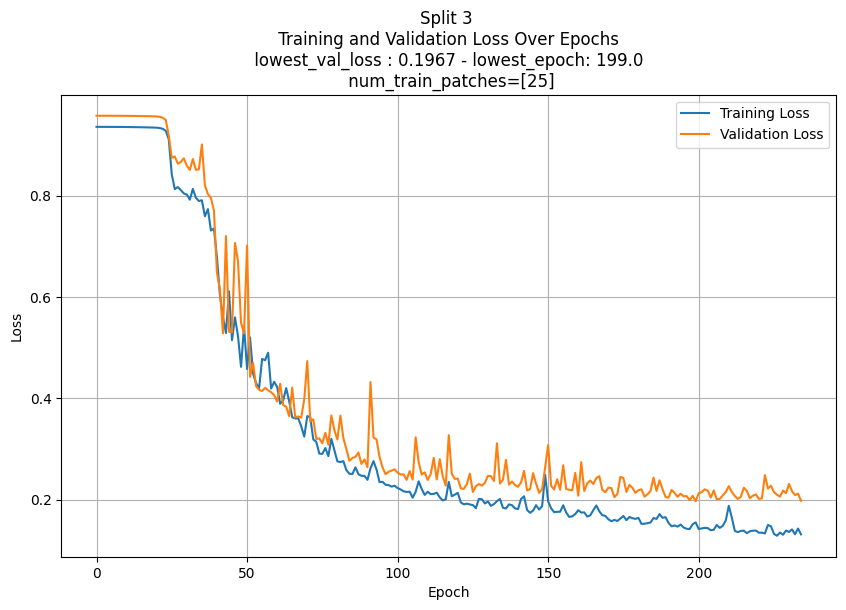


========== PLOTTING BEST_CHECKPOINT (EPOCH) VALIDATION RESULTS ==========
========== GROUND TRUTH VS PREDICTIONS ==========



/tmp/ipykernel_1082210/3107027896.py:258: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Validation results plot for split 3 saved at: executions/unet/tuning-train-test/id=123/train_test_split_3/validation_results_split_3.png


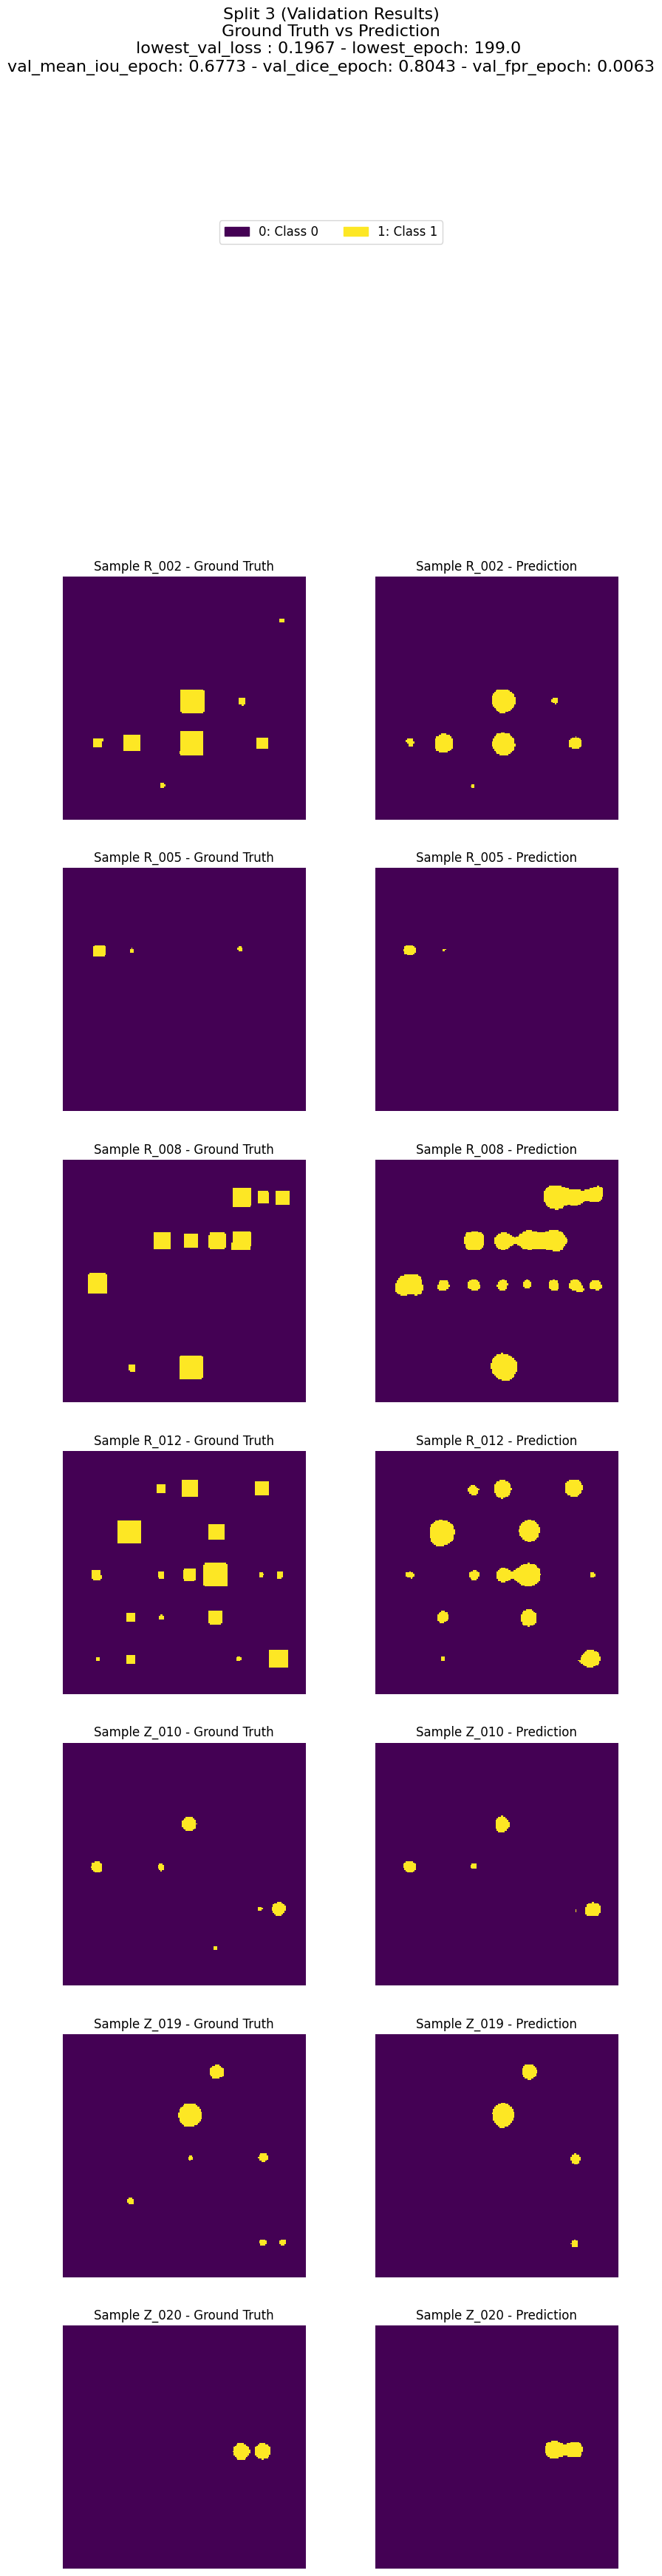


========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_003', 'R_004', 'R_017', 'Z_007', 'Z_009', 'Z_011'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_003 ...

R_003 loaded

Processing & loading sample R_004 ...

R_004 loaded

Processing & loading sample R_017 ...

R_017 loaded

Processing & loading sample Z_007 ...

Z_007 loaded

Processing & loading sample Z_009 ...

Z_009 loaded

Processing & loading sample Z_011 ...

Z_011 loaded

The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

==> DATA PREPOCESSING AND LOADING FINISHED


========== TESTING STARTS ==========

Found checkpoint: executions/unet/tuning-train-test/id=123/train_test_split_3/best-checkpoint-epoch=199-val_loss=0.20.ckpt


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

Starting testing epoch...
==> (TESTING) Average Dice Loss (include_background=[False]): 0.326622

==> (TESTING) Average Mean IoU (include_background=[False]): 0.554899

==> (TESTING) Average Dice Coefficient (include_background=[False]): 0.675260

==> (TESTING) Average FPR (include_background=[False]): 0.006196
Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.6752600073814392
     test_fpr_epoch        0.006196124944835901
     test_loss_epoch        0.3266218602657318
   test_mean_iou_epoch      0.5548993945121765
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing completed in 0h 0m 2s

========== TESTING FINISHED =========

/tmp/ipykernel_1082210/3107027896.py:404: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Testing results plot for split 3 saved at: executions/unet/tuning-train-test/id=123/train_test_split_3/testing_results_split_3.png


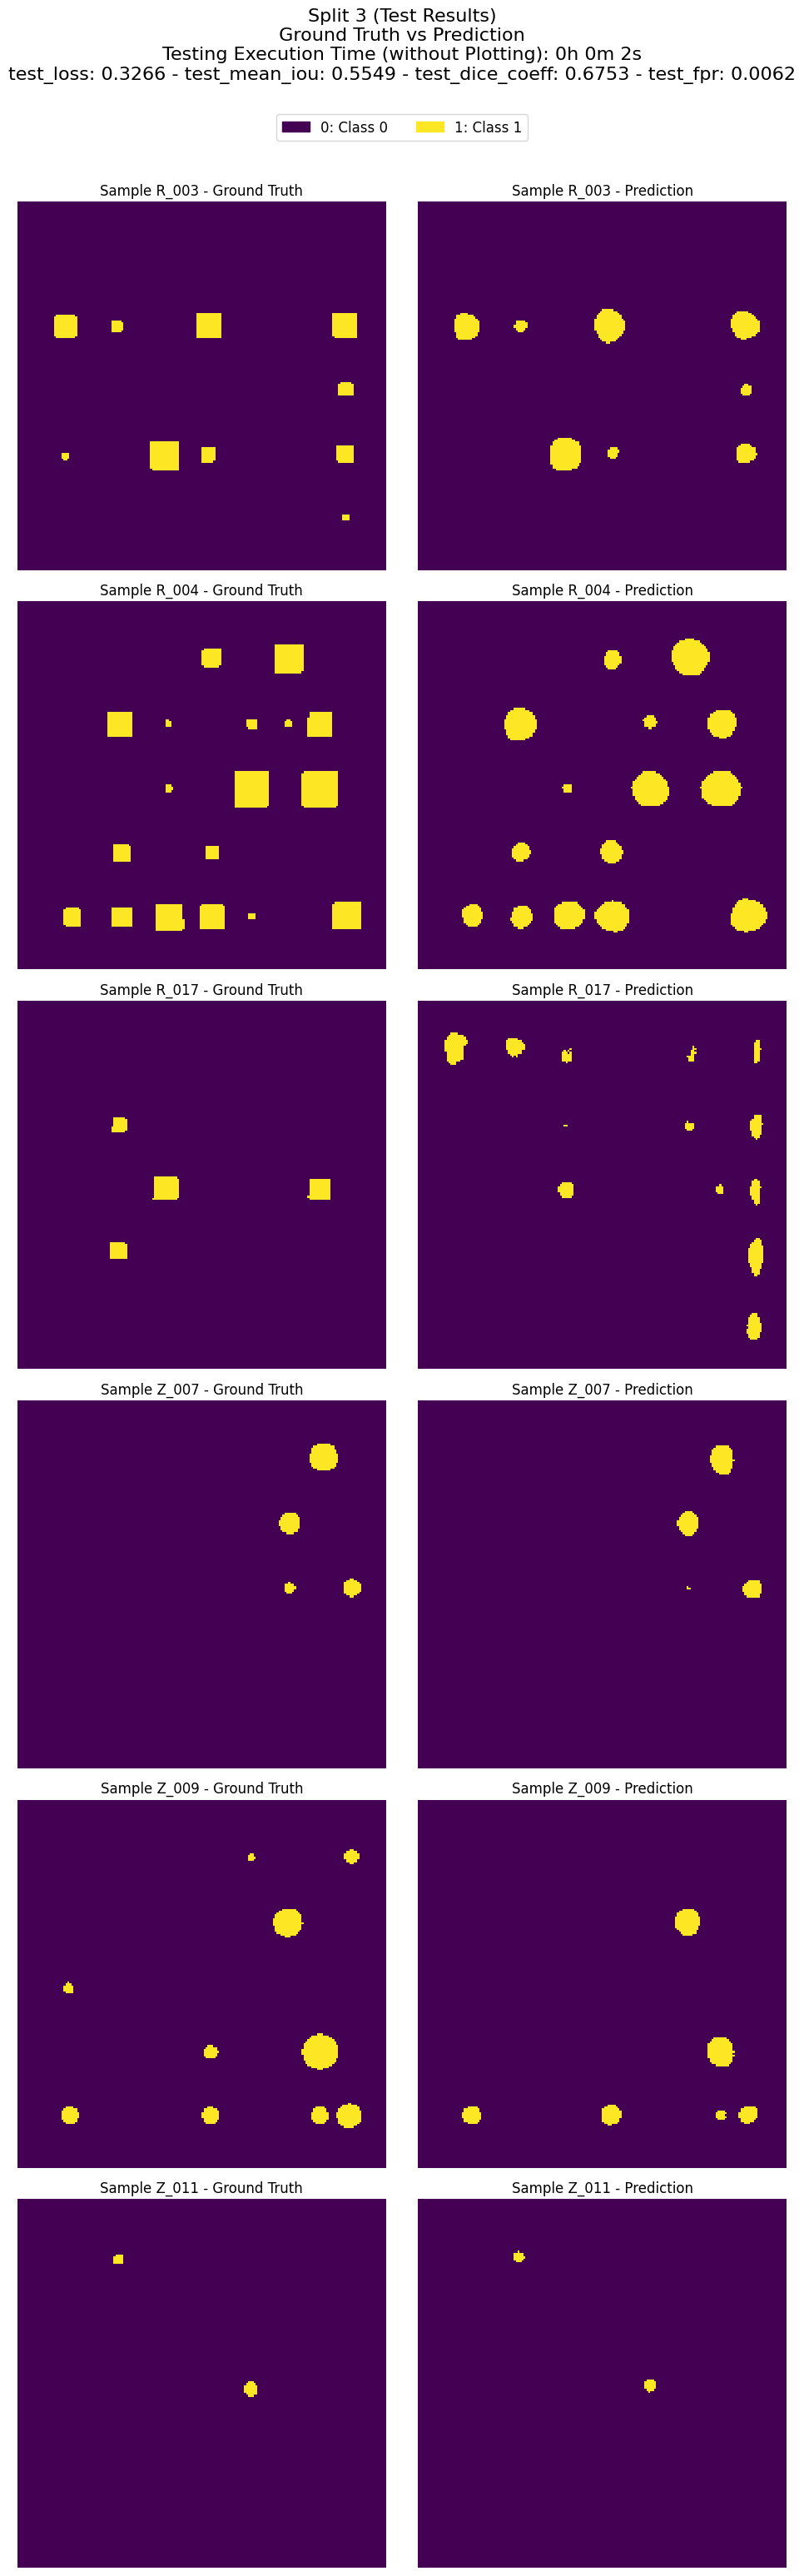

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



==================== TRAIN/TEST SPLIT: 4 ====================


===============> TRAINING DATA PREPARATION

 SAMPLES: dict_keys(['R_003', 'R_004', 'R_006', 'R_009', 'R_010', 'R_011', 'R_013', 'R_015', 'R_016', 'R_017', 'R_019', 'R_020', 'Z_002', 'Z_004', 'Z_005', 'Z_006', 'Z_007', 'Z_008', 'Z_009', 'Z_011', 'Z_013', 'Z_014', 'Z_015', 'Z_016', 'Z_018'])



==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_003 ...

R_003 loaded

Processing & loading sample R_004 ...

R_004 loaded

Processing & loading sample R_006 ...

R_006 loaded

Processing & loading sample R_009 ...

R_009 loaded

Processing & loading sample R_010 ...

R_010 loaded

Processing & loading sample R_011 ...

R_011 loaded

Processing & loading sample R_013 ...

R_013 loaded

Processing & loading sample R_015 ...

R_015 loaded

Processing & loading sample R_016 ...

R_016 loaded

Processing & loading sample R_017 ...

R_017 loaded

Processing & loading sample R_019 ...

R_019 loaded

Processing & loa

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | UNet_VGG11 | 25.4 M | train
1 | loss_fn | DiceLoss   | 0      | train
-----------------------------------------------
25.4 M    Trainable params
0         Non-trainable params
25.4 M    Total params
101.474   Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.970116

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000



Training: |                                                                                                   …

Starting training epoch 0...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958014

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.940009
Finished training epoch 0

Starting training epoch 1...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958010

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.940006
Finished training epoch 1

Starting training epoch 2...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.958000

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939999
Finished training epoch 2

Starting training epoch 3...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957987

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939984
Finished training epoch 3

Starting training epoch 4...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957969

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939966
Finished training epoch 4

Starting training epoch 5...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957949

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939940
Finished training epoch 5

Starting training epoch 6...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957921

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939911
Finished training epoch 6

Starting training epoch 7...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957889

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939875
Finished training epoch 7

Starting training epoch 8...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957856

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939832
Finished training epoch 8

Starting training epoch 9...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957818

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939785
Finished training epoch 9

Starting training epoch 10...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957769

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939734
Finished training epoch 10

Starting training epoch 11...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957719

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939671
Finished training epoch 11

Starting training epoch 12...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957663

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939602
Finished training epoch 12

Starting training epoch 13...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957599

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939525
Finished training epoch 13

Starting training epoch 14...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957520

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939443
Finished training epoch 14

Starting training epoch 15...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957448

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939340
Finished training epoch 15

Starting training epoch 16...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957359

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939242
Finished training epoch 16

Starting training epoch 17...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957273

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.939118
Finished training epoch 17

Starting training epoch 18...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957155

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.938987
Finished training epoch 18

Starting training epoch 19...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.957004

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.938810
Finished training epoch 19

Starting training epoch 20...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956775

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.938552
Finished training epoch 20

Starting training epoch 21...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.956357

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.938132
Finished training epoch 21

Starting training epoch 22...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.955181

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.263440

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.391809

==> (VALIDATION) Average FPR (include_background=[False]): 0.001598

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.937237
Finished training epoch 22

Starting training epoch 23...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.951420

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.024359

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.046835

==> (VALIDATION) Average FPR (include_background=[False]): 0.932842

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.933808
Finished training epoch 23

Starting training epoch 24...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.948633

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.027998

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.053525

==> (VALIDATION) Average FPR (include_background=[False]): 0.808049

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.929748
Finished training epoch 24

Starting training epoch 25...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.921809

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.066568

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.120608

==> (VALIDATION) Average FPR (include_background=[False]): 0.265091

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.918069
Finished training epoch 25

Starting training epoch 26...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.875286

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.072429

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.130806

==> (VALIDATION) Average FPR (include_background=[False]): 0.168417

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.855768
Finished training epoch 26

Starting training epoch 27...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.881738

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.066217

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.120102

==> (VALIDATION) Average FPR (include_background=[False]): 0.246843

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.827373
Finished training epoch 27

Starting training epoch 28...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.865265

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.075822

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137044

==> (VALIDATION) Average FPR (include_background=[False]): 0.098452

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.819975
Finished training epoch 28

Starting training epoch 29...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.865035

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076341

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137569

==> (VALIDATION) Average FPR (include_background=[False]): 0.126950

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.822363
Finished training epoch 29

Starting training epoch 30...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.864219

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076286

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.137140

==> (VALIDATION) Average FPR (include_background=[False]): 0.140478

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.813676
Finished training epoch 30

Starting training epoch 31...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.861562

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.078038

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.140280

==> (VALIDATION) Average FPR (include_background=[False]): 0.111323

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.810103
Finished training epoch 31

Starting training epoch 32...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.864407

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076126

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.136633

==> (VALIDATION) Average FPR (include_background=[False]): 0.159890

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.808968
Finished training epoch 32

Starting training epoch 33...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.863290

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.077116

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.138253

==> (VALIDATION) Average FPR (include_background=[False]): 0.162932

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.812730
Finished training epoch 33

Starting training epoch 34...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.860026

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.078418

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.141371

==> (VALIDATION) Average FPR (include_background=[False]): 0.073456

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.810802
Finished training epoch 34

Starting training epoch 35...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.854099

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.082488

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.147667

==> (VALIDATION) Average FPR (include_background=[False]): 0.098914

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.797288
Finished training epoch 35

Starting training epoch 36...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.879737

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.067255

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.121495

==> (VALIDATION) Average FPR (include_background=[False]): 0.271957

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.796966
Finished training epoch 36

Starting training epoch 37...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.864608

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.076560

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.136937

==> (VALIDATION) Average FPR (include_background=[False]): 0.190369

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.811699
Finished training epoch 37

Starting training epoch 38...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.999804

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.000000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.000000

==> (VALIDATION) Average FPR (include_background=[False]): 0.000000

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.906215
Finished training epoch 38

Starting training epoch 39...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.874956

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.069974

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.125946

==> (VALIDATION) Average FPR (include_background=[False]): 0.229023

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.875865
Finished training epoch 39

Starting training epoch 40...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.842747

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.090334

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.160123

==> (VALIDATION) Average FPR (include_background=[False]): 0.086064

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.783998
Finished training epoch 40

Starting training epoch 41...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.763625

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.203643

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.328741

==> (VALIDATION) Average FPR (include_background=[False]): 0.005157

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.752060
Finished training epoch 41

Starting training epoch 42...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.835115

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.098457

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.171798

==> (VALIDATION) Average FPR (include_background=[False]): 0.153844

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.772747
Finished training epoch 42

Starting training epoch 43...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.695376

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.322356

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.472988

==> (VALIDATION) Average FPR (include_background=[False]): 0.006004

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.769395
Finished training epoch 43

Starting training epoch 44...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.746575

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.179587

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.291523

==> (VALIDATION) Average FPR (include_background=[False]): 0.059223

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.659960
Finished training epoch 44

Starting training epoch 45...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.561505

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.354070

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.494864

==> (VALIDATION) Average FPR (include_background=[False]): 0.002546

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.603142
Finished training epoch 45

Starting training epoch 46...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.580933

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.382224

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.534500

==> (VALIDATION) Average FPR (include_background=[False]): 0.013916

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.577822
Finished training epoch 46

Starting training epoch 47...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.895481

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.057767

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.105659

==> (VALIDATION) Average FPR (include_background=[False]): 0.373773

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.696769
Finished training epoch 47

Starting training epoch 48...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.548235

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.350149

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.489973

==> (VALIDATION) Average FPR (include_background=[False]): 0.002707

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.657356
Finished training epoch 48

Starting training epoch 49...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.476990

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.403363

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.547302

==> (VALIDATION) Average FPR (include_background=[False]): 0.005767

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.507940
Finished training epoch 49

Starting training epoch 50...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.534132

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.334034

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.474053

==> (VALIDATION) Average FPR (include_background=[False]): 0.002406

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.537174
Finished training epoch 50

Starting training epoch 51...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.511584

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.367772

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.509581

==> (VALIDATION) Average FPR (include_background=[False]): 0.003024

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.590764
Finished training epoch 51

Starting training epoch 52...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.498507

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.383182

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.525436

==> (VALIDATION) Average FPR (include_background=[False]): 0.003548

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.555410
Finished training epoch 52

Starting training epoch 53...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.567828

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.310525

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.446554

==> (VALIDATION) Average FPR (include_background=[False]): 0.001306

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.503200
Finished training epoch 53

Starting training epoch 54...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.604959

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.277523

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.407264

==> (VALIDATION) Average FPR (include_background=[False]): 0.000678

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.536108
Finished training epoch 54

Starting training epoch 55...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.521848

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.348471

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.488230

==> (VALIDATION) Average FPR (include_background=[False]): 0.002336

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.515779
Finished training epoch 55

Starting training epoch 56...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.431631

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.435177

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.576335

==> (VALIDATION) Average FPR (include_background=[False]): 0.008802

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.480473
Finished training epoch 56

Starting training epoch 57...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.426960

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.442821

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.583342

==> (VALIDATION) Average FPR (include_background=[False]): 0.007500

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.452538
Finished training epoch 57

Starting training epoch 58...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.431009

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.456315

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.613000

==> (VALIDATION) Average FPR (include_background=[False]): 0.011479

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.423707
Finished training epoch 58

Starting training epoch 59...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.434390

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.435752

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.576482

==> (VALIDATION) Average FPR (include_background=[False]): 0.004656

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.444211
Finished training epoch 59

Starting training epoch 60...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.414373

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.455246

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.594234

==> (VALIDATION) Average FPR (include_background=[False]): 0.005937

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.429844
Finished training epoch 60

Starting training epoch 61...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.521765

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.377785

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.530553

==> (VALIDATION) Average FPR (include_background=[False]): 0.020871

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.596334
Finished training epoch 61

Starting training epoch 62...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.418124

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.462368

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.599871

==> (VALIDATION) Average FPR (include_background=[False]): 0.004461

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.430344
Finished training epoch 62

Starting training epoch 63...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.405079

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.468752

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.605696

==> (VALIDATION) Average FPR (include_background=[False]): 0.005722

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.411270
Finished training epoch 63

Starting training epoch 64...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.453013

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.444891

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.603744

==> (VALIDATION) Average FPR (include_background=[False]): 0.015655

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.382188
Finished training epoch 64

Starting training epoch 65...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.398856

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.473747

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.609834

==> (VALIDATION) Average FPR (include_background=[False]): 0.004821

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.388250
Finished training epoch 65

Starting training epoch 66...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.516330

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.375649

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.529860

==> (VALIDATION) Average FPR (include_background=[False]): 0.022910

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.356953
Finished training epoch 66

Starting training epoch 67...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.371726

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.484017

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.625894

==> (VALIDATION) Average FPR (include_background=[False]): 0.008002

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.387416
Finished training epoch 67

Starting training epoch 68...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.373355

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.495768

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.653533

==> (VALIDATION) Average FPR (include_background=[False]): 0.011957

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.371763
Finished training epoch 68

Starting training epoch 69...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.375067

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.493814

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.626105

==> (VALIDATION) Average FPR (include_background=[False]): 0.005310

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.351374
Finished training epoch 69

Starting training epoch 70...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.378284

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.493973

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.626261

==> (VALIDATION) Average FPR (include_background=[False]): 0.004532

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.336234
Finished training epoch 70

Starting training epoch 71...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.327266

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.530844

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.685149

==> (VALIDATION) Average FPR (include_background=[False]): 0.008849

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.371737
Finished training epoch 71

Starting training epoch 72...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.335899

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.524037

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.676440

==> (VALIDATION) Average FPR (include_background=[False]): 0.008367

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.366589
Finished training epoch 72

Starting training epoch 73...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.386522

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.492846

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.625215

==> (VALIDATION) Average FPR (include_background=[False]): 0.003735

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.479420
Finished training epoch 73

Starting training epoch 74...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.383530

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.492592

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.624993

==> (VALIDATION) Average FPR (include_background=[False]): 0.003511

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.351851
Finished training epoch 74

Starting training epoch 75...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.519900

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.364230

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.517606

==> (VALIDATION) Average FPR (include_background=[False]): 0.028693

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.338311
Finished training epoch 75

Starting training epoch 76...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.356373

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.499246

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.654086

==> (VALIDATION) Average FPR (include_background=[False]): 0.012098

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.367100
Finished training epoch 76

Starting training epoch 77...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.369314

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.506949

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.636614

==> (VALIDATION) Average FPR (include_background=[False]): 0.004079

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.343282
Finished training epoch 77

Starting training epoch 78...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.363917

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.515370

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.643246

==> (VALIDATION) Average FPR (include_background=[False]): 0.003478

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.310019
Finished training epoch 78

Starting training epoch 79...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.335431

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.530614

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.671036

==> (VALIDATION) Average FPR (include_background=[False]): 0.007802

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.305986
Finished training epoch 79

Starting training epoch 80...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311038

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.549005

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.695304

==> (VALIDATION) Average FPR (include_background=[False]): 0.007864

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.303709
Finished training epoch 80

Starting training epoch 81...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.302322

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.555046

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.700070

==> (VALIDATION) Average FPR (include_background=[False]): 0.006710

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.292822
Finished training epoch 81

Starting training epoch 82...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.350616

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.515483

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.667032

==> (VALIDATION) Average FPR (include_background=[False]): 0.012771

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.299895
Finished training epoch 82

Starting training epoch 83...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.363614

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.500786

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.631846

==> (VALIDATION) Average FPR (include_background=[False]): 0.008563

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.403423
Finished training epoch 83

Starting training epoch 84...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.359041

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.510636

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.638926

==> (VALIDATION) Average FPR (include_background=[False]): 0.006955

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.329607
Finished training epoch 84

Starting training epoch 85...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.347113

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.509705

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.663402

==> (VALIDATION) Average FPR (include_background=[False]): 0.012907

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.296437
Finished training epoch 85

Starting training epoch 86...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318672

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.556636

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.687388

==> (VALIDATION) Average FPR (include_background=[False]): 0.004860

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.295363
Finished training epoch 86

Starting training epoch 87...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318769

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.552442

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.686724

==> (VALIDATION) Average FPR (include_background=[False]): 0.005149

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.294356
Finished training epoch 87

Starting training epoch 88...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.325167

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.549160

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.680538

==> (VALIDATION) Average FPR (include_background=[False]): 0.004210

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.290190
Finished training epoch 88

Starting training epoch 89...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.331206

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.540327

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.663679

==> (VALIDATION) Average FPR (include_background=[False]): 0.005829

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.280156
Finished training epoch 89

Starting training epoch 90...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.295034

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.569207

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.711272

==> (VALIDATION) Average FPR (include_background=[False]): 0.006585

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.286942
Finished training epoch 90

Starting training epoch 91...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.305494

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.565152

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.700944

==> (VALIDATION) Average FPR (include_background=[False]): 0.004993

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.253869
Finished training epoch 91

Starting training epoch 92...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.287761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.576461

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.717239

==> (VALIDATION) Average FPR (include_background=[False]): 0.004969

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.259095
Finished training epoch 92

Starting training epoch 93...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.294202

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.570992

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.713795

==> (VALIDATION) Average FPR (include_background=[False]): 0.007418

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.256057
Finished training epoch 93

Starting training epoch 94...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.333390

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.547168

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.667306

==> (VALIDATION) Average FPR (include_background=[False]): 0.003289

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.251817
Finished training epoch 94

Starting training epoch 95...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.306000

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.566082

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.699115

==> (VALIDATION) Average FPR (include_background=[False]): 0.005520

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.242341
Finished training epoch 95

Starting training epoch 96...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.333958

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.548582

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.668254

==> (VALIDATION) Average FPR (include_background=[False]): 0.003485

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.233938
Finished training epoch 96

Starting training epoch 97...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.291822

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.570973

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.711806

==> (VALIDATION) Average FPR (include_background=[False]): 0.007770

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.247899
Finished training epoch 97

Starting training epoch 98...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.293777

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.567909

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.708561

==> (VALIDATION) Average FPR (include_background=[False]): 0.006747

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.276593
Finished training epoch 98

Starting training epoch 99...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.292651

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.575877

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.715045

==> (VALIDATION) Average FPR (include_background=[False]): 0.006527

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.244003
Finished training epoch 99

Starting training epoch 100...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.286183

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.581491

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.719223

==> (VALIDATION) Average FPR (include_background=[False]): 0.005200

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.225379
Finished training epoch 100

Starting training epoch 101...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.271138

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.594674

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.734744

==> (VALIDATION) Average FPR (include_background=[False]): 0.006425

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.222702
Finished training epoch 101

Starting training epoch 102...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.285218

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582500

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.719720

==> (VALIDATION) Average FPR (include_background=[False]): 0.005259

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.217389
Finished training epoch 102

Starting training epoch 103...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.293187

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573626

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.705659

==> (VALIDATION) Average FPR (include_background=[False]): 0.004086

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.210176
Finished training epoch 103

Starting training epoch 104...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.289209

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.571312

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.720223

==> (VALIDATION) Average FPR (include_background=[False]): 0.009802

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.261759
Finished training epoch 104

Starting training epoch 105...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.368552

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.498174

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.644402

==> (VALIDATION) Average FPR (include_background=[False]): 0.014134

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.236076
Finished training epoch 105

Starting training epoch 106...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.334810

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.545790

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.666315

==> (VALIDATION) Average FPR (include_background=[False]): 0.002755

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.260731
Finished training epoch 106

Starting training epoch 107...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.327175

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.558610

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.675748

==> (VALIDATION) Average FPR (include_background=[False]): 0.003962

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.226357
Finished training epoch 107

Starting training epoch 108...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.326332

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.556281

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.674096

==> (VALIDATION) Average FPR (include_background=[False]): 0.004185

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.208733
Finished training epoch 108

Starting training epoch 109...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.306703

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.570127

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.696755

==> (VALIDATION) Average FPR (include_background=[False]): 0.005101

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.202930
Finished training epoch 109

Starting training epoch 110...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257314

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609484

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.749863

==> (VALIDATION) Average FPR (include_background=[False]): 0.005814

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.201730
Finished training epoch 110

Starting training epoch 111...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.298327

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.574855

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.703698

==> (VALIDATION) Average FPR (include_background=[False]): 0.004127

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.203635
Finished training epoch 111

Starting training epoch 112...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.290719

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573585

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.709429

==> (VALIDATION) Average FPR (include_background=[False]): 0.004132

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192579
Finished training epoch 112

Starting training epoch 113...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.337536

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.543785

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.664952

==> (VALIDATION) Average FPR (include_background=[False]): 0.002459

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.270898
Finished training epoch 113

Starting training epoch 114...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.275836

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.591291

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.732089

==> (VALIDATION) Average FPR (include_background=[False]): 0.006246

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.227098
Finished training epoch 114

Starting training epoch 115...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.319930

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.563169

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.679423

==> (VALIDATION) Average FPR (include_background=[False]): 0.003704

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.219733
Finished training epoch 115

Starting training epoch 116...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.286229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.590423

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.719955

==> (VALIDATION) Average FPR (include_background=[False]): 0.004251

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.204872
Finished training epoch 116

Starting training epoch 117...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.276658

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.590038

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728068

==> (VALIDATION) Average FPR (include_background=[False]): 0.005582

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199902
Finished training epoch 117

Starting training epoch 118...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.330855

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.551447

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.670766

==> (VALIDATION) Average FPR (include_background=[False]): 0.002396

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196651
Finished training epoch 118

Starting training epoch 119...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.347117

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.519312

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.660393

==> (VALIDATION) Average FPR (include_background=[False]): 0.010652

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.220817
Finished training epoch 119

Starting training epoch 120...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.376486

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.493830

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.625614

==> (VALIDATION) Average FPR (include_background=[False]): 0.001184

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.243251
Finished training epoch 120

Starting training epoch 121...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.317349

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.563000

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.685202

==> (VALIDATION) Average FPR (include_background=[False]): 0.003576

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.226718
Finished training epoch 121

Starting training epoch 122...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.310947

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.568907

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.689791

==> (VALIDATION) Average FPR (include_background=[False]): 0.003329

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.199300
Finished training epoch 122

Starting training epoch 123...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.293633

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.574759

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.705501

==> (VALIDATION) Average FPR (include_background=[False]): 0.003060

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.189347
Finished training epoch 123

Starting training epoch 124...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.266037

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.599995

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.742229

==> (VALIDATION) Average FPR (include_background=[False]): 0.007272

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.225080
Finished training epoch 124

Starting training epoch 125...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.268760

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.592238

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.731098

==> (VALIDATION) Average FPR (include_background=[False]): 0.004595

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.203799
Finished training epoch 125

Starting training epoch 126...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.317070

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.565198

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.680886

==> (VALIDATION) Average FPR (include_background=[False]): 0.003064

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.196325
Finished training epoch 126

Starting training epoch 127...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.256124

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609019

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.748583

==> (VALIDATION) Average FPR (include_background=[False]): 0.005853

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.182649
Finished training epoch 127

Starting training epoch 128...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.276867

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.590641

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.724521

==> (VALIDATION) Average FPR (include_background=[False]): 0.003511

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193435
Finished training epoch 128

Starting training epoch 129...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.256783

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.609774

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.751380

==> (VALIDATION) Average FPR (include_background=[False]): 0.006887

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183334
Finished training epoch 129

Starting training epoch 130...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.273966

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.595913

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.728984

==> (VALIDATION) Average FPR (include_background=[False]): 0.003581

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183732
Finished training epoch 130

Starting training epoch 131...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.302120

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.571301

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.699287

==> (VALIDATION) Average FPR (include_background=[False]): 0.004638

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.229994
Finished training epoch 131

Starting training epoch 132...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.255035

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.613924

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.751355

==> (VALIDATION) Average FPR (include_background=[False]): 0.005277

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.214727
Finished training epoch 132

Starting training epoch 133...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318480

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.563598

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.682757

==> (VALIDATION) Average FPR (include_background=[False]): 0.002266

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185098
Finished training epoch 133

Starting training epoch 134...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237584

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.629598

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768818

==> (VALIDATION) Average FPR (include_background=[False]): 0.004734

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.208603
Finished training epoch 134

Starting training epoch 135...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.270098

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.595144

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.735997

==> (VALIDATION) Average FPR (include_background=[False]): 0.007206

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.193870
Finished training epoch 135

Starting training epoch 136...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.299316

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.573085

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.701995

==> (VALIDATION) Average FPR (include_background=[False]): 0.002505

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.185539
Finished training epoch 136

Starting training epoch 137...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234372

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.631099

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767430

==> (VALIDATION) Average FPR (include_background=[False]): 0.004694

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.183621
Finished training epoch 137

Starting training epoch 138...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.318061

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.561989

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.683139

==> (VALIDATION) Average FPR (include_background=[False]): 0.003121

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.190388
Finished training epoch 138

Starting training epoch 139...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.285761

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.582309

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.713064

==> (VALIDATION) Average FPR (include_background=[False]): 0.003909

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.206773
Finished training epoch 139

Starting training epoch 140...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234270

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635733

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771642

==> (VALIDATION) Average FPR (include_background=[False]): 0.004651

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180692
Finished training epoch 140

Starting training epoch 141...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230197

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637494

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774491

==> (VALIDATION) Average FPR (include_background=[False]): 0.005879

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177054
Finished training epoch 141

Starting training epoch 142...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.263672

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.596213

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.738540

==> (VALIDATION) Average FPR (include_background=[False]): 0.008113

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.177745
Finished training epoch 142

Starting training epoch 143...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.238894

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626192

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.763322

==> (VALIDATION) Average FPR (include_background=[False]): 0.005197

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.176904
Finished training epoch 143

Starting training epoch 144...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.304294

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.578838

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.695493

==> (VALIDATION) Average FPR (include_background=[False]): 0.002915

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.181600
Finished training epoch 144

Starting training epoch 145...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241739

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623592

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760543

==> (VALIDATION) Average FPR (include_background=[False]): 0.005521

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.160380
Finished training epoch 145

Starting training epoch 146...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237366

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628515

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765409

==> (VALIDATION) Average FPR (include_background=[False]): 0.003821

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.165765
Finished training epoch 146

Starting training epoch 147...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239001

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.622669

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.758790

==> (VALIDATION) Average FPR (include_background=[False]): 0.003836

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.162221
Finished training epoch 147

Starting training epoch 148...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234993

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636443

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.770572

==> (VALIDATION) Average FPR (include_background=[False]): 0.004247

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155021
Finished training epoch 148

Starting training epoch 149...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.231189

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.634110

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771074

==> (VALIDATION) Average FPR (include_background=[False]): 0.004434

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.164093
Finished training epoch 149

Starting training epoch 150...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.280068

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.593025

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.721142

==> (VALIDATION) Average FPR (include_background=[False]): 0.003323

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168238
Finished training epoch 150

Starting training epoch 151...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229628

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637091

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772863

==> (VALIDATION) Average FPR (include_background=[False]): 0.005208

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.184873
Finished training epoch 151

Starting training epoch 152...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222985

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645574

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779712

==> (VALIDATION) Average FPR (include_background=[False]): 0.004668

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.160776
Finished training epoch 152

Starting training epoch 153...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257426

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.616831

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745699

==> (VALIDATION) Average FPR (include_background=[False]): 0.003773

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150088
Finished training epoch 153

Starting training epoch 154...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219931

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651837

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784738

==> (VALIDATION) Average FPR (include_background=[False]): 0.004356

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151983
Finished training epoch 154

Starting training epoch 155...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.299152

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.580509

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.701033

==> (VALIDATION) Average FPR (include_background=[False]): 0.002767

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.146767
Finished training epoch 155

Starting training epoch 156...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257155

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.615971

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.744921

==> (VALIDATION) Average FPR (include_background=[False]): 0.003280

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151616
Finished training epoch 156

Starting training epoch 157...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.238048

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625601

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.762779

==> (VALIDATION) Average FPR (include_background=[False]): 0.003543

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.175157
Finished training epoch 157

Starting training epoch 158...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234611

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632363

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771194

==> (VALIDATION) Average FPR (include_background=[False]): 0.006905

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.157291
Finished training epoch 158

Starting training epoch 159...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.315439

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.572153

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.685803

==> (VALIDATION) Average FPR (include_background=[False]): 0.002886

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.192931
Finished training epoch 159

Starting training epoch 160...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239601

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625881

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760559

==> (VALIDATION) Average FPR (include_background=[False]): 0.003731

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.168362
Finished training epoch 160

Starting training epoch 161...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.255492

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.611362

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.746140

==> (VALIDATION) Average FPR (include_background=[False]): 0.002781

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156481
Finished training epoch 161

Starting training epoch 162...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229290

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.635069

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771992

==> (VALIDATION) Average FPR (include_background=[False]): 0.005845

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.156184
Finished training epoch 162

Starting training epoch 163...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.287829

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.580020

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.713626

==> (VALIDATION) Average FPR (include_background=[False]): 0.002280

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.148639
Finished training epoch 163

Starting training epoch 164...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.244461

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623074

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.757065

==> (VALIDATION) Average FPR (include_background=[False]): 0.003456

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.147388
Finished training epoch 164

Starting training epoch 165...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226699

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.636494

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773598

==> (VALIDATION) Average FPR (include_background=[False]): 0.005986

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152469
Finished training epoch 165

Starting training epoch 166...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237459

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.630448

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.765278

==> (VALIDATION) Average FPR (include_background=[False]): 0.003533

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.158535
Finished training epoch 166

Starting training epoch 167...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241397

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.623337

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760272

==> (VALIDATION) Average FPR (include_background=[False]): 0.003411

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.163390
Finished training epoch 167

Starting training epoch 168...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.228715

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643377

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775453

==> (VALIDATION) Average FPR (include_background=[False]): 0.004327

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155923
Finished training epoch 168

Starting training epoch 169...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.342318

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.538240

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.660479

==> (VALIDATION) Average FPR (include_background=[False]): 0.001590

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.207077
Finished training epoch 169

Starting training epoch 170...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.296117

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.580887

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.705257

==> (VALIDATION) Average FPR (include_background=[False]): 0.002548

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.166670
Finished training epoch 170

Starting training epoch 171...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.243204

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.626235

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.759514

==> (VALIDATION) Average FPR (include_background=[False]): 0.003153

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149894
Finished training epoch 171

Starting training epoch 172...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234334

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.629336

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.764681

==> (VALIDATION) Average FPR (include_background=[False]): 0.003579

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142031
Finished training epoch 172

Starting training epoch 173...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217220

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652859

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786662

==> (VALIDATION) Average FPR (include_background=[False]): 0.004993

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.140048
Finished training epoch 173

Starting training epoch 174...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.239576

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.628878

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.762980

==> (VALIDATION) Average FPR (include_background=[False]): 0.003540

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141561
Finished training epoch 174

Starting training epoch 175...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230887

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632922

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.769337

==> (VALIDATION) Average FPR (include_background=[False]): 0.004281

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153425
Finished training epoch 175

Starting training epoch 176...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241966

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627606

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761008

==> (VALIDATION) Average FPR (include_background=[False]): 0.003267

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136590
Finished training epoch 176

Starting training epoch 177...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224257

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643264

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776800

==> (VALIDATION) Average FPR (include_background=[False]): 0.003879

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.133874
Finished training epoch 177

Starting training epoch 178...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.261119

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.606139

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.736542

==> (VALIDATION) Average FPR (include_background=[False]): 0.003158

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152197
Finished training epoch 178

Starting training epoch 179...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.241554

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627016

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.762166

==> (VALIDATION) Average FPR (include_background=[False]): 0.005385

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.155206
Finished training epoch 179

Starting training epoch 180...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225354

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638690

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775013

==> (VALIDATION) Average FPR (include_background=[False]): 0.003662

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159120
Finished training epoch 180

Starting training epoch 181...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234885

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.627913

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.766229

==> (VALIDATION) Average FPR (include_background=[False]): 0.007261

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.149749
Finished training epoch 181

Starting training epoch 182...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.311020

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.572554

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.690807

==> (VALIDATION) Average FPR (include_background=[False]): 0.002354

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.159976
Finished training epoch 182

Starting training epoch 183...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222811

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643274

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778641

==> (VALIDATION) Average FPR (include_background=[False]): 0.005183

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.151624
Finished training epoch 183

Starting training epoch 184...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229359

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.637595

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.772308

==> (VALIDATION) Average FPR (include_background=[False]): 0.003637

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138886
Finished training epoch 184

Starting training epoch 185...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.249778

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.614244

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.752020

==> (VALIDATION) Average FPR (include_background=[False]): 0.007683

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.135063
Finished training epoch 185

Starting training epoch 186...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223978

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640270

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775263

==> (VALIDATION) Average FPR (include_background=[False]): 0.004511

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.138561
Finished training epoch 186

Starting training epoch 187...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.267212

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.606916

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.734154

==> (VALIDATION) Average FPR (include_background=[False]): 0.002506

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.137490
Finished training epoch 187

Starting training epoch 188...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.224198

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642644

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776238

==> (VALIDATION) Average FPR (include_background=[False]): 0.004311

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134723
Finished training epoch 188

Starting training epoch 189...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237985

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625641

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.760104

==> (VALIDATION) Average FPR (include_background=[False]): 0.003339

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129928
Finished training epoch 189

Starting training epoch 190...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.211029

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656365

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790202

==> (VALIDATION) Average FPR (include_background=[False]): 0.005537

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.150916
Finished training epoch 190

Starting training epoch 191...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.234058

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.633750

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.768642

==> (VALIDATION) Average FPR (include_background=[False]): 0.003045

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.145870
Finished training epoch 191

Starting training epoch 192...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229557

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639045

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773281

==> (VALIDATION) Average FPR (include_background=[False]): 0.005208

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132963
Finished training epoch 192

Starting training epoch 193...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220432

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645815

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780619

==> (VALIDATION) Average FPR (include_background=[False]): 0.003252

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.135455
Finished training epoch 193

Starting training epoch 194...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222421

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647741

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.780391

==> (VALIDATION) Average FPR (include_background=[False]): 0.004146

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124514
Finished training epoch 194

Starting training epoch 195...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.237487

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.629705

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767154

==> (VALIDATION) Average FPR (include_background=[False]): 0.007547

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126048
Finished training epoch 195

Starting training epoch 196...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.266367

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.600579

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.730588

==> (VALIDATION) Average FPR (include_background=[False]): 0.002671

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.178487
Finished training epoch 196

Starting training epoch 197...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221439

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651342

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783022

==> (VALIDATION) Average FPR (include_background=[False]): 0.003847

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.153836
Finished training epoch 197

Starting training epoch 198...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223053

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.642338

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.779312

==> (VALIDATION) Average FPR (include_background=[False]): 0.005298

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.180221
Finished training epoch 198

Starting training epoch 199...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217831

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.647315

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783243

==> (VALIDATION) Average FPR (include_background=[False]): 0.005616

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.157098
Finished training epoch 199

Starting training epoch 200...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225510

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643367

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776834

==> (VALIDATION) Average FPR (include_background=[False]): 0.003609

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.134155
Finished training epoch 200

Starting training epoch 201...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226360

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.643926

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776992

==> (VALIDATION) Average FPR (include_background=[False]): 0.003275

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123710
Finished training epoch 201

Starting training epoch 202...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208268

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662954

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794127

==> (VALIDATION) Average FPR (include_background=[False]): 0.004377

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124945
Finished training epoch 202

Starting training epoch 203...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205327

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664860

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796083

==> (VALIDATION) Average FPR (include_background=[False]): 0.004437

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123962
Finished training epoch 203

Starting training epoch 204...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215503

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652488

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.784882

==> (VALIDATION) Average FPR (include_background=[False]): 0.004916

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119003
Finished training epoch 204

Starting training epoch 205...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.229971

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.632592

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.767784

==> (VALIDATION) Average FPR (include_background=[False]): 0.002986

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.129156
Finished training epoch 205

Starting training epoch 206...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.267560

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.592895

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.729936

==> (VALIDATION) Average FPR (include_background=[False]): 0.002250

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.152596
Finished training epoch 206

Starting training epoch 207...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207680

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663277

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793844

==> (VALIDATION) Average FPR (include_background=[False]): 0.003916

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142751
Finished training epoch 207

Starting training epoch 208...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.227690

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.638469

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773139

==> (VALIDATION) Average FPR (include_background=[False]): 0.003240

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.142560
Finished training epoch 208

Starting training epoch 209...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212084

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657748

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.789772

==> (VALIDATION) Average FPR (include_background=[False]): 0.004173

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132465
Finished training epoch 209

Starting training epoch 210...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204515

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665266

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796702

==> (VALIDATION) Average FPR (include_background=[False]): 0.004751

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119870
Finished training epoch 210

Starting training epoch 211...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.222955

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645277

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777251

==> (VALIDATION) Average FPR (include_background=[False]): 0.003158

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115111
Finished training epoch 211

Starting training epoch 212...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226038

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639571

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.773893

==> (VALIDATION) Average FPR (include_background=[False]): 0.003546

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115911
Finished training epoch 212

Starting training epoch 213...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.226828

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.640545

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.775369

==> (VALIDATION) Average FPR (include_background=[False]): 0.006873

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124812
Finished training epoch 213

Starting training epoch 214...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.213841

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.654666

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787737

==> (VALIDATION) Average FPR (include_background=[False]): 0.003132

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125503
Finished training epoch 214

Starting training epoch 215...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218358

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651722

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783683

==> (VALIDATION) Average FPR (include_background=[False]): 0.003578

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.124274
Finished training epoch 215

Starting training epoch 216...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.217266

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.651611

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.783047

==> (VALIDATION) Average FPR (include_background=[False]): 0.003765

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.132685
Finished training epoch 216

Starting training epoch 217...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.221935

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.646318

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.778797

==> (VALIDATION) Average FPR (include_background=[False]): 0.003534

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.122480
Finished training epoch 217

Starting training epoch 218...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205257

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664926

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795957

==> (VALIDATION) Average FPR (include_background=[False]): 0.005626

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116727
Finished training epoch 218

Starting training epoch 219...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.236491

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.625652

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.761993

==> (VALIDATION) Average FPR (include_background=[False]): 0.002442

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125964
Finished training epoch 219

Starting training epoch 220...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.230592

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.639663

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.771146

==> (VALIDATION) Average FPR (include_background=[False]): 0.003425

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112072
Finished training epoch 220

Starting training epoch 221...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206607

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662026

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792284

==> (VALIDATION) Average FPR (include_background=[False]): 0.004202

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.113270
Finished training epoch 221

Starting training epoch 222...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.257910

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.606195

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.745319

==> (VALIDATION) Average FPR (include_background=[False]): 0.009011

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.119445
Finished training epoch 222

Starting training epoch 223...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.210229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657538

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790028

==> (VALIDATION) Average FPR (include_background=[False]): 0.004738

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.126073
Finished training epoch 223

Starting training epoch 224...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.225321

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.641943

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.774710

==> (VALIDATION) Average FPR (include_background=[False]): 0.003287

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.130915
Finished training epoch 224

Starting training epoch 225...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209314

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.658795

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790206

==> (VALIDATION) Average FPR (include_background=[False]): 0.005072

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121107
Finished training epoch 225

Starting training epoch 226...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.219679

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649226

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781556

==> (VALIDATION) Average FPR (include_background=[False]): 0.003521

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123622
Finished training epoch 226

Starting training epoch 227...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.216967

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.649980

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781598

==> (VALIDATION) Average FPR (include_background=[False]): 0.004009

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123427
Finished training epoch 227

Starting training epoch 228...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207372

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662956

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793328

==> (VALIDATION) Average FPR (include_background=[False]): 0.005082

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.112978
Finished training epoch 228

Starting training epoch 229...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215417

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655684

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787283

==> (VALIDATION) Average FPR (include_background=[False]): 0.003026

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.120417
Finished training epoch 229

Starting training epoch 230...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209056

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.660606

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.790909

==> (VALIDATION) Average FPR (include_background=[False]): 0.004117

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109162
Finished training epoch 230

Starting training epoch 231...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.200607

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.671614

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.801124

==> (VALIDATION) Average FPR (include_background=[False]): 0.004569

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109810
Finished training epoch 231

Starting training epoch 232...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196314

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676579

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.805052

==> (VALIDATION) Average FPR (include_background=[False]): 0.004602

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111088
Finished training epoch 232

Starting training epoch 233...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212215

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657557

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.788038

==> (VALIDATION) Average FPR (include_background=[False]): 0.003702

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.105467
Finished training epoch 233

Starting training epoch 234...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223792

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644042

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777031

==> (VALIDATION) Average FPR (include_background=[False]): 0.002941

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.103383
Finished training epoch 234

Starting training epoch 235...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203213

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669960

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.798810

==> (VALIDATION) Average FPR (include_background=[False]): 0.005654

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.106212
Finished training epoch 235

Starting training epoch 236...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.220269

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.650377

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781868

==> (VALIDATION) Average FPR (include_background=[False]): 0.003548

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.136087
Finished training epoch 236

Starting training epoch 237...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204144

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667984

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796377

==> (VALIDATION) Average FPR (include_background=[False]): 0.003741

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123408
Finished training epoch 237

Starting training epoch 238...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.215297

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.655351

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.785842

==> (VALIDATION) Average FPR (include_background=[False]): 0.002922

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115061
Finished training epoch 238

Starting training epoch 239...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202835

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.669078

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797264

==> (VALIDATION) Average FPR (include_background=[False]): 0.003657

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.109428
Finished training epoch 239

Starting training epoch 240...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.214815

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.656816

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.786814

==> (VALIDATION) Average FPR (include_background=[False]): 0.003484

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104079
Finished training epoch 240

Starting training epoch 241...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.209170

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665162

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793390

==> (VALIDATION) Average FPR (include_background=[False]): 0.003686

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.104243
Finished training epoch 241

Starting training epoch 242...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207006

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663734

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792847

==> (VALIDATION) Average FPR (include_background=[False]): 0.003926

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.111248
Finished training epoch 242

Starting training epoch 243...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201394

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668233

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797282

==> (VALIDATION) Average FPR (include_background=[False]): 0.003997

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.116247
Finished training epoch 243

Starting training epoch 244...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207722

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663801

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793589

==> (VALIDATION) Average FPR (include_background=[False]): 0.003822

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102228
Finished training epoch 244

Starting training epoch 245...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205523

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665964

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.795821

==> (VALIDATION) Average FPR (include_background=[False]): 0.003803

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.101400
Finished training epoch 245

Starting training epoch 246...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208893

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.662077

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793218

==> (VALIDATION) Average FPR (include_background=[False]): 0.005964

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.123547
Finished training epoch 246

Starting training epoch 247...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223550

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.644228

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.777504

==> (VALIDATION) Average FPR (include_background=[False]): 0.002921

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.141674
Finished training epoch 247

Starting training epoch 248...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203338

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667150

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796581

==> (VALIDATION) Average FPR (include_background=[False]): 0.005709

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121926
Finished training epoch 248

Starting training epoch 249...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.223875

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.645046

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.776903

==> (VALIDATION) Average FPR (include_background=[False]): 0.002811

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108711
Finished training epoch 249

Starting training epoch 250...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.198605

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.676375

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804576

==> (VALIDATION) Average FPR (include_background=[False]): 0.005077

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.114612
Finished training epoch 250

Starting training epoch 251...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.205987

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663025

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793027

==> (VALIDATION) Average FPR (include_background=[False]): 0.003584

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.105606
Finished training epoch 251

Starting training epoch 252...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206643

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.661665

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792080

==> (VALIDATION) Average FPR (include_background=[False]): 0.003810

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.097166
Finished training epoch 252

Starting training epoch 253...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.199440

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675099

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.802687

==> (VALIDATION) Average FPR (include_background=[False]): 0.005203

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.097077
Finished training epoch 253

Starting training epoch 254...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.218605

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.652228

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.781432

==> (VALIDATION) Average FPR (include_background=[False]): 0.002792

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102924
Finished training epoch 254

Starting training epoch 255...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203324

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668778

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797605

==> (VALIDATION) Average FPR (include_background=[False]): 0.003605

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.125662
Finished training epoch 255

Starting training epoch 256...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206053

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665348

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.794388

==> (VALIDATION) Average FPR (include_background=[False]): 0.003545

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.128250
Finished training epoch 256

Starting training epoch 257...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.207392

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664725

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.792920

==> (VALIDATION) Average FPR (include_background=[False]): 0.003889

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108715
Finished training epoch 257

Starting training epoch 258...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.196951

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.677159

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.804495

==> (VALIDATION) Average FPR (include_background=[False]): 0.004229

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102899
Finished training epoch 258

Starting training epoch 259...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.206849

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.664659

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793773

==> (VALIDATION) Average FPR (include_background=[False]): 0.003583

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.107078
Finished training epoch 259

Starting training epoch 260...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.208292

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.663543

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.793025

==> (VALIDATION) Average FPR (include_background=[False]): 0.003094

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.098030
Finished training epoch 260

Starting training epoch 261...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204822

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.665941

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796197

==> (VALIDATION) Average FPR (include_background=[False]): 0.003092

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.101739
Finished training epoch 261

Starting training epoch 262...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.201095

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.670953

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.799801

==> (VALIDATION) Average FPR (include_background=[False]): 0.005168

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.108647
Finished training epoch 262

Starting training epoch 263...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.212265

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.657371

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.787537

==> (VALIDATION) Average FPR (include_background=[False]): 0.006001

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.101412
Finished training epoch 263

Starting training epoch 264...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.197229

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.675886

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.803059

==> (VALIDATION) Average FPR (include_background=[False]): 0.004688

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.102759
Finished training epoch 264

Starting training epoch 265...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.203738

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668645

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797760

==> (VALIDATION) Average FPR (include_background=[False]): 0.005573

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.115241
Finished training epoch 265

Starting training epoch 266...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.204486

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.667469

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.796506

==> (VALIDATION) Average FPR (include_background=[False]): 0.004182

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.121560
Finished training epoch 266

Starting training epoch 267...


Validation: |                                                                                                 …

==> (VALIDATION) Average Dice Loss (include_background=[False]): 0.202751

==> (VALIDATION) Average Mean IoU (include_background=[False]): 0.668812

==> (VALIDATION) Average Dice Coefficient (include_background=[False]): 0.797375

==> (VALIDATION) Average FPR (include_background=[False]): 0.005651

==> (TRAINING) Average Dice Loss (Patch Level) (include_background=[False]): 0.106720
Finished training epoch 267

Training completed in 0h 5m 24s

========== TRAINING FINISHED ==========


========== PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION ==========

Lowest val_loss: 0.1963143050670623 at epoch 232.0
Training and validation loss evolution plot for split 4 saved at: executions/unet/tuning-train-test/id=123/train_test_split_4/training_validation_loss_evolution_split_4.png


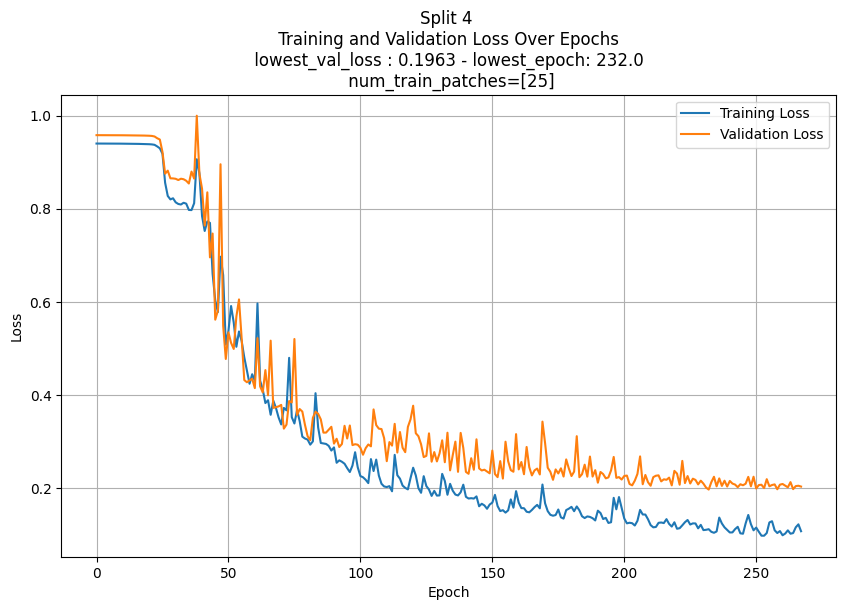


========== PLOTTING BEST_CHECKPOINT (EPOCH) VALIDATION RESULTS ==========
========== GROUND TRUTH VS PREDICTIONS ==========



/tmp/ipykernel_1082210/3107027896.py:258: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Validation results plot for split 4 saved at: executions/unet/tuning-train-test/id=123/train_test_split_4/validation_results_split_4.png


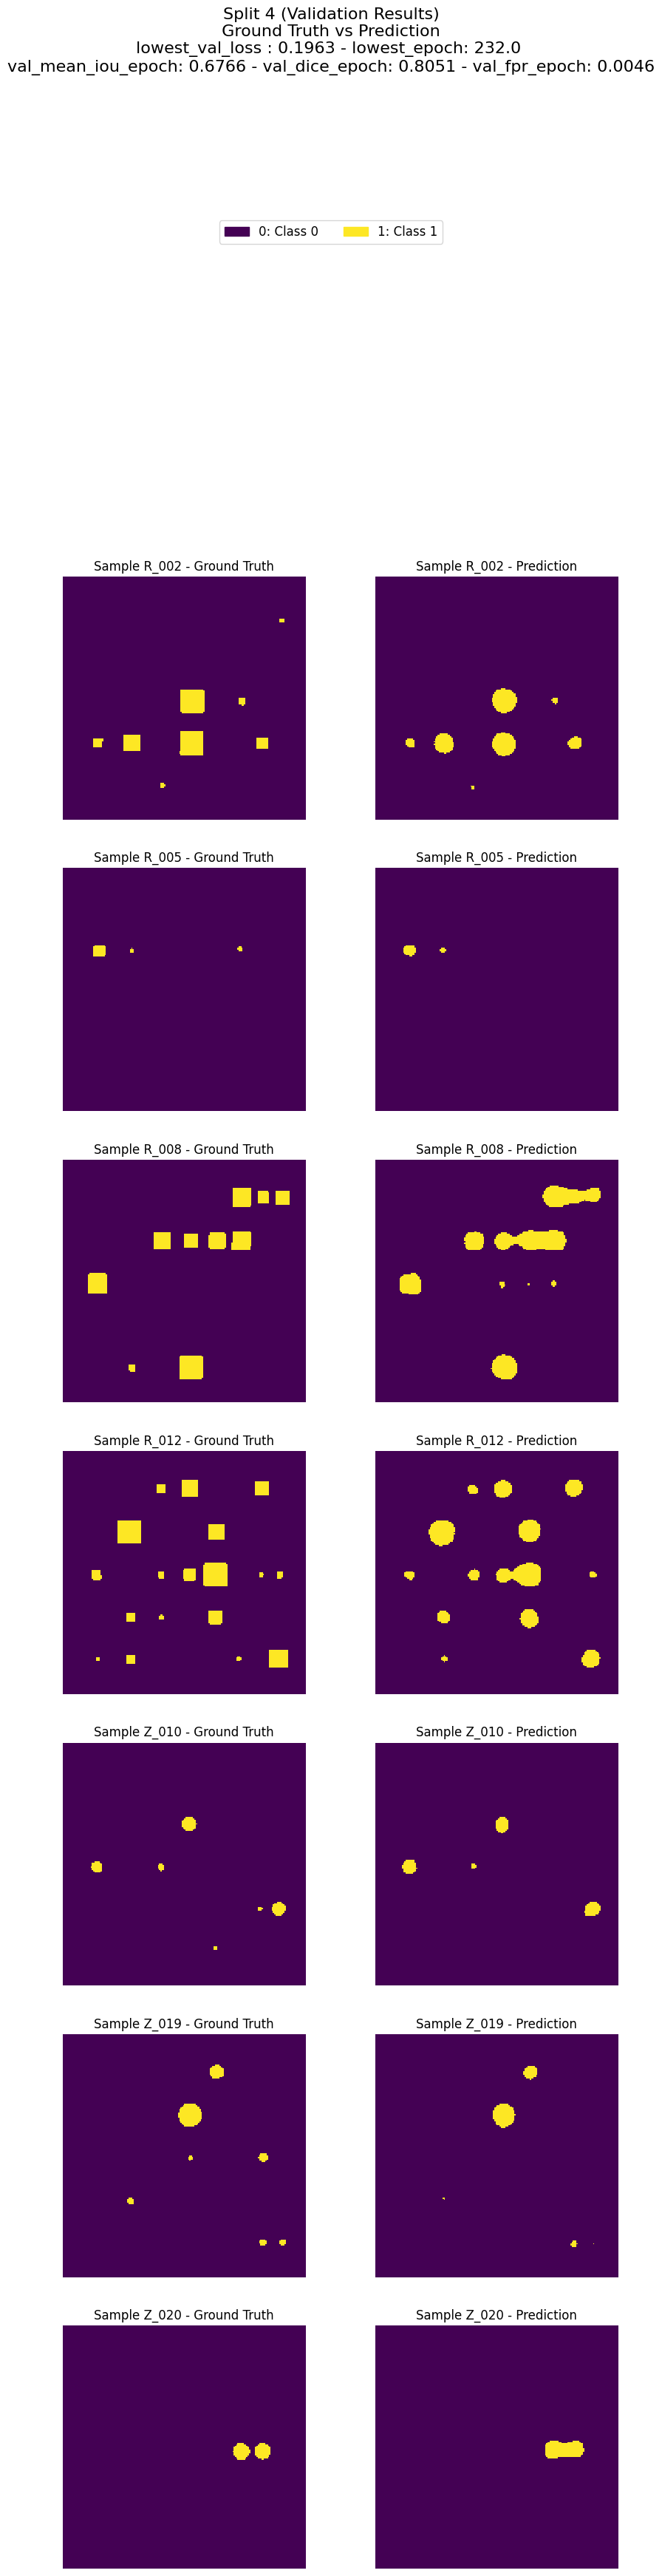


========== TESTING DATA PREPARATION ==========

 SAMPLES: dict_keys(['R_007', 'R_014', 'R_018', 'Z_003', 'Z_012', 'Z_017'])

==> DATA PREPOCESSING AND LOADING STARTS

Processing & loading sample R_007 ...

R_007 loaded

Processing & loading sample R_014 ...

R_014 loaded

Processing & loading sample R_018 ...

R_018 loaded

Processing & loading sample Z_003 ...

Z_003 loaded

Processing & loading sample Z_012 ...

Z_012 loaded

Processing & loading sample Z_017 ...

Z_017 loaded

The JSON file '/home/adrian/AIRT_Segmentation_Project/experimenting/data/train_data/preprocessed_files/unet/preprocessed_info.json' has been updated.

==> DATA PREPOCESSING AND LOADING FINISHED


========== TESTING STARTS ==========

Found checkpoint: executions/unet/tuning-train-test/id=123/train_test_split_4/best-checkpoint-epoch=232-val_loss=0.20.ckpt


/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/adrian/AIRT_Segmentation_Project/experimenting/.env_experimenting/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

Starting testing epoch...
==> (TESTING) Average Dice Loss (include_background=[False]): 0.297488

==> (TESTING) Average Mean IoU (include_background=[False]): 0.586841

==> (TESTING) Average Dice Coefficient (include_background=[False]): 0.703227

==> (TESTING) Average FPR (include_background=[False]): 0.009101
Finished testing epoch
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_dice_epoch        0.7032272219657898
     test_fpr_epoch         0.00910132471472025
     test_loss_epoch        0.29748791456222534
   test_mean_iou_epoch      0.5868409276008606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing completed in 0h 0m 2s

========== TESTING FINISHED ========

/tmp/ipykernel_1082210/3107027896.py:404: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Testing results plot for split 4 saved at: executions/unet/tuning-train-test/id=123/train_test_split_4/testing_results_split_4.png


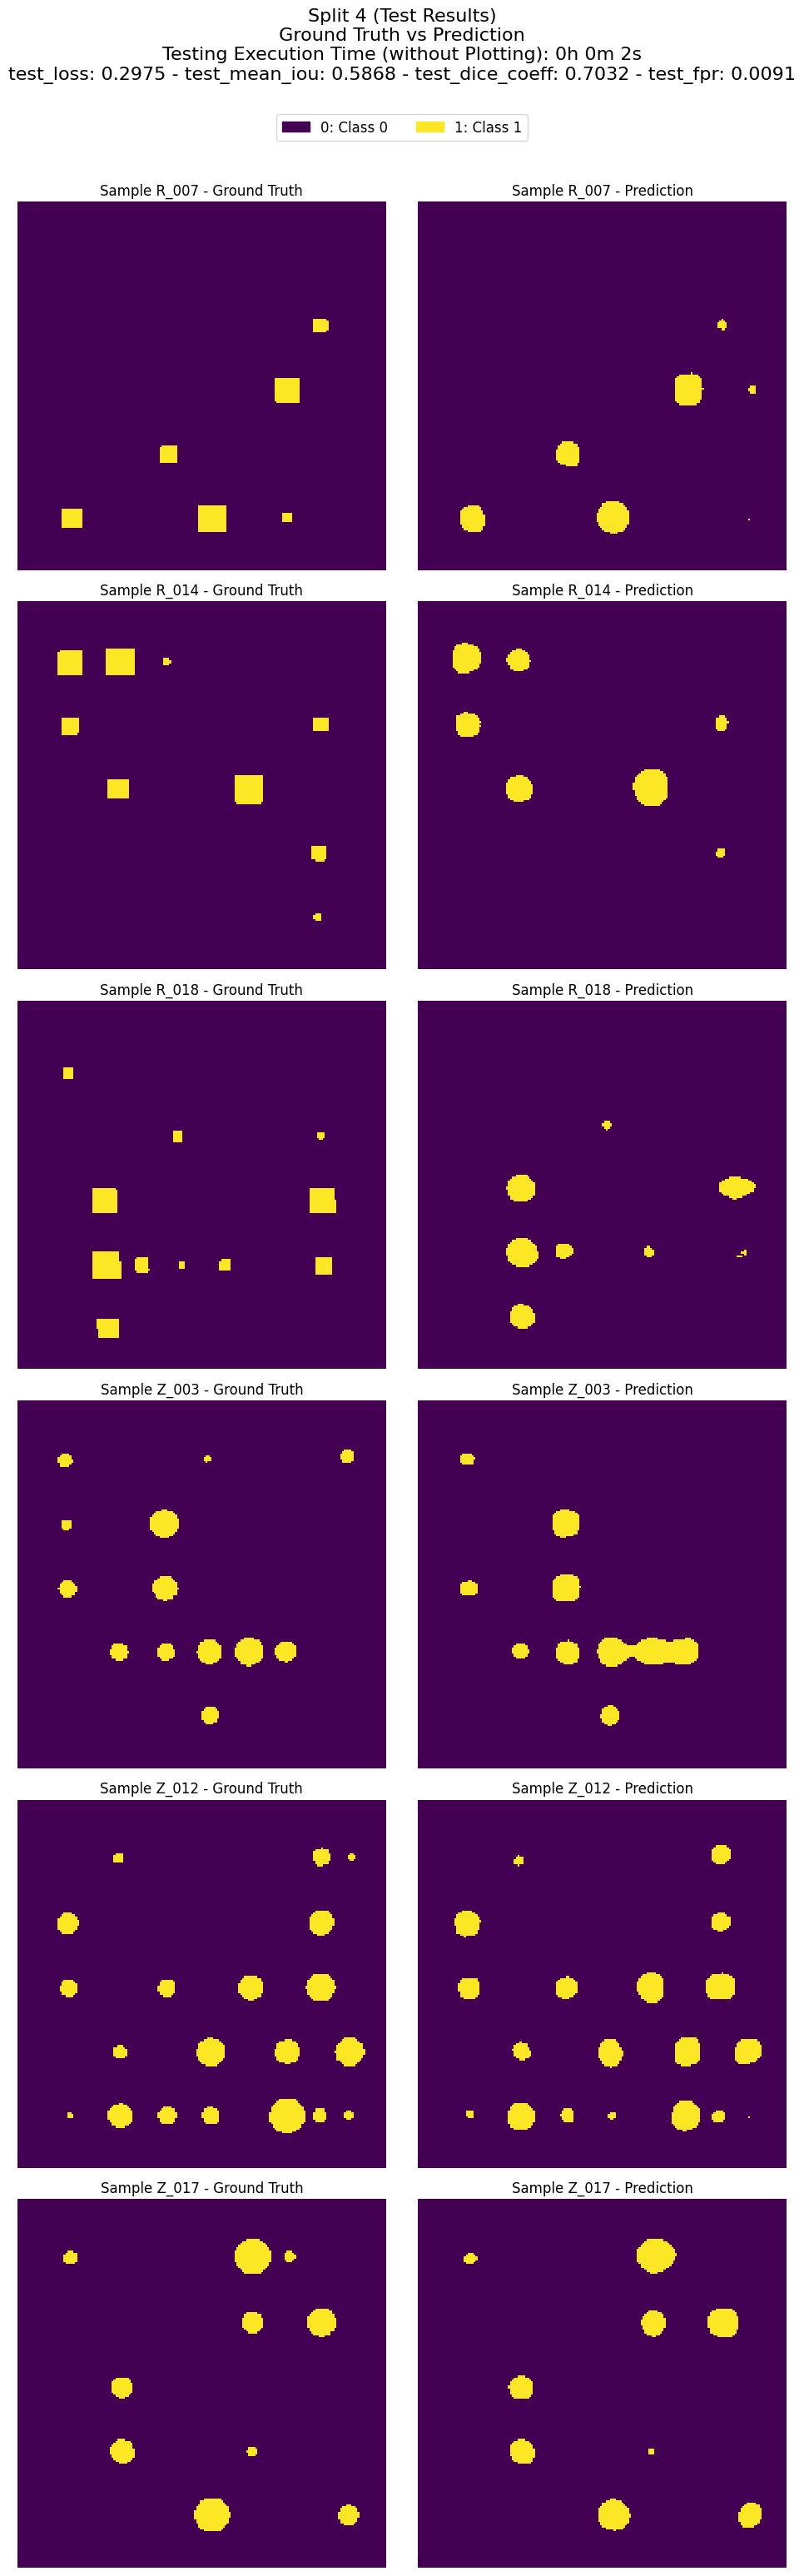

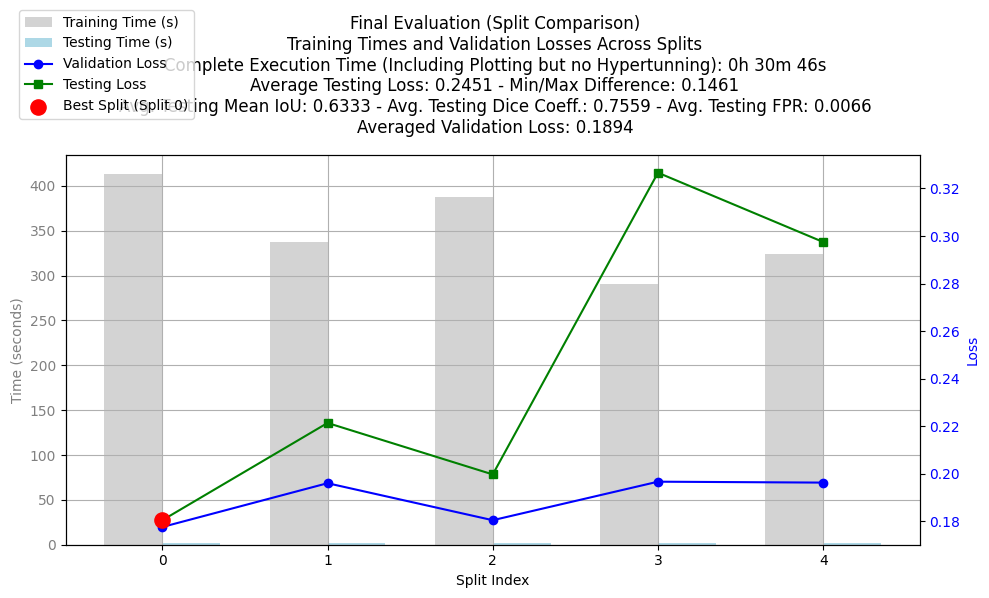

In [16]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd
import time
import shutil
import gc
import numpy as np

training_times_splits = []
testing_times_splits = []
validation_losses_splits = []
testing_losses_splits = []
testing_mean_iou_splits = []
testing_dice_splits = []
testing_fpr_splits = []
best_split_testing_loss = 1
best_split = None

# Measure start training time
start_execution_time = time.time()

for split_idx, (train_files, test_files) in enumerate(train_test_splits):

    # Clear the GPU cache between splits
    torch.cuda.empty_cache()
    
    ####################################################################################
    ############################# DATA PREPARATION #####################################
    ####################################################################################
    
    print()
    print(f"{'=' * 50}")
    print(f"{'=' * 20} TRAIN/TEST SPLIT: {split_idx} {'=' * 20}")
    print(f"{'=' * 50}")
    print()

    print()
    print(f"{'=' * 15}> TRAINING DATA PREPARATION")
    print()

    print(f" SAMPLES: {train_files.keys()}")
    print()
    print()
    print()
    
    train_dataset = UNET_VGG11_Dataset(
            metadata_dict_with_files_selected=train_files,
            data_dir=DATA_DIR,
            preprocessing_technique = best_trial_config["TRAINING_CONFIG"]["pre_processing_technique"],
            preprocessing_channels = best_trial_config["TRAINING_CONFIG"]["pre_processing_channels"]
            
    )

    print()
    print()
    print(f"{'=' * 15}> VALIDATION DATA PREPARATION")
    print()

    print(f" SAMPLES: {validation_files.keys()}")
    print()
    print()
    print()

    val_dataset = UNET_VGG11_Dataset(
            metadata_dict_with_files_selected=validation_files,
            data_dir=DATA_DIR,
            preprocessing_technique = best_trial_config["TRAINING_CONFIG"]["pre_processing_technique"],
            preprocessing_channels = best_trial_config["TRAINING_CONFIG"]["pre_processing_channels"]
    )
       
    train_loader = DataLoader(train_dataset, batch_size=best_trial_config["TRAINING_CONFIG"]["batch_size"], shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=best_trial_config["TRAINING_CONFIG"]["batch_size"], num_workers=NUM_WORKERS)

    print()

    ####################################################################################
    ############################# TRAINER SETTING ######################################
    ####################################################################################

    split_dir = os.path.join(execution_dir, f"train_test_split_{split_idx}")
    
    # Model checkpoint callback    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath=split_dir,
        filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        mode='min'
    )
    
    # Early stopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=best_trial_config["TRAINING_CONFIG"]["patience_epochs_early_stopping"],
        mode='min'
    )
    
    # Define logger
    logger = CSVLogger(
        save_dir=split_dir,
        name="",
        version="")
    
    trainer = Trainer(
        max_epochs=best_trial_config["TRAINING_CONFIG"]["max_training_epochs"],
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=1, # log every n batches
        logger=logger,
        precision="16-mixed",  # Enable FP16 mixed precision
        # max_time="00:00:02:00"  # Limit TIME (DD:HH:MM:SS format)
    )
    

    ####################################################################################
    ############################### TRAINING ###########################################
    ####################################################################################

    print()
    print(f"{'=' * 10} TRAINING STARTS {'=' * 10}")
    print()
            
    # Measure start training time
    start_time = time.time()
    
    # Define and initilize model
    model = UNET_VGG11_LightningModel(
            lr_optimizer = best_trial_config["TRAINING_CONFIG"]["lr_optimizer"],
            weight_decay_optimizer = best_trial_config["TRAINING_CONFIG"]["weight_decay_optimizer"],
            warmup_epochs_lr_scheduler = best_trial_config["TRAINING_CONFIG"]["warmup_epochs_lr_scheduler"]
    )
    
    # Fit the model
    trainer.fit(model, train_loader, val_loader)
    
    # Measure end training time
    end_time = time.time()
    
    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time

    training_times_splits.append(elapsed_time)
    
    print(f"Training completed in {elapsed_time // 3600:.0f}h {elapsed_time % 3600 // 60:.0f}m {elapsed_time % 60:.0f}s")

    print()
    print(f"{'=' * 10} TRAINING FINISHED {'=' * 10}")
    print()
    
    ####################################################################################
    ################## PLOTTING TRAINING & VALIDATION LOSSES ###########################
    ####################################################################################

    print()
    print(f"{'=' * 10} PLOTTING TRAINING & VALIDATION LOSSES EVOLUTION {'=' * 10}")
    print()
    
    # Path to the latest metrics file
    metrics_file = os.path.join(split_dir, 'metrics.csv')
    
    # Load the logged metrics
    metrics_df = pd.read_csv(metrics_file)

    # Initialize variables to make them accessible outside the if scope
    lowest_val_loss = None
    lowest_epoch = None

    # Ensure val_loss column exists and drop NaN values
    if 'val_loss_epoch' in metrics_df.columns:
        val_loss_series = metrics_df['val_loss_epoch'].dropna()
        # Find the lowest val_loss
        lowest_val_loss = val_loss_series.min()
        # Find the epoch corresponding to the lowest val_loss
        lowest_val_loss_row = metrics_df.loc[val_loss_series.idxmin()]
        lowest_epoch = lowest_val_loss_row['epoch']
    
        print(f"Lowest val_loss: {lowest_val_loss} at epoch {lowest_epoch}")
    else:
        print(f"val_loss column not found in {metrics_file}")

    validation_losses_splits.append(lowest_val_loss)
    
    # Ensure metrics_df is loaded
    # Filter rows where train_loss_epoch and val_loss_epoch are not NaN
    train_loss = metrics_df['train_loss_epoch'].dropna()
    val_loss = metrics_df['val_loss_epoch'].dropna()
    
    # Use the 'epoch' column as x-axis
    epochs_train = metrics_df.loc[metrics_df['train_loss_epoch'].notna(), 'epoch']
    epochs_val = metrics_df.loc[metrics_df['val_loss_epoch'].notna(), 'epoch']
    
    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_train, train_loss, label="Training Loss")
    plt.plot(epochs_val, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Split {split_idx} \n Training and Validation Loss Over Epochs \n lowest_val_loss : {lowest_val_loss:.4f} - lowest_epoch: {lowest_epoch} \n num_train_patches=[" + str(len(train_dataset)) + "]")
    plt.legend()
    plt.grid(True)
    
    # Save the plot to the folder
    plot_path = os.path.join(split_dir, f"training_validation_loss_evolution_split_{split_idx}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')  # Save as PNG with high resolution
    print(f"Training and validation loss evolution plot for split {split_idx} saved at: {plot_path}")
    
    plt.show()
    
    ####################################################################################
    ###################### PLOTTING BEST_CHECKPOINT RESULTS ############################
    ####################################################################################
    
    print()
    print(f"{'=' * 10} PLOTTING BEST_CHECKPOINT (EPOCH) VALIDATION RESULTS {'=' * 10}")
    print(f"{'=' * 10} GROUND TRUTH VS PREDICTIONS {'=' * 10}")
    print()
    
    # Path to the best checkpoint
    best_checkpoint_path = checkpoint_callback.best_model_path
    
    # Extract the best epoch number from the checkpoint filename
    best_epoch = float(best_checkpoint_path.split("best-checkpoint-")[1].split("epoch=")[1].split("-")[0]) # best-checkpoint-epoch=02-val_loss=0.85
    
    # Get metrics for the best epoch
    metrics_for_best_epoch = metrics_df.loc[metrics_df['epoch'] == best_epoch]
    val_loss_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_loss_epoch'].notna(), 'val_loss_epoch'].values[0]
    val_mean_iou_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_mean_iou_epoch'].notna(), 'val_mean_iou_epoch'].values[0]
    val_dice_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_dice_epoch'].notna(), 'val_dice_epoch'].values[0]
    val_fpr_epoch = metrics_for_best_epoch.loc[metrics_for_best_epoch['val_fpr_epoch'].notna(), 'val_fpr_epoch'].values[0]
    
    # Titles for the plots
    plot_title_template = (
        f"lowest_val_loss : {lowest_val_loss:.4f} - lowest_epoch: {lowest_epoch} \n"
        f"val_mean_iou_epoch: {val_mean_iou_epoch:.4f} - "
        f"val_dice_epoch: {val_dice_epoch:.4f} - "
        f"val_fpr_epoch: {val_fpr_epoch:.4f}"
    )
    
    # Find unique classes dynamically
    all_classes = set()
    for gt, pred in zip(model.best_epoch_val_ground_truths, model.best_epoch_val_predictions):
        all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
        all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions
    
    # Sort the classes to ensure order
    all_classes = sorted(all_classes)
    
    # Define class labels dynamically (for simplicity, use numeric labels for now)
    class_labels = {cls: f"Class {cls}" for cls in all_classes}
    num_classes = len(class_labels)
    
    # Create a discrete colormap with exactly `num_classes` colors
    colormap = plt.cm.get_cmap("viridis", num_classes)
    
    # Create legend patches using discrete colors from the colormap
    legend_patches = [
        mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
        for i, label in class_labels.items()
    ]
    
    # Plot all results together
    num_samples = len(model.best_epoch_val_ground_truths)
    
    # Create the figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    
    # Ensure axes is always 2D
    if num_samples == 1:
        axes = axes[None, :]  # Ensure axes is 2D when there's only one sample
    
    # Plot ground truth and predictions
    for sample_idx, (sample_id, ground_truth, prediction) in enumerate(zip(model.best_epoch_val_sample_ids, model.best_epoch_val_ground_truths, model.best_epoch_val_predictions)):
        # Ground truth
        im_gt = axes[sample_idx, 0].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
        axes[sample_idx, 0].set_title(f"Sample {sample_id} - Ground Truth")
        axes[sample_idx, 0].axis("off")
    
        # Prediction
        im_pred = axes[sample_idx, 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
        axes[sample_idx, 1].set_title(f"Sample {sample_id} - Prediction")
        axes[sample_idx, 1].axis("off")
    
    # Add a single legend for the entire figure
    fig.legend(
        handles=legend_patches,
        loc="upper center",
        ncol=num_classes,
        bbox_to_anchor=(0.5, 1.02),
        fontsize=12
    )
    
    # Add a title for the entire figure
    fig.suptitle(f"Split {split_idx} (Validation Results)\n Ground Truth vs Prediction \n" + plot_title_template, fontsize=16, y=1.10)
    plt.tight_layout
    
    # Save the combined plot
    plot_path = os.path.join(split_dir, f"validation_results_split_{split_idx}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Validation results plot for split {split_idx} saved at: {plot_path}")
    plt.show()
    
    plt.close(fig)

    ############################################################################################
    ################################### TESTING DATA PREPARATION ###############################
    ############################################################################################
    
    print()
    print(f"{'=' * 10} TESTING DATA PREPARATION {'=' * 10}")
    print()
    
    print(f" SAMPLES: {test_files.keys()}")
    print()
    

    test_dataset = UNET_VGG11_Dataset(
            metadata_dict_with_files_selected=test_files,
            data_dir=DATA_DIR,
            preprocessing_technique = best_trial_config["TRAINING_CONFIG"]["pre_processing_technique"],
            preprocessing_channels = best_trial_config["TRAINING_CONFIG"]["pre_processing_channels"]
    )
       
    test_loader = DataLoader(test_dataset, batch_size=best_trial_config["TRAINING_CONFIG"]["batch_size"], num_workers=NUM_WORKERS)

    ####################################################################################
    ############################## TESTING #############################################
    ####################################################################################
    
    print()
    print(f"{'=' * 10} TESTING STARTS {'=' * 10}")
    print()
            
    # Measure start training time
    start_time = time.time()
    
    # Find all .ckpt files in the directory
    ckpt_files = [filename for filename in os.listdir(split_dir) if filename.endswith('.ckpt')]
    
    # Handle different cases
    if not ckpt_files:
        raise FileNotFoundError(f"No .ckpt file found in the directory: {split_dir}")
    elif len(ckpt_files) > 1:
        raise RuntimeError(f"Multiple .ckpt files found in the directory: {split_dir} -> {ckpt_files}")
    else:
        model_checkpoint_path = os.path.join(split_dir, ckpt_files[0])
        print(f"Found checkpoint: {model_checkpoint_path}")
    
    # Load the best model
    best_model = UNET_VGG11_LightningModel.load_from_checkpoint(
        checkpoint_path=model_checkpoint_path,
        
        lr_optimizer = best_trial_config["TRAINING_CONFIG"]["lr_optimizer"],
        weight_decay_optimizer = best_trial_config["TRAINING_CONFIG"]["weight_decay_optimizer"],
        warmup_epochs_lr_scheduler = best_trial_config["TRAINING_CONFIG"]["warmup_epochs_lr_scheduler"]
    )
    
    test_results = trainer.test(best_model, dataloaders=test_loader)[0]
    
    # Measure end training time
    end_time = time.time()
    
    # Calculate and print the elapsed time
    testing_elapsed_time = end_time - start_time

    testing_times_splits.append(testing_elapsed_time)
    
    print(f"Testing completed in {testing_elapsed_time // 3600:.0f}h {testing_elapsed_time % 3600 // 60:.0f}m {testing_elapsed_time % 60:.0f}s")
    
    print()
    print(f"{'=' * 10} TESTING FINISHED {'=' * 10}")
    print()

    ####################################################################################
    ############################## PLOTTING TEST RESULTS ###############################
    ####################################################################################
    
    test_ground_truths = best_model.test_ground_truths
    test_predictions = best_model.test_predictions
    test_sample_ids = best_model.test_sample_ids
    test_loss = test_results["test_loss_epoch"]
    test_mean_iou = test_results["test_mean_iou_epoch"]
    test_dice_coeff = test_results["test_dice_epoch"]
    test_fpr = test_results["test_fpr_epoch"]
    
    # Find unique classes dynamically
    all_classes = set()
    for gt, pred in zip(test_ground_truths, test_predictions):
        all_classes.update(torch.unique(gt).tolist())  # Add classes from ground truth
        all_classes.update(torch.unique(pred).tolist())  # Add classes from predictions
    
    # Sort the classes to ensure order
    all_classes = sorted(all_classes)
    
    # Define class labels dynamically (for simplicity, use numeric labels for now)
    class_labels = {cls: f"Class {cls}" for cls in all_classes}
    num_classes = len(class_labels)
    
    # Create a discrete colormap with exactly `num_classes` colors
    colormap = plt.cm.get_cmap("viridis", num_classes)
    
    # Create legend patches using discrete colors from the colormap
    legend_patches = [
        mpatches.Patch(color=colormap(i), label=f"{i}: {label}")
        for i, label in class_labels.items()
    ]
    
    # Plot all results together
    num_samples = len(test_ground_truths)
    
    
    # Create the figure
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
    
    # Ensure axes is always 2D
    if num_samples == 1:
        axes = axes[None, :]  # Ensure axes is 2D when there's only one sample
    
    # Plot ground truth and predictions
    for sample_idx, (sample_id, ground_truth, prediction) in enumerate(zip(test_sample_ids, test_ground_truths, test_predictions)):
        # Ground truth
        im_gt = axes[sample_idx, 0].imshow(ground_truth.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
        axes[sample_idx, 0].set_title(f"Sample {sample_id} - Ground Truth")
        axes[sample_idx, 0].axis("off")
    
        # Prediction
        im_pred = axes[sample_idx, 1].imshow(prediction.cpu().numpy(), cmap="viridis", interpolation="none", vmin=min(all_classes), vmax=max(all_classes))
        axes[sample_idx, 1].set_title(f"Sample {sample_id} - Prediction")
        axes[sample_idx, 1].axis("off")
    
    # Add a single legend for the entire figure
    fig.legend(
        handles=legend_patches,
        loc="upper center",
        ncol=num_classes,
        bbox_to_anchor=(0.5, 0.99),
        fontsize=12
    )
   
    # Titles for the plots
    plot_title_template = (
        f"Testing Execution Time (without Plotting): {testing_elapsed_time // 3600:.0f}h {testing_elapsed_time % 3600 // 60:.0f}m {testing_elapsed_time % 60:.0f}s\n"
        f"test_loss: {test_loss:.4f} - "
        f"test_mean_iou: {test_mean_iou:.4f} - "
        f"test_dice_coeff: {test_dice_coeff:.4f} - "
        f"test_fpr: {test_fpr:.4f}"
    )
    
    # Add a title for the entire figure
    fig.suptitle(f"Split {split_idx} (Test Results)\n Ground Truth vs Prediction \n" + plot_title_template, fontsize=16, y=1.03)
    plt.tight_layout()
    
    # Save the combined plot
    plot_path = os.path.join(split_dir, f"testing_results_split_{split_idx}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Testing results plot for split {split_idx} saved at: {plot_path}")
    plt.show()
    
    plt.close(fig)
    
    del model
    del best_model
    del trainer
    torch.cuda.empty_cache()
    gc.collect()    

    ####################################################################################
    ############################ SPLIT PERFORMANCE COMPARISON ###########################
    ####################################################################################

    testing_losses_splits.append(test_loss)
    testing_mean_iou_splits.append(test_mean_iou)
    testing_dice_splits.append(test_dice_coeff)
    testing_fpr_splits.append(test_fpr)
    
    if test_loss < best_split_testing_loss:
        best_split = split_idx
        best_split_testing_loss = test_loss
        
        # Generate the directory name to keep
        # keep_dir_name = f"split_{best_split}"        
        # # Iterate through the items in the base directory
        # for item in os.listdir(execution_dir):
        #     item_path = os.path.join(execution_dir, item)         
        #     # Check if the item is a directory and not the one we want to keep
        #     if os.path.isdir(item_path) and item != keep_dir_name:
        #         try:
        #             # Remove the directory and its contents
        #             shutil.rmtree(item_path)
        #         except Exception as e:
        #             print(f"Failed to delete {item_path}. Reason: {e}")        
        # print("New best split updated in execution folder")

# Measure end training time
end_execution_time = time.time()
    
# Calculate and print the elapsed time
elapsed_execution_time = end_execution_time - start_execution_time

####################################################################################
############################ ANALYSING SPLIT PERFORMANCE ###########################
####################################################################################

# Number of splits
splits = np.arange(len(training_times_splits))

# Create the figure and axis for the combined plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Training Times
bar_width = 0.35  # Width of the bars
bar_offset = bar_width / 2
ax1.bar(splits - bar_offset, training_times_splits, color='lightgrey', width=bar_width, label='Training Time (s)')
ax1.bar(splits + bar_offset, testing_times_splits, color='lightblue', width=bar_width, label='Testing Time (s)')
ax1.set_xlabel("Split Index")
ax1.set_ylabel("Time (seconds)", color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

# Line plot for Validation Losses
ax2 = ax1.twinx()
ax2.plot(splits, validation_losses_splits, marker='o', color='blue', label='Validation Loss', zorder=3)
ax2.plot(splits, testing_losses_splits, marker='s', color='green', label='Testing Loss', zorder=3)
ax2.scatter(best_split, best_split_testing_loss, color='red', s=120, zorder=4, label=f'Best Split (Split {best_split})')
ax2.set_ylabel("Loss", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Compute mean and standard deviation
avg_validation_loss = np.mean(validation_losses_splits)
avg_testing_loss = np.mean(testing_losses_splits)
avg_testing_mean_iou = np.mean(testing_mean_iou_splits)
avg_testing_dice = np.mean(testing_dice_splits)
avg_testing_fpr = np.mean(testing_fpr_splits)
# Calculate testing loss min, max, and their difference
testing_loss_min_value = np.min(testing_losses_splits)
testing_loss_max_value = np.max(testing_losses_splits)
testing_loss_min_max_difference = testing_loss_max_value - testing_loss_min_value

plot_title = (
    "Final Evaluation (Split Comparison)\n"
    "Training Times and Validation Losses Across Splits\n"
    f"Complete Execution Time (Including Plotting but no Hypertunning): {elapsed_execution_time // 3600:.0f}h {elapsed_execution_time % 3600 // 60:.0f}m {elapsed_execution_time % 60:.0f}s\n"
    f"Average Testing Loss: {avg_testing_loss:.4f} - Min/Max Difference: {testing_loss_min_max_difference:.4f}\n"
    f"Avg. Testing Mean IoU: {avg_testing_mean_iou:.4f} - Avg. Testing Dice Coeff.: {avg_testing_dice:.4f} - Avg. Testing FPR: {avg_testing_fpr:.4f}\n"
    f"Averaged Validation Loss: {avg_validation_loss:.4f}"
)

# Title and Grid
fig.suptitle(plot_title,)
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.017, 1.00))
ax1.grid(True)

# Save the combined plot
plot_path = os.path.join(execution_dir, f"final_evaluation.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
    
plt.close(fig)